# Standard modules

In [2]:
import tracemalloc
import psutil
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
import pandas as pd
import numpy as np
from time import time
pd.options.display.max_colwidth = 1000

In [3]:
from sklearn import show_versions
show_versions()


System:
    python: 3.9.12 (main, Jun  1 2022, 11:38:51)  [GCC 7.5.0]
executable: /home/mauricio/miniconda3/envs/dev/bin/python
   machine: Linux-5.15.0-46-generic-x86_64-with-glibc2.35

Python dependencies:
      sklearn: 1.1.1
          pip: 22.1.2
   setuptools: 61.2.0
        numpy: 1.21.5
        scipy: 1.7.3
       Cython: None
       pandas: 1.4.3
   matplotlib: 3.5.1
       joblib: 1.1.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: mkl
         prefix: libmkl_rt
       filepath: /home/mauricio/miniconda3/envs/dev/lib/libmkl_rt.so.1
        version: 2021.4-Product
threading_layer: intel
    num_threads: 8

       user_api: openmp
   internal_api: openmp
         prefix: libomp
       filepath: /home/mauricio/miniconda3/envs/dev/lib/libomp.so
        version: None
    num_threads: 16


In [4]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
Supporte

In [5]:
from scipy import show_config
show_config()

lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']


# Custom modules

In [6]:
# Custom modules: add the 'lib' directory as one where we can import modules
lib_src = '../../machine-learning'
sys.path.insert(1, lib_src)
from size import size
from to_csv_to_zip import to_csv_to_zip
from fit_cache import fit_cache
lib_src = '../../homewise/ds-core/'
sys.path.insert(1, lib_src)
from tools import glimpse, correlation_heatmap, numeric_statistics

# Exploring training data

## Load and view training data

In [7]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
glimpse(df, n=19)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 25 entries, Function to Text_1
dtypes: float64(2), object(23)
memory usage: 548.5 MB


,field,non-null count,missing ratio,data type,unique count,unique preview
0,FTE,126071,0.685041,float64,21003,"[-0.000255593312793, -0.000313463508459, -0.000964788883325, -0.00106383646319, -0.00120436417783, -0.00125058955312, -0.00152471703847, -0.00235146055508, -0.00236862245679, -0.00236874491052, -0.00312517888832, -0.00329969879518, -0.00399840571505, -0.00609814945625, -0.0065228832951899, -0.00816326530612, -0.0163042738622, -0.0181150334899, -0.0200123152709, ..., 46.8, 5.0, 5.16675708492e-07, 5.17063081696e-07, 5.24941272196e-07, 5.26315789473e-07, 5.4, 5.5, 6.0, 6.505213034909999e-19, 6.6, 7.0, 7.2, 7.6, 8.2, 8.4, 9.0, 9.6, 9.77249628643e-07]"
1,Facility_or_Department,53886,0.865378,object,179,"[""(Year End Allocation To , ""Human Resources, Administration"", ""Maintenance, Construction Projects"", ""Technology Department, Administration"", ACCOUNTABILITY, ADULT EDUCATION, ADULT PROGRAMS, AGRICULTURE , AIR CONDITIONING/REFRIGERATION, ART , ATHLETICS, ATHLETICS , ATTENDANCE, AUTO:HS , Academic Decathlon, Accounting And Business Services Department, All Campus Payroll, Area Superintendents, Athletic Department, ..., TITLE SERVICE SCHOOLS , TRANSFERS AND ENROLLMENT, TRANSPORTATION, TV PRODUCT:HS , Tax Office, Textbook Department, Textbook Warehouse Department, Transportation Department, USING DATA HUMAN CAPITAL DECIS, VISION, Virtual School, Vocational, WAREHOUSE, WAREHOUSE , WAREHOUSE & GROUNDS , WASTE WATER/SEWAGE PLANT , WEB DESIGN , WRITING TEAMS , Warehousing]"
2,Function,400277,0.0,object,37,"[Aides Compensation, Career & Academic Counseling, Communications, Curriculum Development, Data Processing & Information Services, Development & Fundraising, Enrichment, Extended Time & Tutoring, Facilities & Maintenance, Facilities Planning, Finance, Budget, Purchasing & Distribution, Food Services, Governance, Human Resources, Instructional Materials & Supplies, Insurance, Legal, Library & Media, NO_LABEL, Other Compensation, Other Non-Compensation, Parent & Community Relations, Physical Health & Services, Professional Development, Recruitment, Research & Accountability, School Administration, School Supervision, Security & Safety, Social & Emotional, Special Population Program Management & Support, Student Assignment, Student Transportation, Substitute Compensation, Teacher Compensation, Untracked Budget Set-Aside, Utilities]"
3,Function_Description,342195,0.145105,object,687,"[ CENTURY CLASSROON COLLABO, CENTURY TOOLKIT GRANT, CNTRY COMMTY LRNG - , COP's CAPITAL FACILITIES, ELA SUMMER ACADEMY, GOB, GOB Refunding, GOB's REFUNDING, INT OF SCL & MENTAL HLTH, PCOPS-LEASE PAYMENTS, PENSION COP's, RETIREE HEALTH BENEFIT, SOC WORK PART (TANF), START SCHOOL GRANTS, SUCCESS, ""Guidance, Counseling And Evaluation Services"", (blank), A TO Z GRANT , ACADEMY, ..., URBAN PRINCIPALS LDRSHP PROG, VIOLIN PROJECT, VOCATIONAL (K-12) , VOCATIONAL ADULT PREP , VOCATIONAL ADULT SUPL , VOLUNTEER SERVICES, Vehicle Operation Services, Vehicle Servicing And Maintenance Services*, Vehicle Servicing and Maintenance Services*, Visually Handicapped *, WELLNESS COORDINATOR, WELLNESS IN , WELLNESS TEAM SPONSORSHIP, WHIZ KIDS TUTORING, WIRED WORKFORCE, WORK STUDY, WORK STUDY , Work Study Coordinator, YOUTH SERVICES]"
4,Fund_Description,202877,0.493158,object,141,"[ Regional Collaboratives, Virtual School Network Receiver, ""Title Part A ARRA, ""Title Part A Improving Basic Programs"", ""Title Part C - Migrant"", ""Title II, Part D, ARRA - RACE TO THE TOP , ARRA Grants (Not Including Stabilization Grants), Advanced Plancement International Baccalaurate Inc, Alternative Schools, Auxiliary Services, Basic Skills Programs For High School Students / H, Bond Retirement, Building, CO & DS , CONVERSION CHARTER SCHOOLS , COP , COP , COPY CENTER INTERNAL SERVICES , ..., TITLE IV, TRUST FUND , Title School Improvement Stimulus A, Title School Improvement Stimulus G, Title I, Title I - Disadvantaged Children/Targeted Assistance, Title I Elementary and Secondary 

### Multi-class multi-label

According to [https://www.drivendata.org/competitions/4/box-plots-for-education/page/15/#labels_list] the labels are handled in alphabetical order.

`Object_Type` describes what the spending "is" while the other 8 categories describe what the spending "does", which groups of students benefit, and where the funds come from.

In [8]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']

There is a hierarchical relationship for these labels. If a line is marked as `'Non-Operating'` in the `Operating_Status` category, then all of the other labels should be marked as `'NO_LABEL'` since ERS does not analyze and compare non-operating budget items.

Checking which `Operating_Status` come along with all other labels marked as `'NO_LABEL'`.

In [9]:
other_labels = [l for l in LABELS if l !='Operating_Status']
df[(df[other_labels]=='NO_LABEL').all(axis=1)].groupby(['Operating_Status'] + other_labels,).size()

Operating_Status        Function  Object_Type  Position_Type  Pre_K     Reporting  Sharing   Student_Type  Use     
Non-Operating           NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL    48034
Operating, Not PreK-12  NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL     8665
dtype: int64

### Features

* `FTE` If an employee, the percentage of full-time that the employee works.
* `Facility_or_Department` - If expenditure is tied to a department/facility, that department/facility.
* `Function_Description` - A description of the function the expenditure was serving.
* `Fund_Description` - A description of the source of the funds.
* `Job_Title_Description` - If this is an employee, a description of that employee's job title.
* `Location_Description` - A description of where the funds were spent.
* `Object_Description` - A description of what the funds were used for.
* `Position_Extra` - Any extra information about the position that we have.
* `Program_Description` - A description of the program that the funds were used for.
* `SubFund_Description` - More detail on Fund_Description
* `Sub_Object_Description` - More detail on Object_Description
* `Text_1` - Any additional text supplied by the district.
* `Text_2` - Any additional text supplied by the district.
* `Text_3` - Any additional text supplied by the district.
* `Text_4` - Any additional text supplied by the district.
* `Total` The total cost of the expenditure.

In [10]:
FEATURES = [feature for feature in df.columns if feature not in LABELS]
glimpse(df[FEATURES])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 16 entries, Object_Description to Text_1
dtypes: float64(2), object(14)
memory usage: 309.5 MB


,field,non-null count,missing ratio,data type,unique count,unique preview
0,FTE,126071,0.685041,float64,21003,"[-0.000255593312793, -0.000313463508459, -0.000964788883325, -0.00106383646319, -0.00120436417783, ..., 8.2, 8.4, 9.0, 9.6, 9.77249628643e-07]"
1,Facility_or_Department,53886,0.865378,object,179,"[""(Year End Allocation To , ""Human Resources, Administration"", ""Maintenance, Construction Projects"", ""Technology Department, Administration"", ACCOUNTABILITY, ..., WAREHOUSE & GROUNDS , WASTE WATER/SEWAGE PLANT , WEB DESIGN , WRITING TEAMS , Warehousing]"
2,Function_Description,342195,0.145105,object,687,"[ CENTURY CLASSROON COLLABO, CENTURY TOOLKIT GRANT, CNTRY COMMTY LRNG - , COP's CAPITAL FACILITIES, ELA SUMMER ACADEMY, ..., WIRED WORKFORCE, WORK STUDY, WORK STUDY , Work Study Coordinator, YOUTH SERVICES]"
3,Fund_Description,202877,0.493158,object,141,"[ Regional Collaboratives, Virtual School Network Receiver, ""Title Part A ARRA, ""Title Part A Improving Basic Programs"", ""Title Part C - Migrant"", ..., Trust And Agency Funds, Vocational Basic Ed., Vocational Education Enhancement, Vocational Education-Federal Funded, Vocational Education: Carl D. Perkins Vocational Education Act of ]"
4,Job_Title_Description,292743,0.268649,object,3516,"[ , , Hour General ed aide, Appliance Repair Tech , Athletic Field Tech , ..., prog mgr speech lang pathology, program coord family care, program coordinator:child fin, recruitment coordinator, special assistant to exec dir]"
5,Location_Description,162054,0.595145,object,354,"[ACADEMY, ACCOUNTABILITY, TESTING, RESEARCH & EVAL, ACCOUNTABILITY-RESEARCH-EVAL, ACCOUNTING SERVICE OFFICE, ACCOUNTS PAYABLE, ..., VOCATIONAL/TECHNICAL SCHOOLS, WAREHOUSE AND SUPPORT , WAREHOUSE OPERATIONS, WELLNESS CENTER, WORK STUDY OFFICE]"
6,Object_Description,375493,0.061917,object,602,"[""Building Purchase, Construction Or Improvements"", *******SUSPENSE*******, ADDITIONAL INCOME ALLOWANCE, ADDITIONAL/EXTRA DUTY PAY/STIP, ADMINISTRATIVE FEES, ..., WHEN ACTUALLY EMPLOYED - WAE, WORKERS' COMPENSATION , WORKERS' COMPENSATION INSURANC, WORKSHOP PARTICIPANT , Water and Sewage *]"
7,Position_Extra,264764,0.338548,object,580,"[ CUSTODIAN, MON-N/CERT, 1ST GRADE , 1ST GRADE , 2ND GRADE , ..., VOCATIONAL COUNSELOR, VOE STUDENT, WAREHOUSE SUPER , WEB MASTER, WRONG-USED FOR POS.CNTRL ONLY]"
8,Program_Description,304660,0.238877,object,421,"[ GRADUATE STUDENT SHOWCASE, GrwPln to ESE , Portable Renov-Nw ESE, ""Title I, Part A Schoolwide Activities Related To State Comp, (blank), ..., Vocational Construction Related Equipment - STATE BOND FUNDS, Vocational Industry Certification State, Vocational Supervisors, WAREHOUSE & DISTRIBUTION, WRITE FOR THE FUTURE WORKSHOP ]"
9,SubFund_Description,306855,0.233393,object,274,"[ Bond Funded, Century Community Learning Part B, MILL LEVY, Support for Homeless Education, Virtual School Network Receiver, ..., VOCATIONAL EDUCATION - CARL D. PERKINS, VOCATIONAL LABORATORY PROGRAM 9-12, Vocational Instruction, YOUTH INITIATIVE, YOUTH SERVICES CENTER]"


### Numeric features

In [11]:
NUMERIC_FEATURES = ['FTE', 'Total']
TEXT_FEATURES = [text_feature for text_feature in FEATURES if text_feature not in NUMERIC_FEATURES]
glimpse(df[NUMERIC_FEATURES])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 2 entries, FTE to Total
dtypes: float64(2)
memory usage: 9.2 MB


,field,non-null count,missing ratio,data type,unique count,unique preview
0,FTE,126071,0.685041,float64,21003,"[-0.000255593312793, -0.000313463508459, -0.000964788883325, -0.00106383646319, -0.00120436417783, ..., 8.2, 8.4, 9.0, 9.6, 9.77249628643e-07]"
1,Total,395722,0.01138,float64,286430,"[-0.004162455553, -0.01, -0.0128689914276, -0.0199999999994599, -0.02, ..., 99999.72, 99999.79, 99999.9, 99999.97, 999999.43]"


## Missing values

Overall count and proportion of missing data

In [12]:
missing = df.isnull()
missing.sum().sum(), missing.sum().sum() / (df.shape[0] * df.shape[1])

(2942109, 0.29400729994478825)

In [13]:
# plt.figure(figsize=(25,12))
# sns.heatmap(~missing, cbar=False)
# plt.show()

### Missing features

Missing report function: Count and proportion of missing data per column

In [14]:
def missing_report(df):
    area = (df.shape[0]*(df.shape[1]))
    proportion = lambda x: x.sum() / area
    missing = df.isnull().agg(['sum', 'mean', proportion]).transpose()
    missing = missing.sort_values('sum', ascending=False)
    missing.columns = ['missing', 'column proportion', 'overall proportion']
    missing['missing'] = missing.missing.astype('int')
    return missing

In [15]:
missing_report(df[FEATURES])

,missing,column proportion,overall proportion
Text_4,346531,0.865728,0.054108
Facility_or_Department,346391,0.865378,0.054086
Text_2,312060,0.779610,0.048726
Sub_Object_Description,308674,0.771151,0.048197
Text_3,291125,0.727309,0.045457
FTE,274206,0.685041,0.042815
Location_Description,238223,0.595145,0.037197
Fund_Description,197400,0.493158,0.030822
Position_Extra,135513,0.338548,0.021159
Text_1,107992,0.269793,0.016862


The numeric variable `FTE` lacks `68%` and `Total` lacks only `1%`.  The most frequent text column is `Object Description`.

### **No missing labels**

No label has missing data

In [16]:
missing[LABELS].all().all()

False

### **Missing `FTE`**

Let's subtotal missing `FTE` by `Object Description`: One can see high ocurrence of 'EMPLOYEE BENEFITS', similar object descriptions and also 'SUPPLIES'.

In [17]:
df.fillna({'Object_Description':'NaN'}).loc[df.FTE.isnull()].groupby('Object_Description').size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                 47495
CONTRA BENEFITS                   19381
ADDITIONAL/EXTRA DUTY PAY/STIP    16841
SUPPLIES                          13117
RETIREMENT CONTRIB.               13073
                                  ...  
RESERVE                               1
RESIDENTIAL FACILITIES                1
Custodial  Supplies                   1
Remaining Other Vendors               1
OTHER MATERIALS AND SUPPLIES          1
Length: 555, dtype: int64

### **Missing `Total`**

Let's subtotal missing `Total` by `Object Description`:  One can see high occurrence in 'EMPLOYEE BENEFITS' and similar object descriptions.

In [18]:
df.fillna({'Object_Description':'NaN'}).loc[df.Total.isnull()].groupby('Object_Description').size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                                     1184
SALARIES OF REGULAR EMPLOYEES                          876
EMPLOYER PD MED CONTRIBUTION                           295
Salaries And Wages For Teachers And Other Professi     288
NaN                                                    261
                                                      ... 
PRINTING, BINDING, DUPLICATING                           1
POSTAGE                                                  1
PART TIME OVERTIME WAGES                                 1
FOOD SRV-NON REFRIGERATION PRT                           1
OTHER PURCHASED SERVICES                                 1
Length: 217, dtype: int64

### Missing Total and FTE relationship

`Total` related to missing `FTE`: High `Total` values, like 129,7 millions, not related to (missing) `FTE`.

In [19]:
df.loc[df.FTE.isnull(), ['Total', 'FTE', 'Object_Description']].sort_values('Total', ascending=False)

,Total,FTE,Object_Description
358538,1.297000e+08,NaN,Payments to a Community School*
322149,5.323797e+07,NaN,Other Purchased Services
390959,4.789057e+07,NaN,PAYMENTS TO ESCROW AGENTS
177775,3.956446e+07,NaN,INTEREST ON LEASES
331752,3.645094e+07,NaN,BUILDINGS
...,...,...,...
300250,NaN,NaN,EMPLOYEE BENEFITS
289753,NaN,NaN,SALARIES OF REGULAR EMPLOYEES
438970,NaN,NaN,EMPLOYEE BENEFITS
334668,NaN,NaN,EMPLOYEE BENEFITS


`FTE` related to missing `Total`: Highest `FTE` values, close to 1, whose missing `Total` is not clear.

In [20]:
df.loc[df.Total.isnull(), ['Total', 'FTE', 'Object_Description']].sort_values('FTE', ascending=False)

,Total,FTE,Object_Description
392540,NaN,1.127804,SALARIES OF REGULAR EMPLOYEES
147244,NaN,1.016335,SALARIES OF REGULAR EMPLOYEES
91088,NaN,1.012847,SALARIES OF REGULAR EMPLOYEES
60354,NaN,1.012223,SALARIES OF REGULAR EMPLOYEES
203019,NaN,1.009218,SALARIES OF REGULAR EMPLOYEES
...,...,...,...
300250,NaN,NaN,EMPLOYEE BENEFITS
289753,NaN,NaN,SALARIES OF REGULAR EMPLOYEES
438970,NaN,NaN,EMPLOYEE BENEFITS
334668,NaN,NaN,EMPLOYEE BENEFITS


## Continuous variables: FTE and Total

`FTE`: full-time equivalent
If the budget item is associated to an employee, this number tells us the **percentage** of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.

`Total`: total cost of the expenditure.
This number tells us how much the budget item cost.

In [21]:
numeric_statistics(df)

,count,mean,std,min,25%,50%,75%,max,missing,miss_ratio,sum,range,skewness,kurtosis,iqr,lo_outlier,hi_outlier
FTE,126071,0.426794,0.573576,-8.755064e-02,0.000792,0.130927,1.0000,4.680000e+01,274206,0.685041,5.380634e+04,4.688755e+01,19.273698,1172.951126,0.999208,-1.49802,2.498812
Total,395722,13105.856828,368225.392358,-8.746631e+07,73.797700,461.230000,3652.6625,1.297000e+08,4555,0.011380,5.186276e+09,2.171663e+08,100.319800,51040.801730,3578.864800,-5294.49950,9020.959700


Function to plot a panel with a scatter, density and box plots:

In [22]:
from scipy.stats import zscore
def density_plots(x, label=None, outlying = True, zthreshold = 3, bins=None, figsize=(25,5)):

    if outlying:
        x_mean = x.mean()
        x_std = x.std()
        lower_limit = x_mean - zthreshold * x_std
        upper_limit = x_mean + zthreshold * x_std
        outliers = x[(zscore(x) < -zthreshold) | (zscore(x) > zthreshold)]

    plt.figure(figsize=figsize)

    # scatter plot
    plt.subplot(1,3,1); plt.grid(False)
    plt.plot(x, marker='.', linestyle='none', color='green', label='inlier')
    plt.ylabel(label); plt.xlabel('row')
    if outlying:
        plt.plot(outliers, marker='.', linestyle='none', color='red', label='outlier')
        plt.axhline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    # density plot
    plt.subplot(1,3,2); plt.grid(False)
    plt.hist(x, bins=bins)
    plt.xlabel(label); plt.ylabel('PDF')

    if outlying:
        plt.axvline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axvline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    # box plot
    plt.subplot(1,3,3); plt.grid(False)
    # sns.boxplot(y=x, orient='v')
    plt.boxplot(x)
    # plt.ylabel(label)
    # plt.xticks=False

    if outlying:
        plt.axhline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

### `FTE` univariate analysis

`FTE` contains skewed data with upper outliers

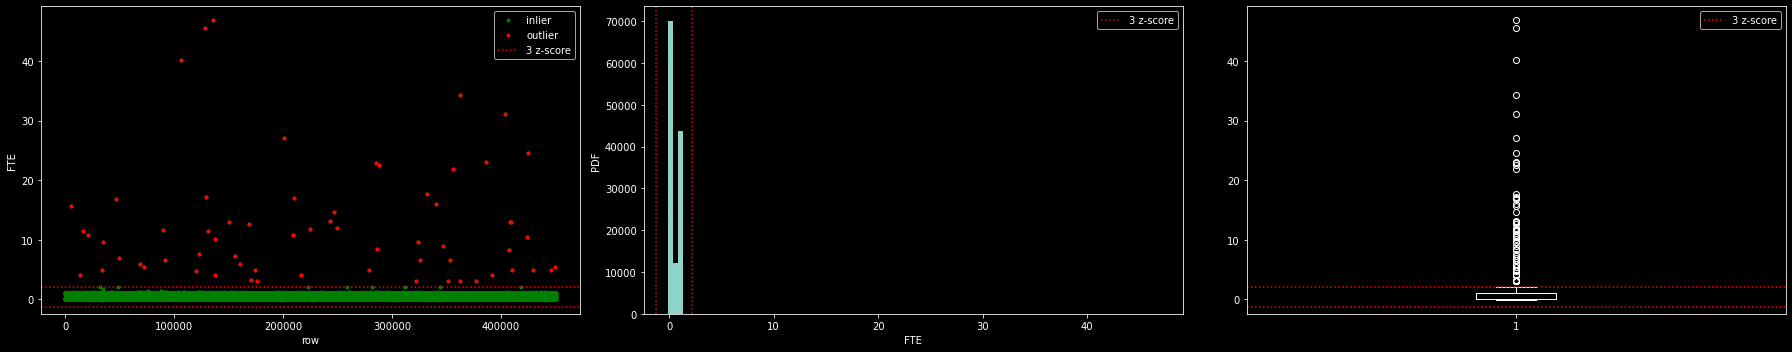

Upper outliers: 64
Lower outliers: 0


In [23]:
fte = df.FTE.dropna()
density_plots(fte, 'FTE', bins=100)
zscores = zscore(fte)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

`FTE` ouliers hold values from `3` o `46.8`, assumed as multiple headcount.  Those values seem reasonable for the `Total` and description columns that follow:

In [24]:
relevant = ['FTE', 'Total', 'Fund_Description', 'Object_Description', 'Job_Title_Description']
df.loc[fte[(zscores < -3) | (zscores > 3)].index.values, relevant].sort_values('FTE', ascending=False)

,FTE,Total,Fund_Description,Object_Description,Job_Title_Description
135371,46.8,528191.986943,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
128399,45.6,478476.893739,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
105857,40.2,580900.061569,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
362251,34.2,484744.886261,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
404264,31.1,352252.935596,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
...,...,...,...,...,...
362443,3.0,280332.905298,General,Regular *,"TCHR, OCC THERAPIST"
377132,3.0,149857.502317,General,Regular *,EDUCATIONAL AIDE I
351528,3.0,162472.656884,General,Regular *,MOBILE DEPUTY
176122,3.0,130486.445186,General,Regular *,PARA (MF)


What if to remove upper outliers?

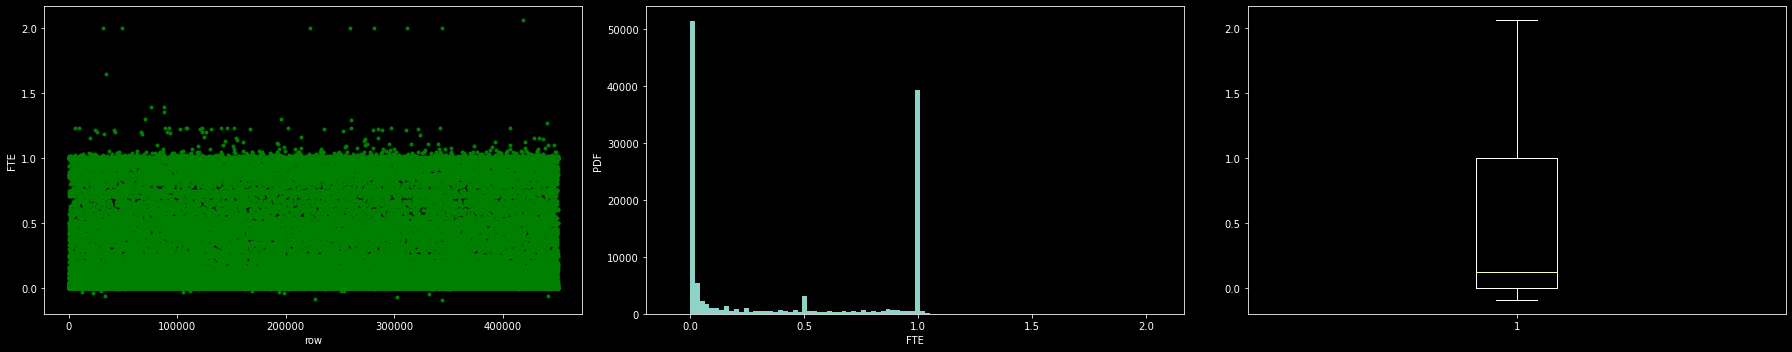

In [25]:
fte_no_outliers = fte[zscores <= 3]
density_plots(fte_no_outliers, 'FTE', outlying=False, bins=100)

### `Total` univariate analysis

`Total` contains upper and lower outliers with magnitude or +/- 100 millions.

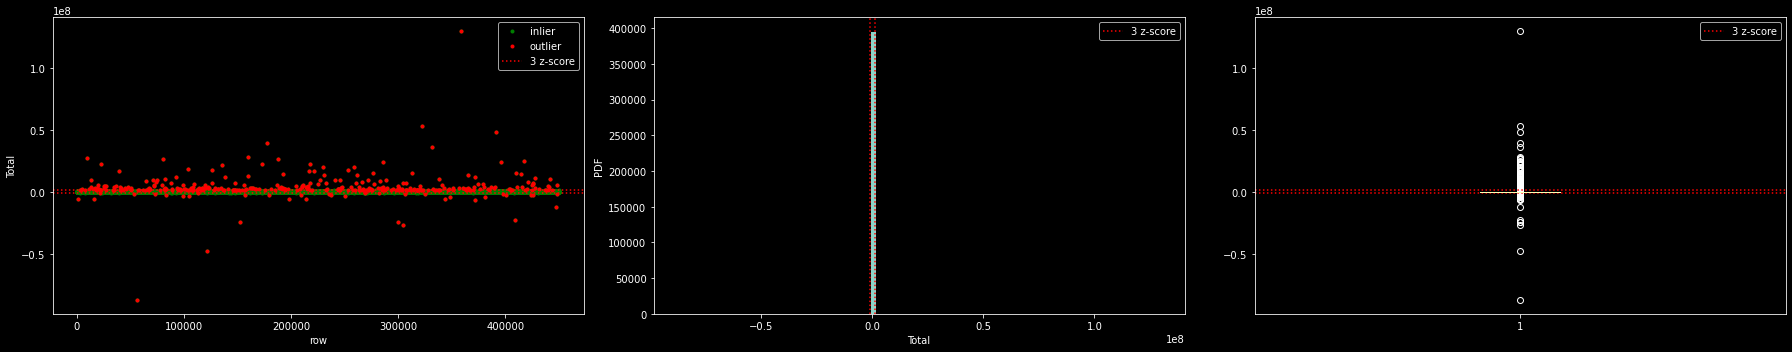

Upper outliers: 317
Lower outliers: 37


In [26]:
total = df.Total.dropna()
density_plots(total, 'Total', bins=100)
zscores = zscore(total)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

`Total` outliers are associated with null `FTE`, i.e., they are not related to headcount but to facilities, buildings, insurances, etc.

In [27]:
relevant = ['Total', 'FTE', 'Fund_Description', 'Object_Description', 'Job_Title_Description']
df.loc[total[(zscores < -3) | (zscores > 3)].index, relevant].sort_values('Total', ascending=False)

,Total,FTE,Fund_Description,Object_Description,Job_Title_Description
358538,1.297000e+08,NaN,General,Payments to a Community School*,NaN
322149,5.323797e+07,NaN,Employee Benefits Self-Insurance,Other Purchased Services,NaN
390959,4.789057e+07,NaN,NaN,PAYMENTS TO ESCROW AGENTS,(blank)
177775,3.956446e+07,NaN,NaN,INTEREST ON LEASES,(blank)
331752,3.645094e+07,NaN,NaN,BUILDINGS,(blank)
...,...,...,...,...,...
152005,-2.399966e+07,NaN,General Fund,OPERATING TRANSFERS TO OTHER FUNDS,NaN
299589,-2.400000e+07,NaN,Capital Projects Fund,OPERATING TRANSFERS TO OTHER FUNDS,NaN
304649,-2.646500e+07,NaN,NaN,REDEMPTION OF PRINCIPAL,(blank)
121092,-4.789057e+07,NaN,NaN,PAYMENTS TO ESCROW AGENTS,(blank)


What if to remove all outliers?

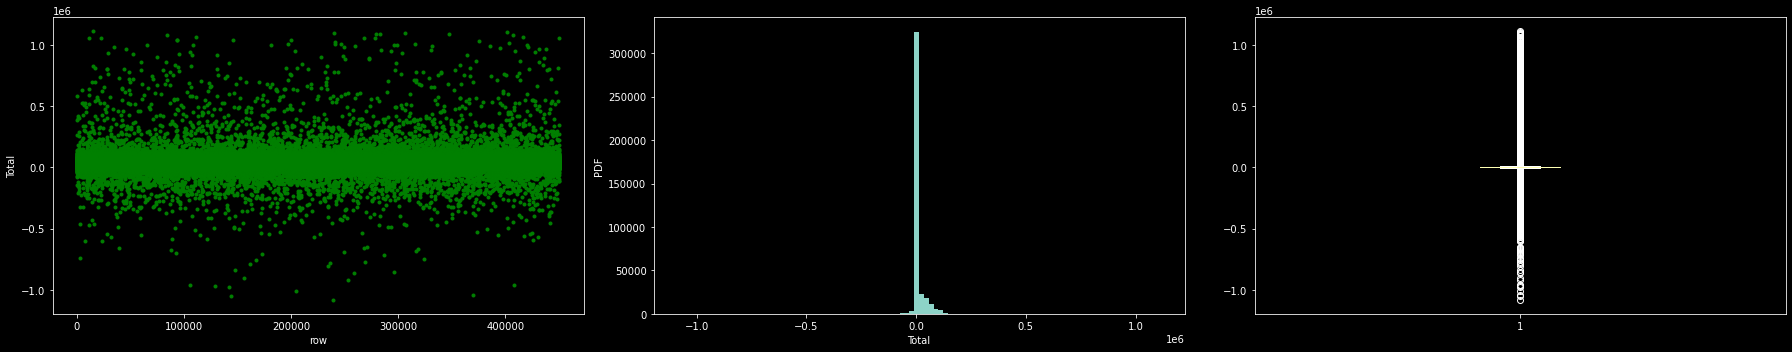

In [28]:
total_no_outliers = total[(zscores >= -3) & (zscores <= 3)]
density_plots(total_no_outliers, 'Total', outlying=False, bins=100)

Under the hyphotesis that negative values are sign mistakes, what if to fix them by flipping their signs? **It would move most of the lower outliers to be upper outliers.**

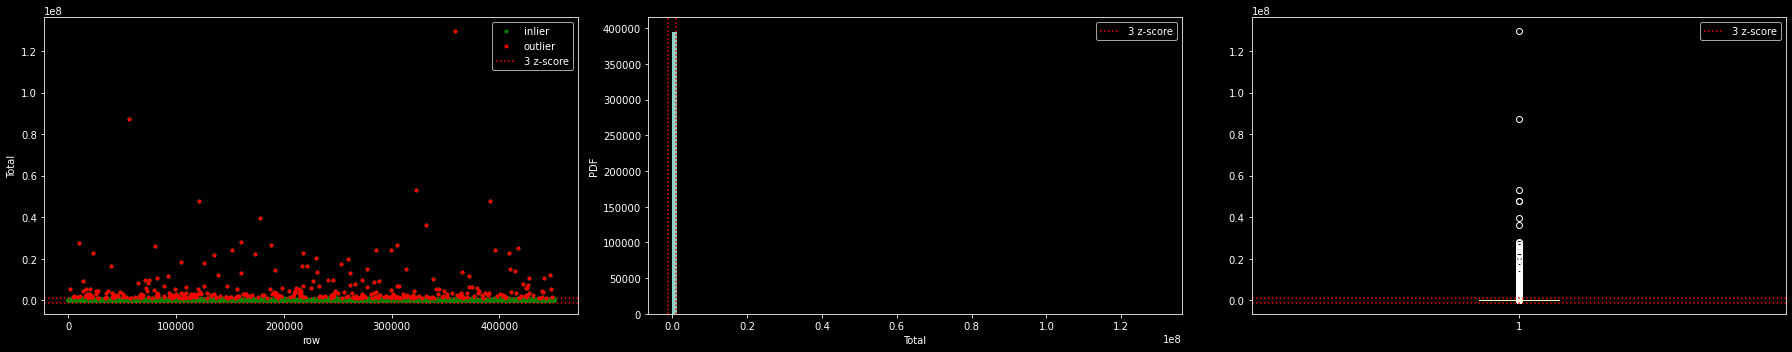

Upper outliers: 352
Lower outliers: 0


In [29]:
total_fixed = total.abs()
density_plots(total_fixed, 'Total', bins=100)
zscores_fixed = zscore(total_fixed)
print('Upper outliers:', sum(zscores_fixed > 3))
print('Lower outliers:', sum(zscores_fixed < -3))

### Bivariate analysis

#### Linear regression/correlation by imputation strategy

In [30]:
# dropna_df = df[NUMERIC_FEATURES].dropna()
# zero_imputed_df = df[NUMERIC_FEATURES].fillna(0)
# mean_imputed_df = df[NUMERIC_FEATURES].fillna(df[NUMERIC_FEATURES].mean())
# median_imputed_df = df[NUMERIC_FEATURES].fillna(df[NUMERIC_FEATURES].median())

# plt.figure(figsize=(25,14))
# plt.subplot(2,2,1)
# sns.regplot(x='FTE', y='Total', data=dropna_df)
# plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(dropna_df.FTE, dropna_df.Total)[0,1]), (20,2000000))
# plt.title('Drop missing')
# plt.subplot(2,2,2)
# sns.regplot(x='FTE', y='Total', data=zero_imputed_df)
# plt.title('Zero imputed')
# plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(zero_imputed_df.FTE, zero_imputed_df.Total)[0,1]), (20,10000000))
# plt.subplot(2,2,3)
# sns.regplot(x='FTE', y='Total', data=mean_imputed_df)
# plt.title('Mean imputed')
# plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(mean_imputed_df.FTE, mean_imputed_df.Total)[0,1]), (20,10000000))
# plt.subplot(2,2,4)
# sns.regplot(x='FTE', y='Total', data=mean_imputed_df)
# plt.title('Median imputed')
# plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(median_imputed_df.FTE, median_imputed_df.Total)[0,1]), (20,10000000))
# plt.tight_layout()
# plt.show()

#### Correlations grouped by labels, before and after zero imputation

In [31]:
def grouped_corr_plot(by):
    grouped_corr = df[[by, 'FTE', 'Total']].groupby(by).corr().unstack().iloc[:,2].to_frame('raw')
    grouped_corr['zero imputed'] = df[[by, 'FTE', 'Total']].fillna(0).groupby(by).corr().unstack().iloc[:,2].rename('imputed corr')
    grouped_corr['mean imputed'] = df[[by, 'FTE', 'Total']].fillna(df[NUMERIC_FEATURES].mean()).groupby(by).corr().unstack().iloc[:,2].rename('imputed corr')
    grouped_corr['median imputed'] = df[[by, 'FTE', 'Total']].fillna(df[NUMERIC_FEATURES].median()).groupby(by).corr().unstack().iloc[:,2].rename('imputed corr')

    grouped_corr.sort_values('raw', ascending=False).plot(kind='barh', figsize=(15,13))
    plt.title(f'FTE and Total correlation grouped by {by}')
    plt.xlabel('Correlation')
    plt.grid(axis='x')
    plt.show()

In [32]:
# for x in LABELS:
#     grouped_corr_plot(x)

#### Numeric totals grouped by labels

In [33]:
# for label in LABELS:
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

#     fte = df.groupby(label).FTE.sum()
#     #fte.plot(kind='bar')
#     axes[0].barh(fte.index, fte)
#     axes[0].set_title('Full Time Equivalent per ' + label)
#     axes[0].set_xlabel('Headcount')

#     total = df.groupby(label).Total.sum()
#     #total.plot(kind='bar', color='green')
#     axes[1].barh(total.index, total, color='green')
#     axes[1].set_title('Total cost of the expenditure per ' + label)
#     axes[1].set_xlabel('Cost')
#     # axes[1].set_yticks([])
#     plt.tight_layout()
#     plt.show()

## Free text form variables

The `cross_value_counts()` function includes missing counts.

In [34]:
def cross_value_counts(df):
    #cvc = df.replace('(\s+|[^\w+])',' ',regex=True)#.apply(lambda x: x.str.strip())
    cvc = df.replace('[^\w]+',' ',regex=True).apply(lambda x: x.str.strip().str.upper())
    cvc = cvc.apply(lambda x: x.value_counts(dropna=False)).fillna(0)
    cvc = cvc.apply(pd.to_numeric, downcast='unsigned')
    cvc.index.name = 'text'
    cvc.columns.name = 'columns'
    cvc.index = cvc.index.fillna('NaN')
    # sorting value couns by rows than by columns
    decreasing_row_index = cvc.sum(axis=1).sort_values(ascending=False).index
    decreasing_col_index = cvc.loc[cvc.index!='NaN'].sum(axis=0).sort_values(ascending=False).index
    return cvc.loc[decreasing_row_index, decreasing_col_index]

def cross_value_counts_summary(df):

    percent_with_nan = lambda x: x.sum() / (df.shape[0] * df.shape[1]) * 100
    cvc = cross_value_counts(df).replace(0, np.nan)
    cvcs = cvc.agg(['sum', 'count', percent_with_nan], axis='columns')
    cvcs.index.name = 'text'
    cvcs.columns=['Ocurrences', 'Columns', '% w/NaN']

    saved = cvcs.loc['NaN','Ocurrences']
    cvcs.loc['NaN','Ocurrences'] = np.nan
    cvcs['% wo/NaN'] = (cvcs.Ocurrences / cvcs.Ocurrences.sum() * 100)#.fillna(0)
    cvcs['Cumulated % wo/NaN'] = cvcs['% wo/NaN'].cumsum()
    cvcs.loc['NaN','Ocurrences'] = saved
    cvcs['words'] = cvcs.index.str.split().map(len).tolist()
    cvcs.loc['NaN','words'] = np.nan

    cvcs = cvcs.apply(pd.to_numeric, downcast='float')
    cvcs = cvcs.apply(pd.to_numeric, downcast='unsigned')

    return cvcs

### Text features frequencies

In [35]:
cross_value_counts(df[TEXT_FEATURES])

columns,Object_Description,Function_Description,SubFund_Description,Program_Description,Job_Title_Description,Text_1,Position_Extra,Fund_Description,Location_Description,Text_3,Sub_Object_Description,Text_2,Facility_or_Department,Text_4
text,,,,,,,,,,,,,,
NaN,24784,58082,93422,95617,107534,107992,135513,197400,238223,291125,308674,312060,346391,346531
GENERAL FUND,0,0,123327,0,0,0,0,57212,0,0,0,0,0,0
EMPLOYEE BENEFITS,47495,54,0,32669,0,32669,0,0,83,0,0,54,0,0
REGULAR,9270,0,0,0,0,0,0,0,0,94462,0,0,0,0
PROFESSIONAL INSTRUCTIONAL,0,0,0,0,0,0,92136,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEACHER TECHNOLOGY,0,0,0,0,1,0,0,0,0,0,0,0,0,0
TUTOR TEMPORARY,0,0,0,0,1,0,0,0,0,0,0,0,0,0
ED PROG SPECIALIST,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Text features frequency summary

In [36]:
df_cvcs = cross_value_counts_summary(df[TEXT_FEATURES])
df_cvcs

,Ocurrences,Columns,% w/NaN,% wo/NaN,Cumulated % wo/NaN,words
text,,,,,,
NaN,2663348,14,47.526875,NaN,NaN,NaN
GENERAL FUND,180539,2,3.221680,6.139676,6.139676,2.0
EMPLOYEE BENEFITS,113024,6,2.016889,3.843661,9.983336,2.0
REGULAR,103732,2,1.851075,3.527663,13.511000,1.0
PROFESSIONAL INSTRUCTIONAL,92136,1,1.644147,3.133313,16.644312,2.0
...,...,...,...,...,...,...
TEACHER TECHNOLOGY,1,1,0.000018,0.000034,99.999863,2.0
TUTOR TEMPORARY,1,1,0.000018,0.000034,99.999901,2.0
ED PROG SPECIALIST,1,1,0.000018,0.000034,99.999931,3.0


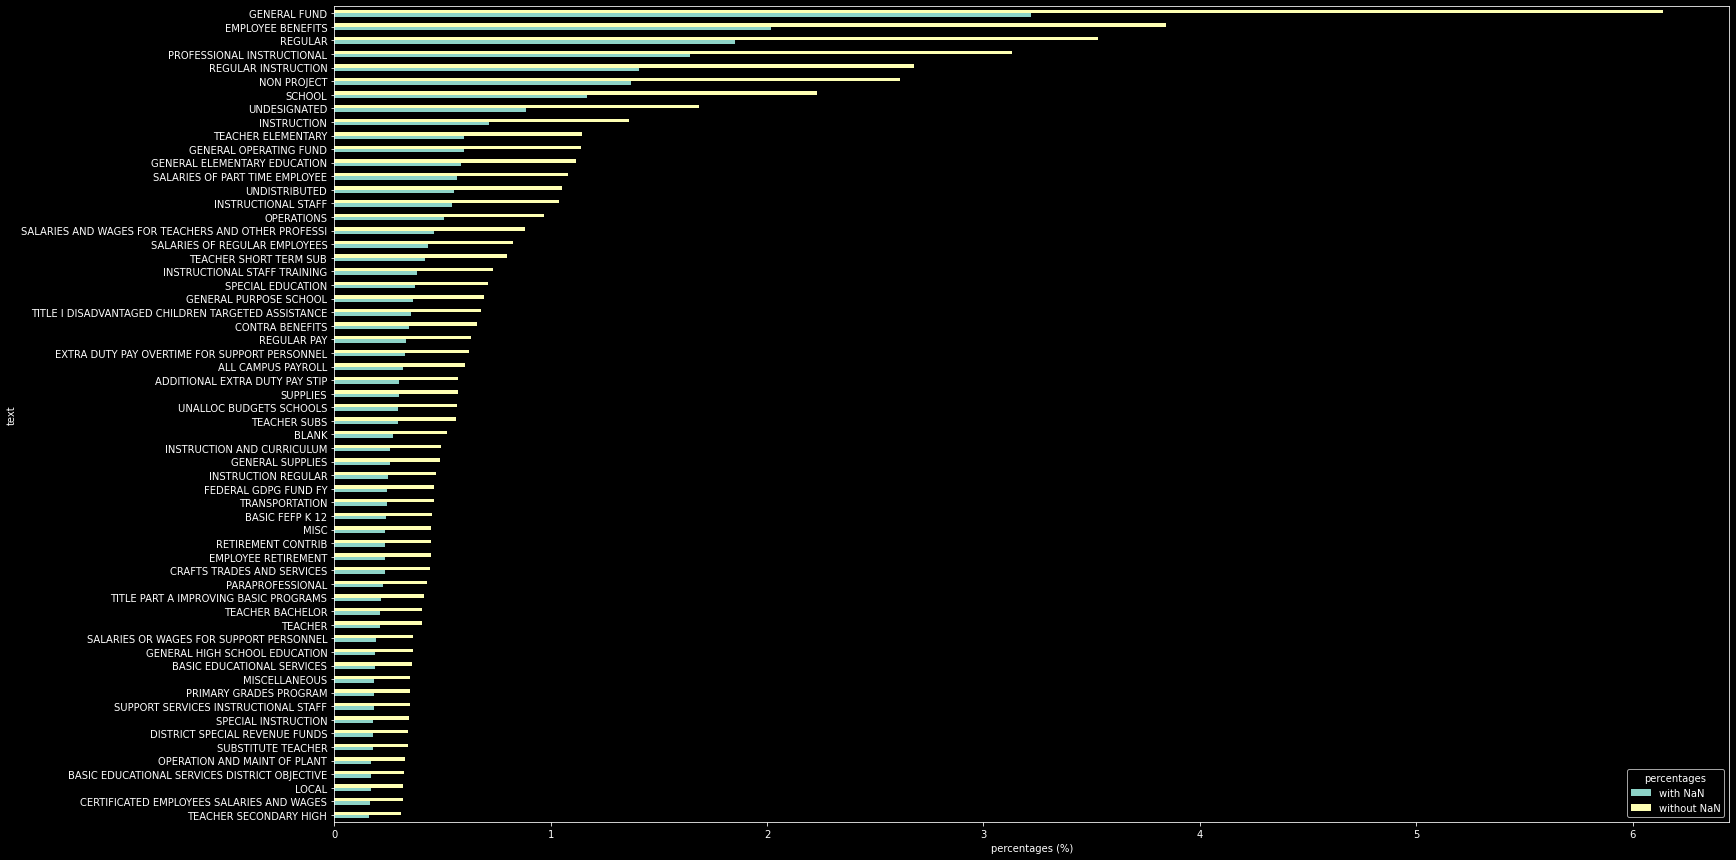

In [37]:
cvcs = pd.concat({'with NaN': df_cvcs['% w/NaN'].drop('NaN'),
                  'without NaN': df_cvcs['% wo/NaN'].drop('NaN')},
                 axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
cvcs.index.name='text'
cvcs.columns.name='percentages'
cvcs.tail(60).plot(kind='barh', stacked=False, figsize=(25, 15))
plt.xlabel('percentages (%)')
plt.show()

## Categorical variables

### Unique classes per label

In [38]:
num_unique_labels = df[LABELS].apply(pd.Series.nunique)
print(num_unique_labels)
print('            Total:',num_unique_labels.sum())

Function            37
Object_Type         11
Operating_Status     3
Position_Type       25
Pre_K                3
Reporting            3
Sharing              5
Student_Type         9
Use                  8
dtype: int64
            Total: 104


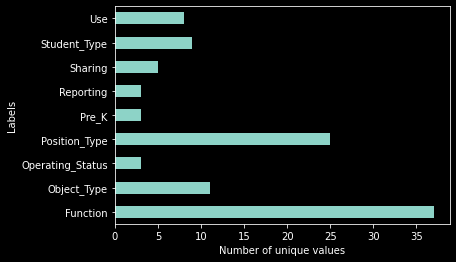

In [39]:
num_unique_labels.plot(kind='barh')
plt.xlabel('Number of unique values')
plt.ylabel('Labels')
plt.show()

### Encoding labels as categories to optimize memory and performance

In [40]:
#Converting label columns to category type
print('Memory before encoding: {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after encoding : {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))

Memory before encoding: 87.5 MB (556.6 MB deep)
Memory after encoding : 63.4 MB (321.0 MB deep)


### Observations per groups of labels

[Grouping by categoricals will show unused categories](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html?highlight=groupby%20sum#operations)

Those can avoided by using `observed=True`

In [41]:
# label_group = df.groupby(LABELS).size()[lambda x: x>0].sort_values().to_frame('observations')
label_group = df.groupby(LABELS, observed=True).size().sort_values(ascending=False).to_frame('observations')
label_group

observations
Function                               Object_Type                 Operating_Status  Position_Type Pre_K    Reporting  Sharing                 Student_Type      Use                                      
NO_LABEL                               NO_LABEL                    Non-Operating     NO_LABEL      NO_LABEL NO_LABEL   NO_LABEL                NO_LABEL          NO_LABEL                            48034
Teacher Compensation                   Benefits                    PreK-12 Operating Teacher       NO_LABEL School     School Reported         Unspecified       Instruction                         22169
Substitute Compensation                Base Salary/Compensation    PreK-12 Operating Substitute    NO_LABEL School     School Reported         Unspecified       Instruction                         16130
                                       Benefits                    PreK-12 Operating Substitute    NO_LABEL School     School Reported         Unspecified       Instruction                         14110
Teacher Compensation                   Base Salary/Compensation    PreK-12 Operating Teacher       NO_LABEL School     School Reported         Unspecified       Instruction                         13551
...                                                                                                                                                                                                    ...
Data Processing & Information Services Benefits                    PreK-12 Operating Teacher       Non PreK School     School Reported         Unspecified       Business Services                       1
Physical Health & Services             Equipment & Equipment Lease PreK-12 Operating Non-Position  NO_LABEL Non-School Leadership & Management Unspecified       Pupil Services & Enrichment             1
Professional Development               Other Non-Compensation      PreK-12 Operating NO_LABEL      Non PreK School     School Reported         Special Education ISPD                                    1
Security & Safety                      Other Non-Compensation      PreK-12 Operating Non-Position  NO_LABEL Non-School Shared Services         Unspecified       O&M                                     1
Social & Emotional                     Contracted Services         PreK-12 Operating Non-Position  NO_LABEL Non-School Shared Services         Special Education Pupil Services & Enrichment             1

[5489 rows x 1 columns]

### Groups of labels with less than 2 samples (unstratifiable)

In [42]:
label_group.loc[label_group.observations < 2,:]

,,,,,,,,,observations
Function,Object_Type,Operating_Status,Position_Type,Pre_K,Reporting,Sharing,Student_Type,Use,
Teacher Compensation,Benefits,PreK-12 Operating,Instructional Coach,NO_LABEL,School,School Reported,ELL,Instruction,1
Special Population Program Management & Support,Contracted Services,PreK-12 Operating,NO_LABEL,Non PreK,School,School Reported,At Risk,ISPD,1
Physical Health & Services,Base Salary/Compensation,PreK-12 Operating,Speech Therapist,NO_LABEL,School,School Reported,Unspecified,Pupil Services & Enrichment,1
Parent & Community Relations,Supplies/Materials,PreK-12 Operating,NO_LABEL,PreK,School,School Reported,Unspecified,Pupil Services & Enrichment,1
Instructional Materials & Supplies,Equipment & Equipment Lease,PreK-12 Operating,NO_LABEL,PreK,Non-School,School on Central Budgets,Poverty,Instruction,1
...,...,...,...,...,...,...,...,...,...
Data Processing & Information Services,Benefits,PreK-12 Operating,Teacher,Non PreK,School,School Reported,Unspecified,Business Services,1
Physical Health & Services,Equipment & Equipment Lease,PreK-12 Operating,Non-Position,NO_LABEL,Non-School,Leadership & Management,Unspecified,Pupil Services & Enrichment,1
Professional Development,Other Non-Compensation,PreK-12 Operating,NO_LABEL,Non PreK,School,School Reported,Special Education,ISPD,1


### Converting labels in dummy variables

Double underscore conventioned by the competition

In [43]:
# Converting labels in dummy variables
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
dummy_labels

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
134338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
206341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
326408,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
364634,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
47683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109283,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
102430,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
413949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
433672,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


### Class count

In [44]:
dummy_labels.sum().sort_values(ascending=False)

Operating_Status__PreK-12 Operating    343578
Pre_K__NO_LABEL                        306425
Reporting__School                      257258
Sharing__School Reported               254433
Student_Type__Unspecified              223026
                                        ...  
Function__Legal                           117
Position_Type__Nurse Aide                  95
Function__Development & Fundraising        93
Function__Insurance                        57
Function__Facilities Planning              29
Length: 104, dtype: int64

### Class proportions

In [45]:
dummy_labels.mean().sort_values(ascending=False)

Operating_Status__PreK-12 Operating    0.858351
Pre_K__NO_LABEL                        0.765532
Reporting__School                      0.642700
Sharing__School Reported               0.635642
Student_Type__Unspecified              0.557179
                                         ...   
Function__Legal                        0.000292
Position_Type__Nurse Aide              0.000237
Function__Development & Fundraising    0.000232
Function__Insurance                    0.000142
Function__Facilities Planning          0.000072
Length: 104, dtype: float64

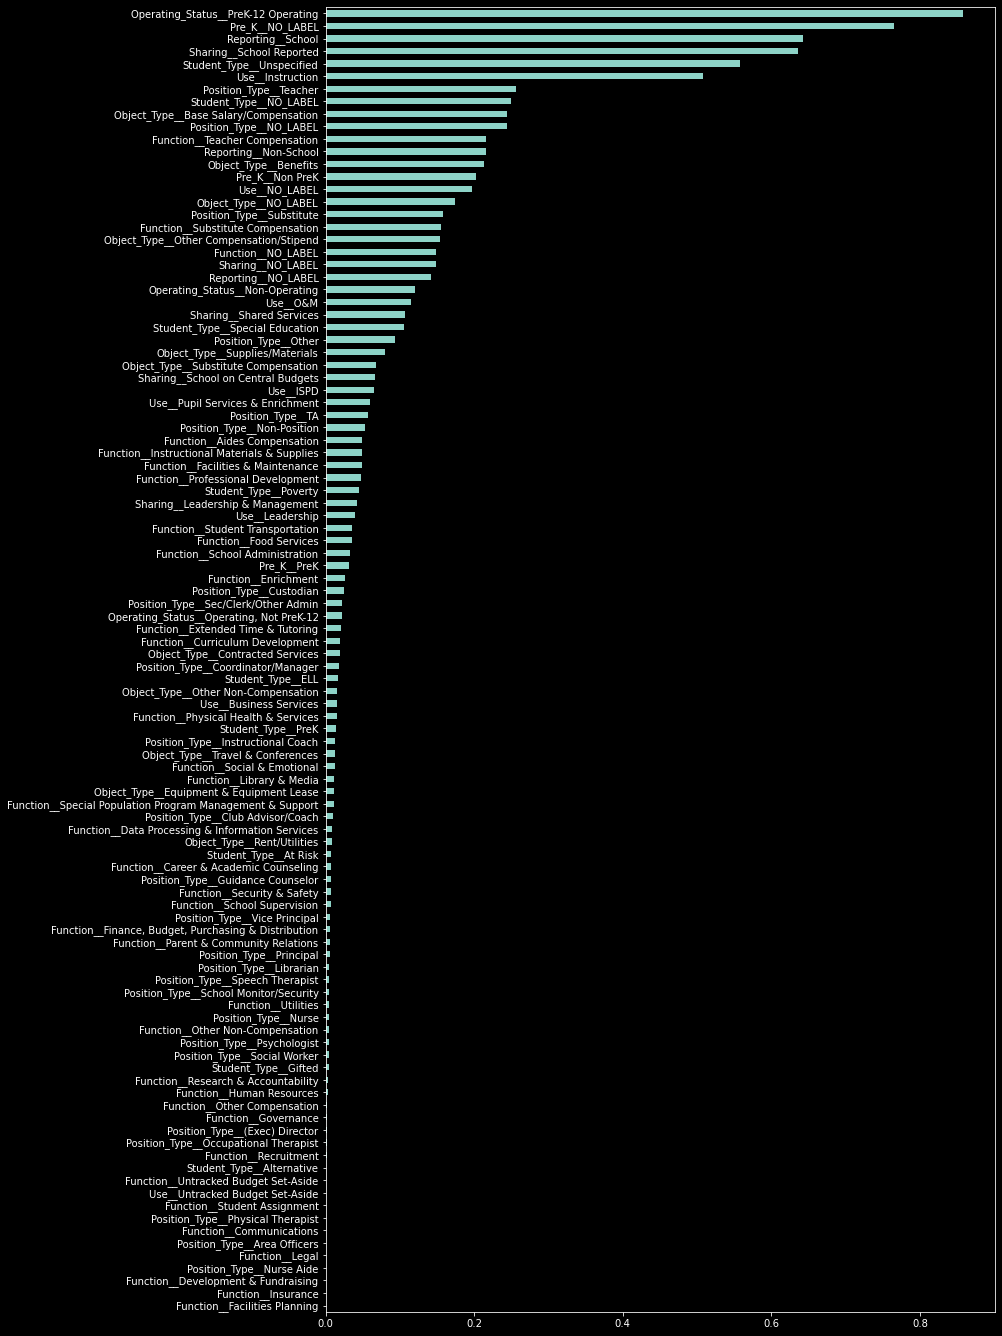

In [46]:
dummy_labels.mean().sort_values().plot(kind='barh', figsize=(12,24)); plt.show()

# Exploring holdout data

This holdout dataset has no labels due to the secrecy of the competition

In [47]:
holdout=pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)
glimpse(holdout)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50064 entries, 180042 to 249087
Columns: 16 entries, Object_Description to Text_1
dtypes: float64(2), object(14)
memory usage: 36.8 MB


,field,non-null count,missing ratio,data type,unique count,unique preview
0,FTE,19605,0.608401,float64,1529,"[-1.63666121113e-07, -1.91739847374e-07, 0.0, 0.0001, 0.000410302700818, ..., 5.0, 5.29075080564e-06, 6.0, 7.7, 88.14]"
1,Facility_or_Department,2839,0.943293,object,101,"[""(Year End Allocation To , ""Human Resources, Administration"", ""Technology Department, Administration"", ADULT EDUCATION, AIR CONDITIONING/REFRIGERATION, ..., Virtual School, Vocational, WAREHOUSE & GROUNDS , WRITING TEAMS , Warehousing]"
2,Function_Description,46866,0.063878,object,414,"[ CENTURY CLASSROON COLLABO, CNTRY COMMTY LRNG - , ELA SUMMER ACADEMY, INT OF SCL & MENTAL HLTH, SUCCESS, ..., WAL-MART GRANT, WELLNESS IN , WHIZ KIDS TUTORING, WORK STUDY , YOUTH SERVICES]"
3,Fund_Description,39586,0.209292,object,149,"[ Century Community Learning, Regional Collaboratives, ""Title Part A Improving Basic Programs"", ""Title Part C - Migrant"", A Foundation (effective , ..., Voc Ed- Basic Grant, Vocational Basic Ed., Vocational Education-Federal Funded, Vocational Education: Carl D. Perkins Vocational Education Act of , Workers Comp Self Insurance]"
4,Job_Title_Description,32317,0.354486,object,2190,"[ AD SOC SC, ART, ATHLETICS, AUXILIARY, Athletic Field Tech , ..., Warehouse Worker II , Youth Education Specialist , chief procurement officer, professional development spec, prog coord family care]"
5,Location_Description,37316,0.254634,object,382,"[ABD, ACADEMY, ACCOUNTING SERVICE OFFICE, ACCOUNTS PAYABLE, ADMIN. SERVICES, ..., Visual Arts, WAREHOUSE OPERATIONS, WELLNESS CENTER, Work Projects, Youth Commission]"
6,Object_Description,48330,0.034636,object,447,"[""Building Purchase, Construction Or Improvements"", ADDITIONAL INCOME ALLOWANCE, ADDITIONAL/EXTRA DUTY PAY/STIP, ADMINISTRATIVE PREMIUM, ADMINISTRATOR , ..., WHEN ACTUALLY EMPLOYED - WAE, WORKERS' COMPENSATION , WORKSHOP PARTICIPANT , Water and Sewage *, Water,Wastewater, Sanitation]"
7,Position_Extra,13813,0.724093,object,286,"[ CUSTODIAN, 1ST GRADE , 1ST GRADE , 2ND GRADE , 3RD GRADE , ..., TRUCK DRIVER AT CEN REC , TUTORING, Travel Allotment, UNDESIGNATED, VOC. TEACHER DAYS]"
8,Program_Description,44811,0.104926,object,291,"[ Portable Renov-Nw ESE, ""Title I, Part A Schoolwide Activities Related To State Comp, ACADEMIC LITERACY NETWORK , ACADEMIC STUDENT ASSESSMENT, ACADEMY, ..., VOCATIONAL LABORATORY PROGRAM 9-12, Vocational Grant-Program Improvement., Vocational Construction Related Equipment - STATE BOND FUNDS, Vocational Industry Certification State, WAREHOUSE & DISTRIBUTION]"
9,SubFund_Description,16111,0.678192,object,161,"[ MILL LEVY, ""Title Part A Improving Basic Programs"", ""Title Part C - Migrant"", ""Title SIP"", ""Title School Improvement"", ..., UPPER EARLY INTERVENTION PROGRAM QBE, UPPER ELEMENTARY GRADES PROGRAM , VOCATIONAL LABORATORY PROGRAM 9-12, Vocational Instruction, YOUTH SERVICES CENTER]"


## Fixing training feature sequence

Because sklearn will train fixed column positions

In [48]:
display(list(zip(FEATURES, holdout.columns.values)))
all(FEATURES == holdout.columns.values)

[('Object_Description', 'Object_Description'),
 ('Text_2', 'Program_Description'),
 ('SubFund_Description', 'SubFund_Description'),
 ('Job_Title_Description', 'Job_Title_Description'),
 ('Text_3', 'Facility_or_Department'),
 ('Text_4', 'Sub_Object_Description'),
 ('Sub_Object_Description', 'Location_Description'),
 ('Location_Description', 'FTE'),
 ('FTE', 'Function_Description'),
 ('Function_Description', 'Position_Extra'),
 ('Facility_or_Department', 'Text_4'),
 ('Position_Extra', 'Total'),
 ('Total', 'Text_2'),
 ('Program_Description', 'Text_3'),
 ('Fund_Description', 'Fund_Description'),
 ('Text_1', 'Text_1')]

False

**Features of the training set must be aligned with features of the holdout set**

In [49]:
FEATURES = holdout.columns.values
TEXT_FEATURES = [text_feature for text_feature in FEATURES if text_feature not in NUMERIC_FEATURES]
all(df[FEATURES].columns.values == holdout.columns.values)

True

## Missing data

Overall count and proportion of missing holdout features compared to missing training features:

In [50]:
missing = df[FEATURES].isnull()
missing_holdout = holdout.isnull()
pd.DataFrame({'dataset':  ['training', 'holdout'],
              'missing':    [missing.sum().sum(), missing_holdout.sum().sum()],
              'proportion': [missing.sum().sum() / (missing.shape[0] * missing.shape[1]),
                             missing_holdout.sum().sum() / (holdout.shape[0] * holdout.shape[1])]}).set_index('dataset')

,missing,proportion
dataset,,
training,2942109,0.459386
holdout,387797,0.484127


**The proportion of missing data in the holdout set is much bigger.**

Comparing missing feature heatmaps.  The columns of both datasets are ordered by the features of the training set with less missing data first. The idea is to compare some sort of missing proportion clusters.

In [51]:
# freq_col_order = missing.sum().sort_values().index.to_list()
# plt.figure(figsize=(25,6))
# sns.heatmap(~missing.loc[: , # missing.sum(axis=1).sort_values().index.to_list(),
#     freq_col_order].sort_values(freq_col_order), cbar=False, xticklabels=False)
# plt.title('Training set')
# plt.figure(figsize=(25,6))
# sns.heatmap(~missing_holdout.loc[:, # missing_holdout.sum(axis=1).sort_values().index.to_list(),
#     freq_col_order].sort_values(freq_col_order), cbar=False)
# plt.title('Holdout set')
# plt.show()

Comparing the heatmaps became suspect that the holdout dataset is not just a fair random sample because it's missing data pattern differs a lot from the training dataset.

Some missing value areas are proportionally bigger in the holdout set, which is confirmed by the missing ratio which differs a lot.

In [52]:
(missing_report(holdout)['column proportion'] / missing_report(df[FEATURES])['column proportion']).sort_values(ascending=False)

SubFund_Description       2.905789
Text_1                    2.568016
Position_Extra            2.138819
Job_Title_Description     1.319515
Text_3                    1.216083
Text_2                    1.163785
Total                     1.158486
Text_4                    1.090171
Facility_or_Department    1.090035
FTE                       0.888124
Object_Description        0.559388
Function_Description      0.440222
Program_Description       0.439246
Location_Description      0.427852
Sub_Object_Description    0.426141
Fund_Description          0.424391
Name: column proportion, dtype: float64

## FTE

In [53]:
holdout.FTE.describe()

count    1.960500e+04
mean     1.349004e+00
std      8.468634e+01
min     -1.917398e-07
25%      5.000000e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.185724e+04
Name: FTE, dtype: float64

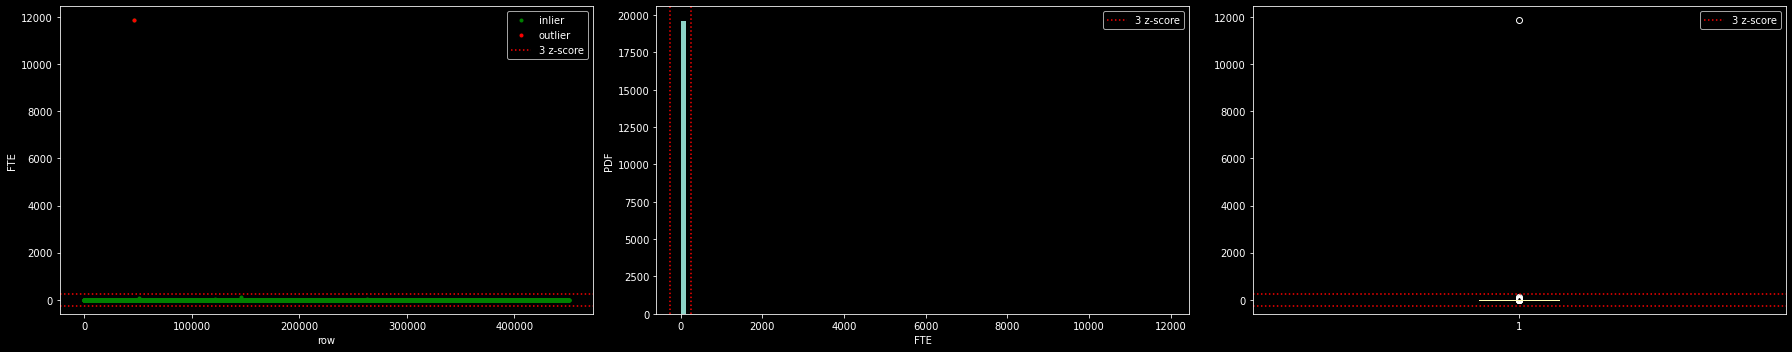

Upper outliers: 1
Lower outliers: 0


In [54]:
fte = holdout.FTE.dropna()
density_plots(fte, 'FTE', bins=100)
zscores = zscore(fte)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has only one `FTE` outlier with a value never seen so high in the whole training set: near `11857.24`, while the max `FTE` in training set is `46.8`.

This specific outlier has not textual data.

In [55]:
holdout[holdout.FTE == holdout.FTE.max()].transpose()

,46063
Object_Description,NaN
Program_Description,NaN
SubFund_Description,NaN
Job_Title_Description,NaN
Facility_or_Department,NaN
Sub_Object_Description,NaN
Location_Description,NaN
FTE,11857.24475
Function_Description,NaN
Position_Extra,NaN


Searching for holdout observations with no textual data:

In [56]:
holdout[holdout[TEXT_FEATURES].isnull().all(axis=1)]

,Object_Description,Program_Description,SubFund_Description,Job_Title_Description,Facility_or_Department,Sub_Object_Description,Location_Description,FTE,Function_Description,Position_Extra,Text_4,Total,Text_2,Text_3,Fund_Description,Text_1
46063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11857.24475,NaN,NaN,NaN,1.153578e+09,NaN,NaN,NaN,NaN
71261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.398000e+01,NaN,NaN,NaN,NaN
42179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.182400e+03,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.861900e+03,NaN,NaN,NaN,NaN
90738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.738370e+03,NaN,NaN,NaN,NaN
143636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.427740e+03,NaN,NaN,NaN,NaN
433295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.452000e+01,NaN,NaN,NaN,NaN


There are 116 other holdout observations without textual data.

Searching for training observations with no textual data:

In [57]:
df.loc[df[TEXT_FEATURES].isnull().all(axis=1), TEXT_FEATURES]

,Object_Description,Program_Description,SubFund_Description,Job_Title_Description,Facility_or_Department,Sub_Object_Description,Location_Description,Function_Description,Position_Extra,Text_4,Text_2,Text_3,Fund_Description,Text_1
99371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 1874 other training observations without textual data.

## Total

In [58]:
holdout.Total.describe()

count    4.940400e+04
mean     5.115880e+04
std      5.228060e+06
min     -2.370180e+06
25%      2.992925e+02
50%      2.743975e+03
75%      3.341465e+04
max      1.153578e+09
Name: Total, dtype: float64

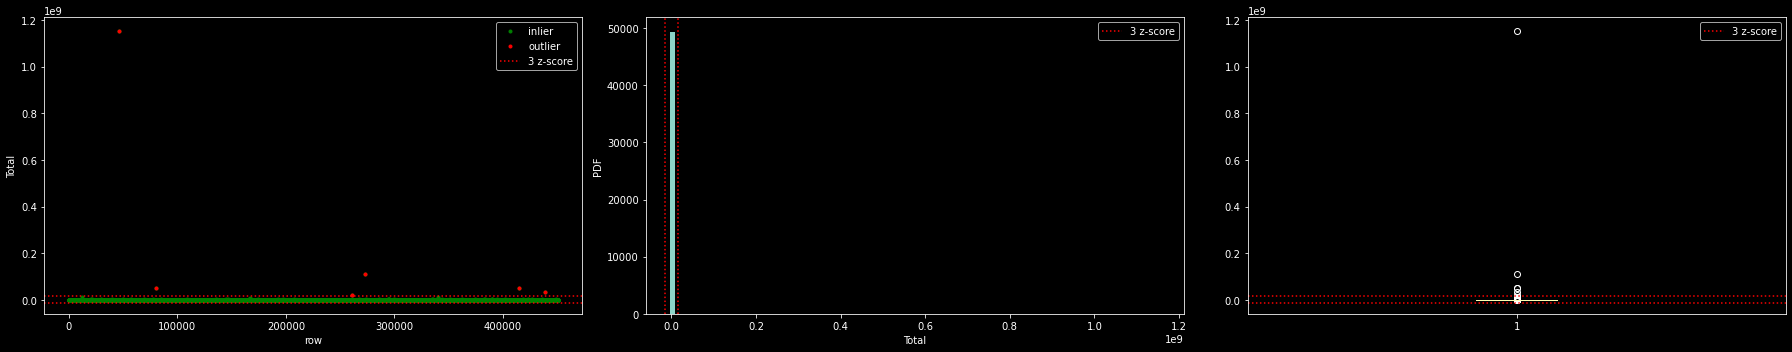

Upper outliers: 6
Lower outliers: 0


In [59]:
total = holdout.Total.dropna()
density_plots(total, 'Total', bins=100)
zscores = zscore(total)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has a huge Total outlier close to 1.2 billion while the max in training is 129 million and in fact, this `Total` outlier is the same as the `FTE` outlier.

This specific outlier has not textual data.

In [60]:
holdout[holdout.Total == holdout.Total.max()].transpose()

,46063
Object_Description,NaN
Program_Description,NaN
SubFund_Description,NaN
Job_Title_Description,NaN
Facility_or_Department,NaN
Sub_Object_Description,NaN
Location_Description,NaN
FTE,11857.24475
Function_Description,NaN
Position_Extra,NaN


## Free text form variables

### Text features frequencies

In [61]:
cross_value_counts(holdout[TEXT_FEATURES])

columns,Object_Description,Function_Description,Program_Description,Fund_Description,Location_Description,Sub_Object_Description,Job_Title_Description,SubFund_Description,Text_1,Position_Extra,Text_3,Text_2,Facility_or_Department,Text_4
text,,,,,,,,,,,,,,
NaN,1734,3198,5253,10478,12748,16452,17747,33953,34686,36251,44280,45423,47225,47250
GENERAL FUND,0,0,0,25151,0,0,0,6525,0,0,0,0,0,0
SCHOOL,0,0,0,0,25531,0,0,0,0,0,0,0,0,0
GENERAL,1,0,0,413,0,19704,0,0,0,0,0,0,0,0
INSTRUCTION,0,15655,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PARAPROFESSIONAL TEACHER AIDE,0,0,0,0,0,0,1,0,0,0,0,0,0,0
TEACHER SPEECH SELF CONTAINED I,0,0,0,0,0,0,1,0,0,0,0,0,0,0
MANAGER ASSESSMENT DEVELOPMENT,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Text features frequency summary

In [62]:
holdout_cvcs = cross_value_counts_summary(holdout[TEXT_FEATURES])
holdout_cvcs

,Ocurrences,Columns,% w/NaN,% wo/NaN,Cumulated % wo/NaN,words
text,,,,,,
NaN,356678,14,50.888863,NaN,NaN,NaN
GENERAL FUND,31676,2,4.519358,9.202308,9.202308,2.0
SCHOOL,25531,1,3.642623,7.417102,16.619410,1.0
GENERAL,20118,3,2.870326,5.844552,22.463963,1.0
INSTRUCTION,15655,1,2.233570,4.547990,27.011951,1.0
...,...,...,...,...,...,...
PARAPROFESSIONAL TEACHER AIDE,1,1,0.000143,0.000291,99.998840,3.0
TEACHER SPEECH SELF CONTAINED I,1,1,0.000143,0.000291,99.999130,5.0
MANAGER ASSESSMENT DEVELOPMENT,1,1,0.000143,0.000291,99.999420,3.0


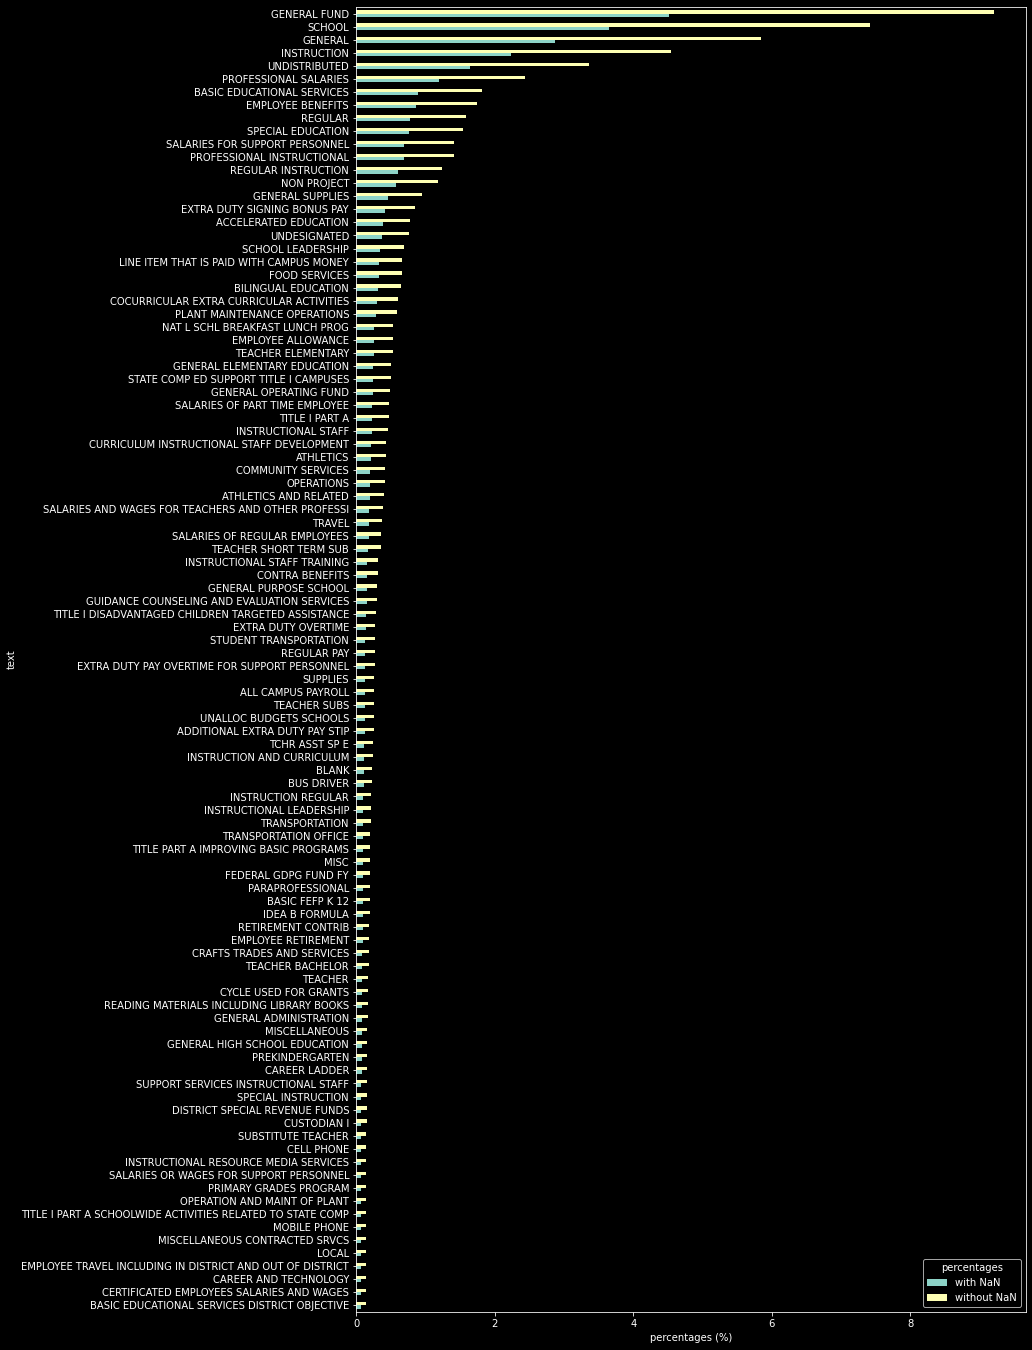

In [63]:
cvcs = pd.concat({'with NaN': holdout_cvcs['% w/NaN'].drop('NaN'),
                  'without NaN': holdout_cvcs['% wo/NaN'].drop('NaN')},
                 axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
cvcs.index.name='text'
cvcs.columns.name='percentages'

cvcs.tail(100).plot(kind='barh', stacked=False, figsize=(12, 24))
plt.xlabel('percentages (%)')
plt.show()

### Comparing training-holdout text frequency summaries

percentages,train,holdout
text,,
GENERAL FUND,6.139676,9.202308
EMPLOYEE BENEFITS,3.843661,1.747439
REGULAR,3.527663,1.592595
PROFESSIONAL INSTRUCTIONAL,3.133313,1.413349
REGULAR INSTRUCTION,2.679211,1.236135
...,...,...
WAN MANAGER,0.000000,0.000291
WEB MANAGER,0.000000,0.000291
WELDER,0.000000,0.000291


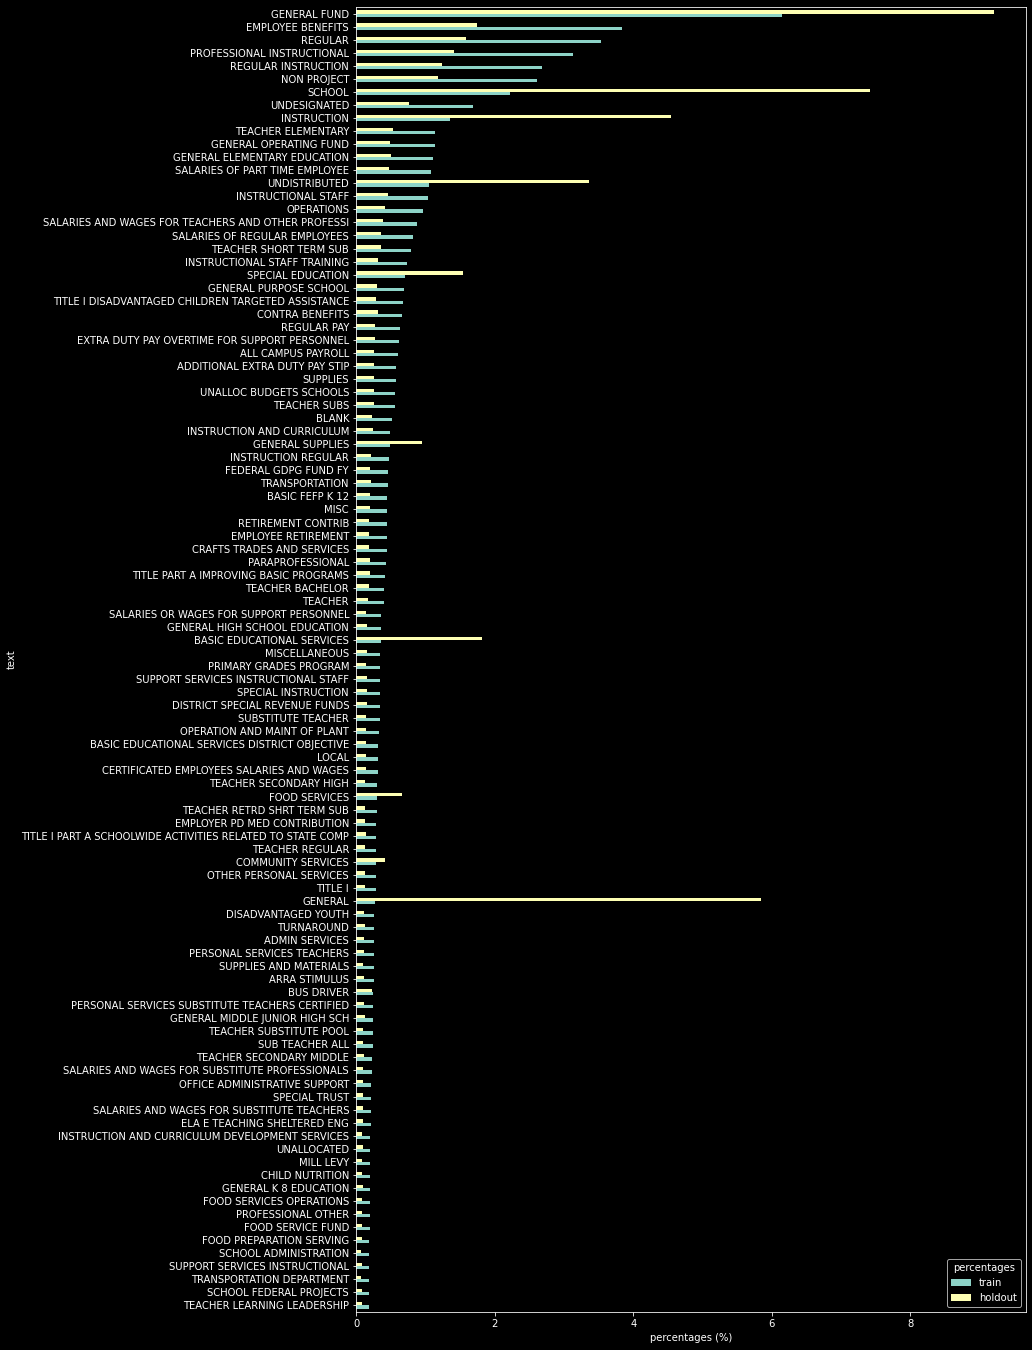

In [64]:
cvcs = pd.concat({'train': df_cvcs['% wo/NaN'],
                  'holdout': holdout_cvcs['% wo/NaN']},
                 axis=1, sort=True).fillna(0).sort_values(['train', 'holdout'], ascending=False)
cvcs.index.name='text'
cvcs.columns.name='percentages'
display(cvcs)
cvcs.sort_values(['train', 'holdout']).tail(100).plot(kind='barh', stacked=False, figsize=(12, 24))
plt.xlabel('percentages (%)')
plt.show()

# Imputation strategy

Text features will be combined, tokenized and counted in different n-gram ranges.

For numeric features:
* Generate binary indicators for missing `FTE` and `Total`
* Create a new numeric variable `Total_FTE` with default value `NaN`
* If `FTE` is not null and not zero, then `Total_FTE` = `Total` then `Total` = `NaN`
* Doesn't impute zero in remaining missing `FTE`, `Total`, and `Total_FTE`

In [65]:
from preprocessing.get_normalized_total import get_normalized_total

In [66]:
df[NUMERIC_FEATURES].info()
df[NUMERIC_FEATURES].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     126071 non-null  float64
 1   Total   395722 non-null  float64
dtypes: float64(2)
memory usage: 17.2 MB


,FTE,Total
134338,1.0,50471.810
206341,NaN,3477.860
326408,1.0,62237.130
364634,NaN,22.300
47683,NaN,54.166


In [67]:
get_normalized_total(df, 'FTE', 'Total').info()
get_normalized_total(df, 'FTE', 'Total').head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FTE            126071 non-null  float32
 1   Total          302248 non-null  float32
 2   FTE_missing    400277 non-null  uint8  
 3   Total_missing  400277 non-null  uint8  
 4   Total_FTE      93474 non-null   float32
dtypes: float32(3), uint8(2)
memory usage: 16.5 MB


,FTE,Total,FTE_missing,Total_missing,Total_FTE
134338,1.0,NaN,0,0,50471.808594
206341,NaN,3477.860107,1,0,NaN
326408,1.0,NaN,0,0,62237.128906
364634,NaN,22.299999,1,0,NaN
47683,NaN,54.166000,1,0,NaN


# The log loss

Log loss for binary classification
$$logloss = - \frac{1}{N}\sum^N_{i=1}{(y_i log(p_i) + (1-y_i)log(1-p_i))}$$

>Better to be less confident than confident and wrong

In [68]:
from metrics.log_loss import log_loss

Wrong and confident       : 34.538776394910684
Wrong and not confident   : 0.916290731874155
Correct and not confident : 0.5108256237659907
Correct and confident     : 9.992007221626415e-16


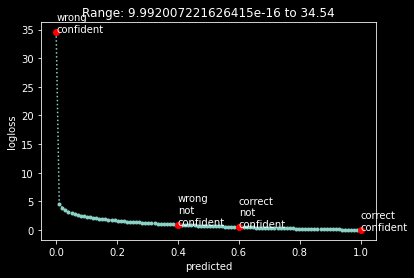

In [69]:
print('Wrong and confident       :', log_loss(actual =1, predicted=0))
print('Wrong and not confident   :', log_loss(actual=1, predicted=0.4))
print('Correct and not confident :', log_loss(actual=1, predicted=0.6))
print('Correct and confident     :', log_loss(actual=1, predicted=1))
predicts = np.linspace(0,1,100)
lloss = [log_loss(1,x) for x in predicts]
plt.plot(predicts, lloss, marker='.', linestyle='dotted')
points = [0, 0.4, 0.6, 1]
classes = ['wrong\nconfident', 'wrong\nnot\nconfident', 'correct\nnot\nconfident', 'correct\nconfident']
for i, x in enumerate(points):
    y=log_loss(actual=1, predicted=x)
    plt.plot(x, y, 'ro')
    plt.text(x, y, s=classes[i])
plt.title('Range: {0:} to {1:.2f}'.format(lloss[-1], lloss[0]))
plt.xlabel('predicted')
plt.ylabel('logloss')
plt.show()

 Log loss penalizes highly confident wrong answers much more than any other type. This is a good metric to use in this model and required by the competition.

# The multi-class multi-label log loss

In [70]:
from metrics.log_loss import multi_multi_log_loss
from dummies import get_dummies_indices
cci = get_dummies_indices(df[LABELS])

# Simple model: only numeric features

In [71]:
from model_selection.multilabel import multilabel_train_test_split

## Setting up a train-test split

* Selecting just numeric features: `df[NUMERIC_FEATURES]`

* Selecting labels as binary variables for multi-label targets: `dummy_labels`

In [72]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NUMERIC_FEATURES], dummy_labels, size=0.2, min_count=0, seed=1)

print("X_train info:")
print(X_train.info())
print("\nX_test info:")
print(X_test.info())
print("\ny_train info:")
print(y_train.info())
print("\ny_test info:")
print(y_test.info())

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     100992 non-null  float64
 1   Total   316574 non-null  float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 364634 to 375092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     25079 non-null  float64
 1   Total   79148 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 364634 to 375092
Columns: 104 entries, Funct

## Allways pre-process after splitting

In [73]:
from sklearn.preprocessing import maxabs_scale

# Numeric feature engineering
X_train = get_normalized_total(X_train, 'FTE', 'Total')

# Logistic regression requires non missing values
X_train = X_train.fillna(0)

# Preserve X_train dataframe type by storing maxabs_scale output in the dataframe
X_train[:] = maxabs_scale(X_train)

# Numeric feature engineering
X_test = get_normalized_total(X_test, 'FTE', 'Total')

# Logistic regression requires non missing values
X_test = X_test.fillna(0)

# Preserve X_train dataframe type by storing maxabs_scale output in the dataframe
X_test[:] = maxabs_scale(X_test)

## Training a model

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

In [75]:
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

In [76]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

Only intel GPU, no intelex: Last executed at 2022-08-10 19:23:48 in 18.93s  
Only intel GPU, with intelex: Last executed at 2022-08-10 19:26:19 in 19.19s

## Model metrics

In [77]:
print("Training Accuracy:", clf.score(X_train, y_train))

y_pred = clf.predict_proba(X_train)
print("Training Logloss:", multi_multi_log_loss(y_train, y_pred, class_column_indices=cci))

print("Testing Accuracy:", clf.score(X_test, y_test))

y_pred = clf.predict_proba(X_test)
print("Testing Logloss:", multi_multi_log_loss(y_test, y_pred, class_column_indices=cci))

y_pred = clf.predict(X_test)
print("Testing Classification Report:\n", classification_report(y_test, y_pred))

Training Accuracy: 0.04463153687129554
Training Logloss: 1.2916546625564866
Testing Accuracy: 0.04204609331084879
Testing Logloss: 1.2976415724076789
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3892
           1       0.00      0.00      0.00       604
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00      1472
           4       0.00      0.00      0.00       678
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00      2152
           7       0.00      0.00      0.00      1652
           8       0.00      0.00      0.00      3969
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00       470
          11       1.00      0.00      0.00      2831
          12       0.00      0.00      0.00       141
          13       0.00      0.00      0.00       240
       

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Only intel GPU, no intelex: Last executed at 2022-08-10 19:28:26 in 2.71s  
Only intel GPU, with intelex: Last executed at 2022-08-10 19:31:24 in 2.41s

## Use your model to predict values on holdout data

In [78]:
holdout = pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)

# holdout_numeric = holdout[NUMERIC_FEATURES]
holdout_numeric = get_normalized_total(holdout, 'FTE', 'Total')

# Logistic regression requires non missing values
holdout_numeric = holdout_numeric.fillna(0)

# Preserve holdout dataframe type by storing maxabs_scale output in the dataframe
holdout_numeric[:] = maxabs_scale(holdout_numeric)

predictions = clf.predict_proba(holdout_numeric)

Only intel GPU, no intelex: Last executed at 2022-08-10 19:28:26 in 159ms  
Only intel GPU, with intelex: Last executed at 2022-08-10 19:31:24 in 150ms

## Writing out your results to a zip for submission
At last, you're ready to submit some predictions for scoring. In this exercise, you'll write your predictions to a .csv using the .to_csv() method on a pandas DataFrame. Then you'll evaluate your performance according to the LogLoss metric discussed earlier!

You'll need to make sure your submission obeys the correct format.

To do this, you'll use your predictions values to create a new DataFrame, prediction_df.

Interpreting LogLoss & Beating the Benchmark:

When interpreting your log loss score, keep in mind that the score will change based on the number of samples tested. To get a sense of how this very basic model performs, compare your score to the DrivenData benchmark model performance: 2.0455, which merely submitted uniform probabilities for each class.

Remember, the lower the log loss the better. Is your model's log loss lower than 2.0455?

In [79]:
prediction_df = pd.DataFrame(columns=dummy_labels.columns,
                             index=holdout_numeric.index,
                             data=predictions)#.apply(lambda x: x.astype('category'), axis=0)
prediction_df.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.036536,0.006513,0.000880,0.024430,0.008810,0.000189,0.032018,0.024375,0.052467,0.000102,...,0.086929,0.519427,0.016240,0.073558,0.441159,0.038992,0.250572,0.115059,0.062636,0.001153
28872,0.036536,0.006513,0.000880,0.024430,0.008810,0.000189,0.032018,0.024375,0.052467,0.000102,...,0.086930,0.519430,0.016240,0.073559,0.441163,0.038992,0.250568,0.115059,0.062636,0.001153
186915,0.088494,0.006064,0.000581,0.008633,0.004986,0.000431,0.021121,0.019747,0.038258,0.000135,...,0.146230,0.703230,0.010684,0.047727,0.691183,0.026220,0.059500,0.134092,0.048413,0.000320
412396,0.088481,0.006064,0.000581,0.008633,0.004986,0.000431,0.021117,0.019743,0.038258,0.000135,...,0.146229,0.703220,0.010685,0.047728,0.691187,0.026223,0.059501,0.134072,0.048415,0.000320
427740,0.088513,0.006063,0.000581,0.008634,0.004985,0.000431,0.021125,0.019752,0.038258,0.000135,...,0.146231,0.703242,0.010683,0.047726,0.691178,0.026216,0.059498,0.134118,0.048411,0.000320


In [80]:
prediction_df.to_csv('/data/drivendata/predictions/2022/0.8-scaled-engineered-numeric-features-logistic-regression-C1.csv')

On July, 2022:
Just 2 numeric features, zero imputed, without scaling: 1.3534
Just 2 numeric features, zero imputed, with maxabs scaling: 1.3994
Engineered 5 numeric features, zero imputed, without scaling: 1.3452
Engineered 5 numeric features, zero imputed, with maxabs scaler: 1.3993

On 30-6-2020:
Your score for this submission is 1.3252

# Improving your model: NLP

## Combining text features for tokenization

Here all text features are concatenated in each row.

Each row becomes a single document.

In [81]:
from preprocessing.combine_text_columns import combine_text_columns

In [82]:
text_vector = combine_text_columns(df, to_drop=NUMERIC_FEATURES + LABELS)
text_vector

134338                                                                                                                                                                                                                                                                                    Teacher-Elementary        KINDERGARTEN  KINDERGARTEN General Fund 
206341                                                                                                                                                                                            CONTRACTOR SERVICES BOND EXPENDITURES BUILDING FUND (blank) Regular    RGN  GOB  UNDESIGNATED BUILDING IMPROVEMENT SERVICES  BUILDING IMPROVEMENT SERVICES
326408                                                                                                                                                                                                                         Personal Services - Teachers   TCHER 2ND GRADE  Regular Instruction     TEACHER

In [83]:
print('Memory size {}:', size(sys.getsizeof(text_vector)))

Memory size {}: 97.1 MiB


## Bag-of-Words

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

Unigram (word) statistics:

<400277x3758 sparse matrix of type '<class 'numpy.int64'>'
	with 6441095 stored elements in Compressed Sparse Row format>

,00a,12,1st,2nd,3rd,4,4th,5,56,5th,...,yrbs,yrs,yth,z,zero,zeta,zone,zoo,zuni,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sparsity                           : 0.995718043089115
Max term frequency in a document   : 6
Max term frequency in all documents: 331001
Max words in a document            : 53
Mean words per document            : 19.8
Median words per document          : 19.0
Sparse matrix memory usage         : 75.2 MiB
Dense matrix memory equivalence    : 11.2 GiB
Non-zero probabilities:

,bin,count,proportion
0,1,5222873,0.810867
1,2,996854,0.154765
2,3,176893,0.027463
3,4,35572,0.005523
4,5,7678,0.001192
5,6,1225,0.000190


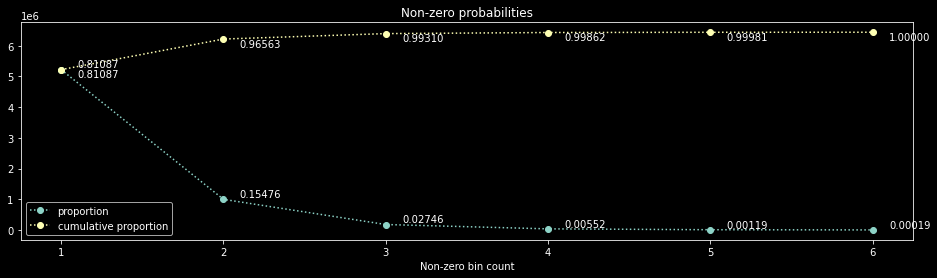

In [85]:
vec = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
tdm = vec.fit_transform(text_vector)
display(tdm)
display(pd.DataFrame(tdm.toarray(), columns=vec.get_feature_names_out()))

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max term frequency in a document   : {}'.format(tdm.max()))
print('Max term frequency in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max words in a document            : {}'.format(tdm.sum(axis=1).max()))
print('Mean words per document            : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median words per document          : {}'.format(np.median(np.array(tdm.sum(axis=1)))))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))
print('Non-zero probabilities:', end='')
nz_bin_count = [[bc, (tdm == bc).sum(), (tdm == bc).sum()/tdm.nnz] for bc in range(1, tdm.max() + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))
bc, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.figure(figsize=(16,4))
plt.plot(bc, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bc[i]+.1, count[i], '{:.5f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bc, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bc[i]+.1, cumcount[i], '{:.5f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

* **`81%` of the words appear only `1`  time in the rows of the `text_vector`**
* **`99%` of the words appear from `1` to `3` times in the rows of the `text_vector`**

## Tokenizing n-gram ranges

The `CountVectorizer` default `dtype` is `int64`.

As the maximum frequency of any token in a single observation is 6, the 8-bits unsigned integer `uint8` (0 to 255) could be enough to store counts of any ngram range.

Iterating over all possible n-gram ranges: `tdm.sum(axis=1).max()`

In [86]:
# tracemalloc.start()
# tracemalloc.reset_peak()
# msg = 'ngram:{},{} cols:{} maxtf:{} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
# for ngram_range in [(1,x) for x in range(1, 54)]: # 53 is the max number of words per document
#     t=time()
#     vec = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range = ngram_range, dtype='uint8')
#     tdm = vec.fit_transform(text_vector)
#     t=time()-t
#     current, peak = tracemalloc.get_traced_memory()
#     tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#     print(msg.format(ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(),
#                      tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes),
#                      size(current), size(peak), t))
# tracemalloc.stop()

**Saved results:**
```
Last executed at 2022-07-29 23:40:26 in 1h 33m 42s

ngram:1,1 cols:3758 maxtf:6 nnz:6441095 sparse:99.57% size:32.2 MiB cur:32.8 MiB peak:119.4 MiB 8s
ngram:1,2 cols:32908 maxtf:6 nnz:13481800 sparse:99.90% size:65.8 MiB cur:70.0 MiB peak:268.6 MiB 17s
ngram:1,3 cols:91874 maxtf:6 nnz:20386600 sparse:99.94% size:98.7 MiB cur:112.3 MiB peak:429.2 MiB 24s
ngram:1,4 cols:182143 maxtf:6 nnz:26978917 sparse:99.96% size:130.2 MiB cur:158.0 MiB peak:581.4 MiB 31s
ngram:1,5 cols:304760 maxtf:6 nnz:33221321 sparse:99.97% size:159.9 MiB cur:201.2 MiB peak:738.2 MiB 38s
ngram:1,6 cols:458373 maxtf:6 nnz:39110552 sparse:99.98% size:188.0 MiB cur:257.3 MiB peak:904.9 MiB 46s
ngram:1,7 cols:640164 maxtf:6 nnz:44637929 sparse:99.98% size:214.4 MiB cur:306.3 MiB peak:1.0 GiB 53s
ngram:1,8 cols:845320 maxtf:6 nnz:49792706 sparse:99.99% size:239.0 MiB cur:377.9 MiB peak:1.2 GiB 60s
ngram:1,9 cols:1069018 maxtf:6 nnz:54568192 sparse:99.99% size:261.7 MiB cur:431.7 MiB peak:1.4 GiB 67s
ngram:1,10 cols:1305383 maxtf:6 nnz:58961784 sparse:99.99% size:282.7 MiB cur:487.2 MiB peak:1.5 GiB 73s
ngram:1,11 cols:1547584 maxtf:6 nnz:62978609 sparse:99.99% size:301.8 MiB cur:583.5 MiB peak:1.7 GiB 79s
ngram:1,12 cols:1788904 maxtf:6 nnz:66629001 sparse:99.99% size:319.2 MiB cur:639.7 MiB peak:1.8 GiB 85s
ngram:1,13 cols:2024312 maxtf:6 nnz:69921781 sparse:99.99% size:334.9 MiB cur:695.0 MiB peak:1.9 GiB 89s
ngram:1,14 cols:2249854 maxtf:6 nnz:72870386 sparse:99.99% size:349.0 MiB cur:748.6 MiB peak:2.1 GiB 94s
ngram:1,15 cols:2462176 maxtf:6 nnz:75498805 sparse:99.99% size:361.5 MiB cur:800.0 MiB peak:2.2 GiB 99s
ngram:1,16 cols:2659062 maxtf:6 nnz:77834732 sparse:99.99% size:372.7 MiB cur:848.5 MiB peak:2.3 GiB 102s
ngram:1,17 cols:2838941 maxtf:6 nnz:79897975 sparse:99.99% size:382.5 MiB cur:973.9 MiB peak:2.5 GiB 105s
ngram:1,18 cols:3001492 maxtf:6 nnz:81709577 sparse:99.99% size:391.1 MiB cur:1015.7 MiB peak:2.5 GiB 108s
ngram:1,19 cols:3146699 maxtf:6 nnz:83287487 sparse:99.99% size:398.7 MiB cur:1.0 GiB peak:2.6 GiB 110s
ngram:1,20 cols:3275140 maxtf:6 nnz:84656810 sparse:99.99% size:405.2 MiB cur:1.1 GiB peak:2.7 GiB 112s
ngram:1,21 cols:3388033 maxtf:6 nnz:85842271 sparse:99.99% size:410.9 MiB cur:1.1 GiB peak:2.7 GiB 113s
ngram:1,22 cols:3486973 maxtf:6 nnz:86866620 sparse:99.99% size:415.7 MiB cur:1.1 GiB peak:2.8 GiB 115s
ngram:1,23 cols:3573821 maxtf:6 nnz:87757585 sparse:99.99% size:420.0 MiB cur:1.1 GiB peak:2.8 GiB 118s
ngram:1,24 cols:3650348 maxtf:6 nnz:88533659 sparse:99.99% size:423.7 MiB cur:1.2 GiB peak:2.9 GiB 120s
ngram:1,25 cols:3718058 maxtf:6 nnz:89210755 sparse:99.99% size:426.9 MiB cur:1.2 GiB peak:2.9 GiB 119s
ngram:1,26 cols:3778259 maxtf:6 nnz:89805530 sparse:99.99% size:429.8 MiB cur:1.2 GiB peak:2.9 GiB 120s
ngram:1,27 cols:3832141 maxtf:6 nnz:90329064 sparse:99.99% size:432.2 MiB cur:1.2 GiB peak:3.0 GiB 121s
ngram:1,28 cols:3880413 maxtf:6 nnz:90790327 sparse:99.99% size:434.4 MiB cur:1.2 GiB peak:3.0 GiB 125s
ngram:1,29 cols:3923677 maxtf:6 nnz:91198306 sparse:99.99% size:436.4 MiB cur:1.3 GiB peak:3.0 GiB 126s
ngram:1,30 cols:3962317 maxtf:6 nnz:91558238 sparse:99.99% size:438.1 MiB cur:1.3 GiB peak:3.1 GiB 126s
ngram:1,31 cols:3996676 maxtf:6 nnz:91872959 sparse:99.99% size:439.6 MiB cur:1.3 GiB peak:3.1 GiB 126s
ngram:1,32 cols:4027008 maxtf:6 nnz:92145428 sparse:99.99% size:440.9 MiB cur:1.3 GiB peak:3.1 GiB 125s
ngram:1,33 cols:4053541 maxtf:6 nnz:92378547 sparse:99.99% size:442.0 MiB cur:1.3 GiB peak:3.1 GiB 124s
ngram:1,34 cols:4076561 maxtf:6 nnz:92575471 sparse:99.99% size:443.0 MiB cur:1.3 GiB peak:3.1 GiB 124s
ngram:1,35 cols:4096382 maxtf:6 nnz:92738850 sparse:99.99% size:443.7 MiB cur:1.3 GiB peak:3.1 GiB 125s
ngram:1,36 cols:4113286 maxtf:6 nnz:92872763 sparse:99.99% size:444.4 MiB cur:1.3 GiB peak:3.1 GiB 126s
ngram:1,37 cols:4127526 maxtf:6 nnz:92980731 sparse:99.99% size:444.9 MiB cur:1.3 GiB peak:3.1 GiB 125s
ngram:1,38 cols:4139336 maxtf:6 nnz:93067380 sparse:99.99% size:445.3 MiB cur:1.3 GiB peak:3.2 GiB 125s
ngram:1,39 cols:4148980 maxtf:6 nnz:93135176 sparse:99.99% size:445.6 MiB cur:1.3 GiB peak:3.2 GiB 125s
ngram:1,40 cols:4156715 maxtf:6 nnz:93186999 sparse:99.99% size:445.9 MiB cur:1.3 GiB peak:3.2 GiB 125s
ngram:1,41 cols:4162801 maxtf:6 nnz:93226820 sparse:99.99% size:446.1 MiB cur:1.3 GiB peak:3.2 GiB 126s
ngram:1,42 cols:4167525 maxtf:6 nnz:93256572 sparse:99.99% size:446.2 MiB cur:1.3 GiB peak:3.2 GiB 126s
ngram:1,43 cols:4171132 maxtf:6 nnz:93278010 sparse:99.99% size:446.3 MiB cur:1.3 GiB peak:3.2 GiB 126s
ngram:1,44 cols:4173768 maxtf:6 nnz:93292843 sparse:99.99% size:446.4 MiB cur:1.3 GiB peak:3.2 GiB 127s
ngram:1,45 cols:4175647 maxtf:6 nnz:93302858 sparse:99.99% size:446.4 MiB cur:1.3 GiB peak:3.2 GiB 127s
ngram:1,46 cols:4176973 maxtf:6 nnz:93309478 sparse:99.99% size:446.5 MiB cur:1.3 GiB peak:3.2 GiB 126s
ngram:1,47 cols:4177907 maxtf:6 nnz:93313532 sparse:99.99% size:446.5 MiB cur:1.3 GiB peak:3.2 GiB 126s
ngram:1,48 cols:4178552 maxtf:6 nnz:93316145 sparse:99.99% size:446.5 MiB cur:1.3 GiB peak:3.2 GiB 127s
ngram:1,49 cols:4178971 maxtf:6 nnz:93317600 sparse:99.99% size:446.5 MiB cur:1.3 GiB peak:3.2 GiB 126s
ngram:1,50 cols:4179194 maxtf:6 nnz:93318321 sparse:99.99% size:446.5 MiB cur:1.3 GiB peak:3.2 GiB 127s
ngram:1,51 cols:4179286 maxtf:6 nnz:93318615 sparse:99.99% size:446.5 MiB cur:1.3 GiB peak:3.2 GiB 126s
ngram:1,52 cols:4179311 maxtf:6 nnz:93318648 sparse:99.99% size:446.5 MiB cur:1.3 GiB peak:3.2 GiB 126s
ngram:1,53 cols:4179317 maxtf:6 nnz:93318655 sparse:99.99% size:446.5 MiB cur:1.3 GiB peak:3.2 GiB 126s
```

## n-gram range frequency plot

In [87]:
# stop_words = CountVectorizer(stop_words='english').get_stop_words()
# top = 100
# for ngram_range in [(1,x) for x in range(1,4)]:
#     vec = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range=ngram_range, dtype='uint8')
#     tdm = vec.fit_transform(text_vector)
#     term_freq = pd.DataFrame({'term': vec.get_feature_names_out(),
#                               'proportion': tdm.mean(axis=0).tolist()[0],
#                               'frequency': tdm.sum(axis=0).tolist()[0],
#                               #'stop_word': [True if fn in stop_words else False for fn in vec.get_feature_names()]
#                               'stop_word': [True if any([True if word in stop_words else False for word in str.split(words)]) else False for words in vec.get_feature_names_out()]
#                              }).sort_values(['frequency','term'], ascending=(False, True)).head(top)
#     plt.figure(figsize=(16,15))
#     plt.grid()
#     ax = sns.barplot(x='frequency', y='term', data=term_freq, hue='stop_word', dodge=False)
#     patches = ax.patches
#     for i in range(len(patches)):
#         # x = patches[i].get_x() + patches[i].get_width()/2
#         # y = patches[i].get_height()+.05
#         y = patches[i].get_y() + patches[i].get_height()
#         x = patches[i].get_x() + patches[i].get_width()
#         ax.annotate('{:.2f}%'.format(term_freq['proportion'].iloc[i%top]*100), (x, y))#, ha='center')
#     plt.title('n-gram range {} frequency'.format(ngram_range))
#     plt.show()

## Hashing Trick

* Adding new features (e.g. 3-grams, 4-grams) may cause enormous increase in array size
* Hashing is a way of increasing memory efficiency
* Want to make array of features as small as possible: dimensionality Reduction
* Hash functions limits possible outputs, fixing array size
* Particularly useful on large datasets: e.g. lots of text data!

In [88]:
from sklearn.feature_extraction.text import HashingVectorizer

The parameters `norm=None`, `alternate_sign=False` and `binary=False` let us drop in the `HashingVectorizer()` as a replacement for `CounterVectorizer()`

[From sklearn docs](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-hashing):
> Since the hash function might cause collisions between (unrelated) features, a signed hash function is used and the sign of the hash value determines the sign of the value stored in the output matrix for a feature. This way, collisions are likely to cancel out rather than accumulate error, and the expected mean of any output feature’s value is zero. This mechanism is enabled by default with `alternate_sign=True` and is particularly useful for small hash table sizes (`n_features < 10000`). For large hash table sizes, it can be disabled, to allow the output to be passed to estimators like `sklearn.naive_bayes.MultinomialNB` or `sklearn.feature_selection.chi2` feature selectors that expect non-negative inputs.

Why is hashing a useful trick?

A hash function takes an input, in your case a token, and outputs a hash value. For example, the input may be a string and the hash value may be an integer.

A familiar python datatype, a dictionary, makes this mapping concept a bit more explicit. In fact, python dictionaries ARE hash tables!

`{'petro': 354, 'vend': 785, 'fuel': 895, 'and': 780, 'fluids': 354}`

By explicitly stating how many possible outputs the hashing function may have, we limit the size of the objects that need to be processed. With these limits known, computation can be made more efficient and we can get results faster, even on large datasets.

The default limit is `n_features=1048576` $(2^{20})$.  The number of features (columns) in the output matrices. Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

Some problems are memory-bound and not easily parallelizable, and hashing enforces a fixed length computation instead of using a mutable datatype (like a dictionary).  Enforcing a fixed length can speed up calculations drastically, especially on large datasets!

Tokenizing unigram (words)

<400277x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                                    : 0.9984653860024352
Max count of a hashed token in a document   : 6.0
Max count of a hashed token in all documents: 331001.0
Max unique hashed tokens per document       : 53.0
Mean unique hashed tokens per document      : 19.8
Median unique tokens per document           : 19.0
Sparse matrix memory usage                  : 75.2 MiB
Dense matrix memory equivalence             : 3.1 TiB
Non-zero probabilities:

,bin,count,proportion
0,1,5222873,0.810867
1,2,996854,0.154765
2,3,176893,0.027463
3,4,35572,0.005523
4,5,7678,0.001192
5,6,1225,0.000190


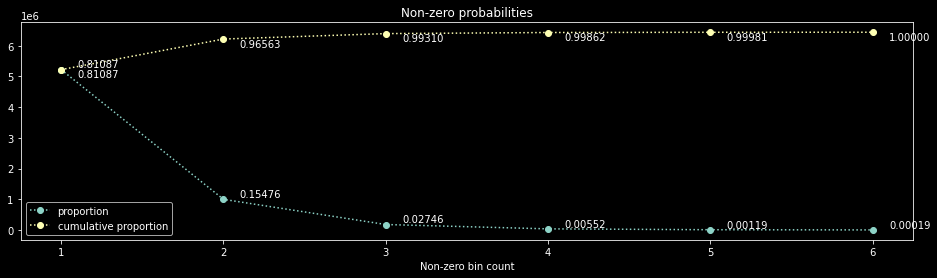

In [89]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',)
tdm = vec.fit_transform(text_vector)
display(tdm)
print('Sparsity                                    : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1]) * 100))
print('Max count of a hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document       : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document      : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document           : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                  :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence             :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))
print('Non-zero probabilities:', end='')
nz_bin_count = [[bc, (tdm == bc).sum(), (tdm == bc).sum()/tdm.nnz] for bc in range(1, int(tdm.max()) + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))
bc, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.figure(figsize=(16,4))
plt.plot(bc, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bc[i]+.1, count[i], '{:.5f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bc, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bc[i]+.1, cumcount[i], '{:.5f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

The maximum frequency of any hashed 1-gram token in a single observation is also 6 so the 8-bits unsigned integer `uint8` (0 to 255) also could be enough to store counts of any ngram range as long as there are sufficient `n_features`.

## Tokenizing hashed n-gram ranges

Iterating over `n_features` from the default $2^{20}$ to the maximum $2^{30}$ ([Murmurhash3 32-bit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)) and n-gram range from 1 to 3 in order to understand hashing collisions and memory usage.

In [90]:
# tracemalloc.start()
# tracemalloc.reset_peak()
# msg = 'features:2^{}={} ngram:{},{} cols:{} maxtf:{:.0f} maxtfall:{:.0f} hashcount:{} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
# for i in range(1, 31): # from 2^1 to 2^30 (Mumuhash3 32-bit)
#     for ngram_range in [(1,x) for x in range(1, 4)]:
#         t=time()
#         vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',
#                                 ngram_range=ngram_range, n_features=2**i, dtype='uint8')
#         tdm = vec.fit_transform(text_vector)
#         t=time()-t
#         current, peak = tracemalloc.get_traced_memory()
#         _, hash_counts = np.unique(tdm.data, return_counts=True)
#         tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#         print(msg.format(i, 2**i, ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(), tdm.sum(axis=0).max(),
#                          len(hash_counts),
#                          tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100,
#                          size(tdm_nbytes), size(current), size(peak), t))
#         #print(list(hash_counts/hash_counts.sum()),'\n')
# tracemalloc.stop()

**Saved results:**  
```
Last executed at 2022-Last executed at 2022-07-30 00:25:17 in 30m 42.39s

features:2^1=2 ngram:1,1 cols:2 maxtf:36 maxtfall:4338679 hashcount:35 nnz:794417 sparse:0.77% size:5.3 MiB cur:5.3 MiB peak:13.3 MiB 10s
features:2^1=2 ngram:1,2 cols:2 maxtf:61 maxtfall:8032029 hashcount:61 nnz:796765 sparse:0.47% size:5.3 MiB cur:5.3 MiB peak:29.3 MiB 20s
features:2^1=2 ngram:1,3 cols:2 maxtf:95 maxtfall:11526669 hashcount:95 nnz:796765 sparse:0.47% size:5.3 MiB cur:5.3 MiB peak:53.3 MiB 30s
features:2^2=4 ngram:1,1 cols:4 maxtf:26 maxtfall:2506417 hashcount:26 nnz:1550706 sparse:3.15% size:8.9 MiB cur:8.9 MiB peak:53.3 MiB 10s
features:2^2=4 ngram:1,2 cols:4 maxtf:38 maxtfall:4267491 hashcount:38 nnz:1587907 sparse:0.82% size:9.1 MiB cur:9.1 MiB peak:53.3 MiB 21s
features:2^2=4 ngram:1,3 cols:4 maxtf:60 maxtfall:5899403 hashcount:60 nnz:1592198 sparse:0.56% size:9.1 MiB cur:9.1 MiB peak:57.1 MiB 30s
features:2^3=8 ngram:1,1 cols:8 maxtf:18 maxtfall:1337494 hashcount:17 nnz:2723908 sparse:14.94% size:14.5 MiB cur:14.5 MiB peak:57.1 MiB 10s
features:2^3=8 ngram:1,2 cols:8 maxtf:23 maxtfall:2252639 hashcount:23 nnz:3102016 sparse:3.13% size:16.3 MiB cur:16.3 MiB peak:57.1 MiB 21s
features:2^3=8 ngram:1,3 cols:8 maxtf:36 maxtfall:3055562 hashcount:36 nnz:3158360 sparse:1.37% size:16.6 MiB cur:16.6 MiB peak:64.9 MiB 30s
features:2^4=16 ngram:1,1 cols:16 maxtf:15 maxtfall:1035080 hashcount:14 nnz:3980950 sparse:37.84% size:20.5 MiB cur:5.3 MiB peak:64.9 MiB 10s
features:2^4=16 ngram:1,2 cols:16 maxtf:19 maxtfall:1515789 hashcount:19 nnz:5378120 sparse:16.03% size:27.2 MiB cur:27.2 MiB peak:64.9 MiB 21s
features:2^4=16 ngram:1,3 cols:16 maxtf:23 maxtfall:1924580 hashcount:23 nnz:5855623 sparse:8.57% size:29.4 MiB cur:29.5 MiB peak:88.6 MiB 30s
features:2^5=32 ngram:1,1 cols:32 maxtf:11 maxtfall:633664 hashcount:11 nnz:5119712 sparse:60.03% size:25.9 MiB cur:9.5 MiB peak:88.6 MiB 10s
features:2^5=32 ngram:1,2 cols:32 maxtf:14 maxtfall:877991 hashcount:14 nnz:8050546 sparse:37.15% size:39.9 MiB cur:9.2 MiB peak:88.6 MiB 21s
features:2^5=32 ngram:1,3 cols:32 maxtf:17 maxtfall:1132996 hashcount:17 nnz:9687875 sparse:24.37% size:47.7 MiB cur:47.7 MiB peak:88.9 MiB 30s
features:2^6=64 ngram:1,1 cols:64 maxtf:8 maxtfall:418465 hashcount:8 nnz:5742145 sparse:77.59% size:28.9 MiB cur:9.5 MiB peak:124.7 MiB 10s
features:2^6=64 ngram:1,2 cols:64 maxtf:12 maxtfall:505308 hashcount:12 nnz:10306580 sparse:59.77% size:50.7 MiB cur:17.5 MiB peak:124.7 MiB 21s
features:2^6=64 ngram:1,3 cols:64 maxtf:13 maxtfall:653919 hashcount:13 nnz:13627175 sparse:46.81% size:66.5 MiB cur:14.5 MiB peak:124.7 MiB 30s
features:2^7=128 ngram:1,1 cols:128 maxtf:8 maxtfall:369544 hashcount:8 nnz:6090619 sparse:88.11% size:30.6 MiB cur:9.5 MiB peak:124.7 MiB 10s
features:2^7=128 ngram:1,2 cols:128 maxtf:11 maxtfall:415826 hashcount:11 nnz:11675951 sparse:77.21% size:57.2 MiB cur:17.5 MiB peak:124.7 MiB 21s
features:2^7=128 ngram:1,3 cols:128 maxtf:11 maxtfall:542005 hashcount:11 nnz:16397624 sparse:68.00% size:79.7 MiB cur:17.2 MiB peak:124.7 MiB 30s
features:2^8=256 ngram:1,1 cols:256 maxtf:7 maxtfall:352774 hashcount:7 nnz:6290694 sparse:93.86% size:31.5 MiB cur:9.5 MiB peak:145.3 MiB 10s
features:2^8=256 ngram:1,2 cols:256 maxtf:10 maxtfall:359379 hashcount:10 nnz:12626829 sparse:87.68% size:61.7 MiB cur:17.5 MiB peak:145.3 MiB 21s
features:2^8=256 ngram:1,3 cols:256 maxtf:10 maxtfall:449816 hashcount:10 nnz:18320430 sparse:82.12% size:88.9 MiB cur:33.5 MiB peak:145.3 MiB 30s
features:2^9=512 ngram:1,1 cols:512 maxtf:6 maxtfall:339288 hashcount:6 nnz:6372285 sparse:96.89% size:31.9 MiB cur:9.5 MiB peak:176.4 MiB 10s
features:2^9=512 ngram:1,2 cols:512 maxtf:9 maxtfall:342903 hashcount:9 nnz:12993323 sparse:93.66% size:63.5 MiB cur:17.5 MiB peak:176.4 MiB 21s
features:2^9=512 ngram:1,3 cols:512 maxtf:9 maxtfall:350771 hashcount:9 nnz:19271278 sparse:90.60% size:93.4 MiB cur:33.5 MiB peak:176.4 MiB 30s
features:2^10=1024 ngram:1,1 cols:1024 maxtf:6 maxtfall:331003 hashcount:6 nnz:6398305 sparse:98.44% size:32.0 MiB cur:9.5 MiB peak:183.6 MiB 10s
features:2^10=1024 ngram:1,2 cols:1024 maxtf:8 maxtfall:333175 hashcount:8 nnz:13237575 sparse:96.77% size:64.6 MiB cur:17.5 MiB peak:183.6 MiB 21s
features:2^10=1024 ngram:1,3 cols:1024 maxtf:9 maxtfall:336325 hashcount:9 nnz:19777004 sparse:95.17% size:95.8 MiB cur:33.5 MiB peak:183.6 MiB 30s
features:2^11=2048 ngram:1,1 cols:2048 maxtf:6 maxtfall:331001 hashcount:6 nnz:6425669 sparse:99.22% size:32.2 MiB cur:9.5 MiB peak:187.5 MiB 10s
features:2^11=2048 ngram:1,2 cols:2048 maxtf:8 maxtfall:331440 hashcount:8 nnz:13351526 sparse:98.37% size:65.2 MiB cur:17.5 MiB peak:187.5 MiB 21s
features:2^11=2048 ngram:1,3 cols:2048 maxtf:9 maxtfall:332361 hashcount:9 nnz:20114181 sparse:97.55% size:97.4 MiB cur:33.5 MiB peak:187.5 MiB 30s
features:2^12=4096 ngram:1,1 cols:4096 maxtf:6 maxtfall:331001 hashcount:6 nnz:6435911 sparse:99.61% size:32.2 MiB cur:9.5 MiB peak:190.1 MiB 10s
features:2^12=4096 ngram:1,2 cols:4096 maxtf:6 maxtfall:331102 hashcount:6 nnz:13439161 sparse:99.18% size:65.6 MiB cur:17.5 MiB peak:190.1 MiB 21s
features:2^12=4096 ngram:1,3 cols:4096 maxtf:6 maxtfall:331628 hashcount:6 nnz:20279936 sparse:98.76% size:98.2 MiB cur:33.5 MiB peak:190.1 MiB 30s
features:2^13=8192 ngram:1,1 cols:8192 maxtf:6 maxtfall:331001 hashcount:6 nnz:6437688 sparse:99.80% size:32.2 MiB cur:9.5 MiB peak:191.4 MiB 10s
features:2^13=8192 ngram:1,2 cols:8192 maxtf:6 maxtfall:331025 hashcount:6 nnz:13467133 sparse:99.59% size:65.7 MiB cur:17.5 MiB peak:191.4 MiB 21s
features:2^13=8192 ngram:1,3 cols:8192 maxtf:6 maxtfall:331294 hashcount:6 nnz:20340411 sparse:99.38% size:98.5 MiB cur:33.5 MiB peak:191.4 MiB 30s
features:2^14=16384 ngram:1,1 cols:16384 maxtf:6 maxtfall:331001 hashcount:6 nnz:6438804 sparse:99.90% size:32.2 MiB cur:9.5 MiB peak:191.8 MiB 10s
features:2^14=16384 ngram:1,2 cols:16384 maxtf:6 maxtfall:331019 hashcount:6 nnz:13473738 sparse:99.79% size:65.8 MiB cur:17.5 MiB peak:191.8 MiB 21s
features:2^14=16384 ngram:1,3 cols:16384 maxtf:6 maxtfall:331022 hashcount:6 nnz:20369558 sparse:99.69% size:98.7 MiB cur:33.5 MiB peak:191.8 MiB 30s
features:2^15=32768 ngram:1,1 cols:32768 maxtf:6 maxtfall:331001 hashcount:6 nnz:6438827 sparse:99.95% size:32.2 MiB cur:9.5 MiB peak:192.1 MiB 10s
features:2^15=32768 ngram:1,2 cols:32768 maxtf:6 maxtfall:331019 hashcount:6 nnz:13476400 sparse:99.90% size:65.8 MiB cur:17.5 MiB peak:192.1 MiB 21s
features:2^15=32768 ngram:1,3 cols:32768 maxtf:6 maxtfall:331019 hashcount:6 nnz:20375784 sparse:99.84% size:98.7 MiB cur:33.5 MiB peak:192.1 MiB 30s
features:2^16=65536 ngram:1,1 cols:65536 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441071 sparse:99.98% size:32.2 MiB cur:9.5 MiB peak:192.3 MiB 10s
features:2^16=65536 ngram:1,2 cols:65536 maxtf:6 maxtfall:331019 hashcount:6 nnz:13479860 sparse:99.95% size:65.8 MiB cur:17.5 MiB peak:192.3 MiB 21s
features:2^16=65536 ngram:1,3 cols:65536 maxtf:6 maxtfall:331019 hashcount:6 nnz:20382823 sparse:99.92% size:98.7 MiB cur:33.5 MiB peak:192.3 MiB 30s
features:2^17=131072 ngram:1,1 cols:131072 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441088 sparse:99.99% size:32.2 MiB cur:9.5 MiB peak:192.6 MiB 10s
features:2^17=131072 ngram:1,2 cols:131072 maxtf:6 maxtfall:331019 hashcount:6 nnz:13480265 sparse:99.97% size:65.8 MiB cur:17.5 MiB peak:192.6 MiB 21s
features:2^17=131072 ngram:1,3 cols:131072 maxtf:6 maxtfall:331019 hashcount:6 nnz:20383548 sparse:99.96% size:98.7 MiB cur:33.5 MiB peak:192.6 MiB 30s
features:2^18=262144 ngram:1,1 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441089 sparse:99.99% size:32.2 MiB cur:9.5 MiB peak:193.1 MiB 10s
features:2^18=262144 ngram:1,2 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:13480972 sparse:99.99% size:65.8 MiB cur:17.5 MiB peak:193.1 MiB 21s
features:2^18=262144 ngram:1,3 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:20385099 sparse:99.98% size:98.7 MiB cur:33.5 MiB peak:193.1 MiB 30s
features:2^19=524288 ngram:1,1 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441094 sparse:100.00% size:32.2 MiB cur:9.5 MiB peak:194.1 MiB 10s
features:2^19=524288 ngram:1,2 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481747 sparse:99.99% size:65.8 MiB cur:17.5 MiB peak:194.1 MiB 21s
features:2^19=524288 ngram:1,3 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386115 sparse:99.99% size:98.7 MiB cur:33.5 MiB peak:194.1 MiB 30s
features:2^20=1048576 ngram:1,1 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.5 MiB peak:196.1 MiB 10s
features:2^20=1048576 ngram:1,2 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481756 sparse:100.00% size:65.8 MiB cur:17.5 MiB peak:196.1 MiB 21s
features:2^20=1048576 ngram:1,3 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386166 sparse:100.00% size:98.7 MiB cur:33.5 MiB peak:196.1 MiB 30s
features:2^21=2097152 ngram:1,1 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.5 MiB peak:200.1 MiB 10s
features:2^21=2097152 ngram:1,2 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481758 sparse:100.00% size:65.8 MiB cur:17.5 MiB peak:200.1 MiB 21s
features:2^21=2097152 ngram:1,3 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386546 sparse:100.00% size:98.7 MiB cur:33.5 MiB peak:200.1 MiB 30s
features:2^22=4194304 ngram:1,1 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.5 MiB peak:208.1 MiB 10s
features:2^22=4194304 ngram:1,2 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481800 sparse:100.00% size:65.8 MiB cur:17.5 MiB peak:208.1 MiB 21s
features:2^22=4194304 ngram:1,3 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386589 sparse:100.00% size:98.7 MiB cur:33.5 MiB peak:208.1 MiB 30s
features:2^23=8388608 ngram:1,1 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.5 MiB peak:224.1 MiB 10s
features:2^23=8388608 ngram:1,2 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481800 sparse:100.00% size:65.8 MiB cur:17.6 MiB peak:224.1 MiB 21s
features:2^23=8388608 ngram:1,3 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386589 sparse:100.00% size:98.7 MiB cur:33.6 MiB peak:224.1 MiB 30s
features:2^24=16777216 ngram:1,1 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.6 MiB peak:256.1 MiB 10s
features:2^24=16777216 ngram:1,2 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481800 sparse:100.00% size:65.8 MiB cur:17.6 MiB peak:265.6 MiB 21s
features:2^24=16777216 ngram:1,3 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386590 sparse:100.00% size:98.7 MiB cur:33.6 MiB peak:273.6 MiB 30s
features:2^25=33554432 ngram:1,1 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.6 MiB peak:320.1 MiB 10s
features:2^25=33554432 ngram:1,2 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481800 sparse:100.00% size:65.8 MiB cur:17.6 MiB peak:521.6 MiB 21s
features:2^25=33554432 ngram:1,3 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386590 sparse:100.00% size:98.7 MiB cur:33.6 MiB peak:529.6 MiB 30s
features:2^26=67108864 ngram:1,1 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.6 MiB peak:545.6 MiB 10s
features:2^26=67108864 ngram:1,2 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481800 sparse:100.00% size:65.8 MiB cur:17.6 MiB peak:1.0 GiB 21s
features:2^26=67108864 ngram:1,3 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386590 sparse:100.00% size:98.7 MiB cur:33.6 MiB peak:1.0 GiB 30s
features:2^27=134217728 ngram:1,1 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.6 MiB peak:1.0 GiB 10s
features:2^27=134217728 ngram:1,2 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481800 sparse:100.00% size:65.8 MiB cur:17.6 MiB peak:2.0 GiB 21s
features:2^27=134217728 ngram:1,3 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386590 sparse:100.00% size:98.7 MiB cur:33.6 MiB peak:2.0 GiB 30s
features:2^28=268435456 ngram:1,1 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.6 MiB peak:2.0 GiB 10s
features:2^28=268435456 ngram:1,2 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481800 sparse:100.00% size:65.8 MiB cur:17.6 MiB peak:4.0 GiB 21s
features:2^28=268435456 ngram:1,3 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386590 sparse:100.00% size:98.7 MiB cur:33.6 MiB peak:4.0 GiB 30s
features:2^29=536870912 ngram:1,1 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.6 MiB peak:4.0 GiB 10s
features:2^29=536870912 ngram:1,2 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481800 sparse:100.00% size:65.8 MiB cur:17.6 MiB peak:8.0 GiB 21s
features:2^29=536870912 ngram:1,3 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386590 sparse:100.00% size:98.7 MiB cur:33.6 MiB peak:8.0 GiB 30s
features:2^30=1073741824 ngram:1,1 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:9.6 MiB peak:8.0 GiB 11s
features:2^30=1073741824 ngram:1,2 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:13481800 sparse:100.00% size:65.8 MiB cur:17.6 MiB peak:16.0 GiB 21s
features:2^30=1073741824 ngram:1,3 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:20386600 sparse:100.00% size:98.7 MiB cur:33.6 MiB peak:16.0 GiB 31s
```

As stated in [HashVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html):
> there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).

The previous experiment shows that:
* For any n-gram from 1 to 3, the max feature count in any cell as well as the hash count stabilizes from `n_features=2**12` on: `6`
* For any n-gram from 1 to 3, the max feature count in a column stabilizes from `n_features=2**18` on: `331001`.  If considering only `1-gram`, it stablizes from `2**11` on.
* The max hash value of 6 allows to downcast the hash `dtype` from the default `float64` to `uint8` (0 to 255).
* __The number of non-zero elements (NNZ) for ngram (1,1) is the same of `CountVectorizer` for `n_features=2**20`.__
* __The number of non-zero elements (NNZ) for ngram (1,2) is the same of `CountVectorizer` for `n_features=2**22`.__
* __The number of non-zero elements (NNZ) for ngram (1,3) is the same of `CountVectorizer` for `n_features=2**30`. However `2**24` achieve a stable nnz very close to `2**30`__

__In order to preserve the same number of non-zero elements as the  1-gram's `CountVectorizer`, a final hashing could be the default `HashingVectorizer`(`n_features=2**20`). 

Initially, the `dtype` paremeter would be `'uint8'` to reduce the memory usage, however as `PolynomialFeatures` outputs float64 if input is not float32, the best possible downcasting is to set `HashingVectorizer(dtype='float32')`__

In [91]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b', n_features=2**20, dtype='float32')
tdm = vec.fit_transform(text_vector)
display(tdm)
print('Sparsity                                            : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max count of a unigram hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))

<400277x1048576 sparse matrix of type '<class 'numpy.float32'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                                            : 0.9999846538600243
Max count of a unigram hashed token in a document   : 6.0
Max count of a unigram hashed token in all documents: 331001.0
Max unique hashed tokens per document               : 53.0
Mean unique hashed tokens per document              : 19.8
Median unique tokens per document                   : 19.0
Sparse matrix memory usage                          : 50.7 MiB
Dense matrix memory equivalence                     : 1.5 TiB


## Dimension reduction

In [92]:
from sklearn.feature_selection import chi2, SelectKBest

`chi2(X, y)`: Compute chi-squared stats between each non-negative feature and class.  As it converts X to float64 for better performance unless the input is float32, from now on aimed dtype will change from uint8 to float32

To train a linear model, the predictors $p$ should not be greater than the observations $n$.

Number of features resulting from 2nd degree interactions: $$i = \frac{x (x + 1)}{2} \implies x^2 + x - 2i = 0$$

Applying Baskara formula $$x=\frac{-b\pm\sqrt{b^2-4ac}}{2a} \implies x=\frac{-1\pm\sqrt{1+8i}}{2} \implies x=\frac{\pm\sqrt{8i+1}-1}{2}$$

$$max\ features\ for\ 2^{nd} degree\ interactions =  {\Bigg\lfloor{\frac{\sqrt{8 \times observations + 1} -1 }{2}}\Bigg\rceil}$$

Considering the existing five numeric features, the $k$ parameter of `SelectKBest' should be decreased in 5 units:

In [93]:
from max_interactions import max_interactions

In [94]:
max_k = max_interactions(df.shape[0], 5)
max_k

889

The next simulation takes a `text_vector` extracted from the whole dataset and performs `HashingVectorizer` and `SelectKBest` under different parameters to understand resulting nnz and memory usage behavior under the limits of the current system: 64GB.

In [95]:
# tracemalloc.start()
# threshold = psutil.virtual_memory().available
# print('Available virtual memory: ', size(threshold))
# tracemalloc.reset_peak()
# msg = '2^{} ngram:{},{} cols:{} maxtf:{} hashcnt:{} nnz:{} sparse:{:.4f}% size:{} k:{} maxtf:{} hashcnt:{} nnz:{} sparse:{:.4f}% size:{} cur:{} peak:{} {:.0f}s'
# for i in np.arange(20, 25):
#     for ngram_range in [(1,x) for x in (range(1, 54))]:
#         t1=time()
#         vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',
#                                 ngram_range=ngram_range, n_features=2**i, dtype='float32')
#         tdm = vec.fit_transform(text_vector)
#         print(f'HashingVectorizer {time()-t1}')
#         _, hash_counts = np.unique(tdm.data, return_counts=True)
#         tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#         for k in [max_k]:
#             if k > 2**i: # avoid selecting more k features than in n_features
#                 continue
#             t2=time()
#             red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
#             print(f'SelectKBest {time()-t2}')
#             t3=time()
#             current, peak = tracemalloc.get_traced_memory()
#             print(f'get_traced_memory {time()-t3}')
#             t4=time()
#             tracemalloc.reset_peak()
#             print(f'reset_peak {time()-t4}')
#             red_nbytes = (red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)
#             t5=time()
#             _, hash_counts2 = np.unique(red.data, return_counts=True)
#             print(f'get_traced_memory {time()-t5}')
#             print(msg.format(i, ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(), len(hash_counts), tdm.nnz,
#                              (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes), k, red.max(),
#                              len(hash_counts2), red.nnz, (1 - red.nnz / (red.shape[0] * red.shape[1])) * 100,
#                              size(red_nbytes), size(current), size(peak), time()-t1))
#             if peak >= threshold:
#                 print('Threshold reached:', size(threshold))
#                 break
#         else:
#             continue  # only executed if the inner loop did NOT break
#         break  # only executed if the inner loop DID break
#     else:
#         continue  # likewise
#     break  # likewise
# tracemalloc.stop()

**Saved results:**
```
Last executed at 2022-07-31 03:05:20 in 11h 37m 26s

Available virtual memory:  58.1 GiB
2^20 ngram:1,1 cols:1048576 maxtf:6.0 hashcnt:6 nnz:6441095 sparse:99.9985% size:50.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:6284417 sparse:98.2438% size:49.5 MiB cur:93.9 MiB peak:1.8 GiB 19s
2^20 ngram:1,2 cols:1048576 maxtf:6.0 hashcnt:6 nnz:13481756 sparse:99.9968% size:104.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9469756 sparse:97.3537% size:73.8 MiB cur:150.2 MiB peak:1.8 GiB 31s
2^20 ngram:1,3 cols:1048576 maxtf:6.0 hashcnt:6 nnz:20386166 sparse:99.9951% size:157.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:10480370 sparse:97.0713% size:81.5 MiB cur:221.9 MiB peak:1.9 GiB 42s
2^20 ngram:1,4 cols:1048576 maxtf:6.0 hashcnt:6 nnz:26978409 sparse:99.9936% size:207.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9900877 sparse:97.2332% size:77.1 MiB cur:217.4 MiB peak:1.9 GiB 52s
2^20 ngram:1,5 cols:1048576 maxtf:6.0 hashcnt:6 nnz:33220766 sparse:99.9921% size:255.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9913306 sparse:97.2297% size:77.2 MiB cur:216.3 MiB peak:1.9 GiB 56s
2^20 ngram:1,6 cols:1048576 maxtf:6.0 hashcnt:6 nnz:39107840 sparse:99.9907% size:299.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9808523 sparse:97.2590% size:76.4 MiB cur:344.7 MiB peak:2.0 GiB 70s
2^20 ngram:1,7 cols:1048576 maxtf:6.0 hashcnt:6 nnz:44635058 sparse:99.9894% size:342.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9604943 sparse:97.3159% size:74.8 MiB cur:343.2 MiB peak:2.0 GiB 79s
2^20 ngram:1,8 cols:1048576 maxtf:6.0 hashcnt:6 nnz:49789532 sparse:99.9881% size:381.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9595722 sparse:97.3185% size:74.7 MiB cur:343.1 MiB peak:2.0 GiB 86s
2^20 ngram:1,9 cols:1048576 maxtf:6.0 hashcnt:6 nnz:54564650 sparse:99.9870% size:417.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9530772 sparse:97.3366% size:74.2 MiB cur:342.6 MiB peak:2.0 GiB 94s
2^20 ngram:1,10 cols:1048576 maxtf:6.0 hashcnt:6 nnz:58957847 sparse:99.9860% size:451.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9436924 sparse:97.3629% size:73.5 MiB cur:341.9 MiB peak:2.0 GiB 100s
2^20 ngram:1,11 cols:1048576 maxtf:6.0 hashcnt:6 nnz:62973916 sparse:99.9850% size:482.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9340385 sparse:97.3898% size:72.8 MiB cur:341.2 MiB peak:2.0 GiB 108s
2^20 ngram:1,12 cols:1048576 maxtf:6.0 hashcnt:6 nnz:66623607 sparse:99.9841% size:509.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9307168 sparse:97.3991% size:72.5 MiB cur:339.1 MiB peak:2.0 GiB 114s
2^20 ngram:1,13 cols:1048576 maxtf:6.0 hashcnt:6 nnz:69915980 sparse:99.9833% size:534.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9254811 sparse:97.4138% size:72.1 MiB cur:596.5 MiB peak:2.3 GiB 119s
2^20 ngram:1,14 cols:1048576 maxtf:6.0 hashcnt:6 nnz:72863197 sparse:99.9826% size:557.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9229720 sparse:97.4208% size:71.9 MiB cur:596.3 MiB peak:2.3 GiB 124s
2^20 ngram:1,15 cols:1048576 maxtf:6.0 hashcnt:6 nnz:75491080 sparse:99.9820% size:577.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9187928 sparse:97.4324% size:71.6 MiB cur:596.0 MiB peak:2.3 GiB 117s
2^20 ngram:1,16 cols:1048576 maxtf:6.0 hashcnt:6 nnz:77826330 sparse:99.9815% size:595.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9125260 sparse:97.4500% size:71.1 MiB cur:595.5 MiB peak:2.3 GiB 132s
2^20 ngram:1,17 cols:1048576 maxtf:6.0 hashcnt:6 nnz:79889330 sparse:99.9810% size:611.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9069526 sparse:97.4655% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 136s
2^20 ngram:1,18 cols:1048576 maxtf:6.0 hashcnt:6 nnz:81700546 sparse:99.9805% size:624.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9047987 sparse:97.4716% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 138s
2^20 ngram:1,19 cols:1048576 maxtf:6.0 hashcnt:6 nnz:83278111 sparse:99.9802% size:636.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9044590 sparse:97.4725% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 141s
2^20 ngram:1,20 cols:1048576 maxtf:6.0 hashcnt:6 nnz:84647271 sparse:99.9798% size:647.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9038399 sparse:97.4742% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 143s
2^20 ngram:1,21 cols:1048576 maxtf:6.0 hashcnt:6 nnz:85832325 sparse:99.9796% size:656.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9039431 sparse:97.4739% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 146s
2^20 ngram:1,22 cols:1048576 maxtf:6.0 hashcnt:6 nnz:86856494 sparse:99.9793% size:664.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9002035 sparse:97.4844% size:70.2 MiB cur:594.6 MiB peak:2.3 GiB 148s
2^20 ngram:1,23 cols:1048576 maxtf:6.0 hashcnt:6 nnz:87747174 sparse:99.9791% size:671.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9041049 sparse:97.4735% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 149s
2^20 ngram:1,24 cols:1048576 maxtf:6.0 hashcnt:6 nnz:88523010 sparse:99.9789% size:676.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9041912 sparse:97.4733% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 150s
2^20 ngram:1,25 cols:1048576 maxtf:6.0 hashcnt:6 nnz:89199808 sparse:99.9787% size:682.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9042453 sparse:97.4731% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 139s
2^20 ngram:1,26 cols:1048576 maxtf:6.0 hashcnt:6 nnz:89794370 sparse:99.9786% size:686.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9042784 sparse:97.4730% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 153s
2^20 ngram:1,27 cols:1048576 maxtf:6.0 hashcnt:6 nnz:90317792 sparse:99.9785% size:690.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9047290 sparse:97.4717% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 154s
2^20 ngram:1,28 cols:1048576 maxtf:6.0 hashcnt:6 nnz:90778889 sparse:99.9784% size:694.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9050992 sparse:97.4707% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 154s
2^20 ngram:1,29 cols:1048576 maxtf:6.0 hashcnt:6 nnz:91186540 sparse:99.9783% size:697.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9051156 sparse:97.4707% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 155s
2^20 ngram:1,30 cols:1048576 maxtf:6.0 hashcnt:6 nnz:91546205 sparse:99.9782% size:700.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9051391 sparse:97.4706% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 156s
2^20 ngram:1,31 cols:1048576 maxtf:6.0 hashcnt:6 nnz:91860831 sparse:99.9781% size:702.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9051561 sparse:97.4706% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 157s
2^20 ngram:1,32 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92133031 sparse:99.9780% size:704.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9051710 sparse:97.4705% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 157s
2^20 ngram:1,33 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92365941 sparse:99.9780% size:706.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063561 sparse:97.4672% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 158s
2^20 ngram:1,34 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92561636 sparse:99.9779% size:707.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063657 sparse:97.4672% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 158s
2^20 ngram:1,35 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92724994 sparse:99.9779% size:709.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063701 sparse:97.4672% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 145s
2^20 ngram:1,36 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92858825 sparse:99.9779% size:710.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063717 sparse:97.4672% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,37 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92966708 sparse:99.9779% size:710.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063764 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 165s
2^20 ngram:1,38 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93053279 sparse:99.9778% size:711.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063802 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 161s
2^20 ngram:1,39 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93121043 sparse:99.9778% size:712.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063819 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,40 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93172853 sparse:99.9778% size:712.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063825 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 161s
2^20 ngram:1,41 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93212644 sparse:99.9778% size:712.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063872 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 161s
2^20 ngram:1,42 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93242112 sparse:99.9778% size:712.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063911 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,43 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93263509 sparse:99.9778% size:713.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063928 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 160s
2^20 ngram:1,44 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93278338 sparse:99.9778% size:713.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063931 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,45 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93288350 sparse:99.9778% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063938 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 146s
2^20 ngram:1,46 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93294963 sparse:99.9778% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063940 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,47 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93299015 sparse:99.9778% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063943 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 160s
2^20 ngram:1,48 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93301623 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,49 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93303078 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 160s
2^20 ngram:1,50 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93303799 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,51 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93304093 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 160s
2^20 ngram:1,52 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93304126 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,53 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93304133 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 160s
2^21 ngram:1,1 cols:2097152 maxtf:6.0 hashcnt:6 nnz:6441095 sparse:99.9992% size:50.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:6285149 sparse:98.2436% size:49.5 MiB cur:93.9 MiB peak:3.4 GiB 24s
2^21 ngram:1,2 cols:2097152 maxtf:6.0 hashcnt:6 nnz:13481758 sparse:99.9984% size:104.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9469594 sparse:97.3537% size:73.8 MiB cur:150.2 MiB peak:3.5 GiB 36s
2^21 ngram:1,3 cols:2097152 maxtf:6.0 hashcnt:6 nnz:20386546 sparse:99.9976% size:157.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:10459150 sparse:97.0772% size:81.3 MiB cur:221.8 MiB peak:3.5 GiB 47s
2^21 ngram:1,4 cols:2097152 maxtf:6.0 hashcnt:6 nnz:26978844 sparse:99.9968% size:207.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9863838 sparse:97.2436% size:76.8 MiB cur:217.2 MiB peak:3.5 GiB 57s
2^21 ngram:1,5 cols:2097152 maxtf:6.0 hashcnt:6 nnz:33221209 sparse:99.9960% size:255.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9919709 sparse:97.2280% size:77.2 MiB cur:216.4 MiB peak:3.5 GiB 66s
2^21 ngram:1,6 cols:2097152 maxtf:6.0 hashcnt:6 nnz:39110374 sparse:99.9953% size:299.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9647120 sparse:97.3041% size:75.1 MiB cur:343.6 MiB peak:3.7 GiB 75s
2^21 ngram:1,7 cols:2097152 maxtf:6.0 hashcnt:6 nnz:44637694 sparse:99.9947% size:342.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9607314 sparse:97.3153% size:74.8 MiB cur:343.3 MiB peak:3.7 GiB 77s
2^21 ngram:1,8 cols:2097152 maxtf:6.0 hashcnt:6 nnz:49792266 sparse:99.9941% size:381.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9558649 sparse:97.3288% size:74.5 MiB cur:342.9 MiB peak:3.7 GiB 91s
2^21 ngram:1,9 cols:2097152 maxtf:6.0 hashcnt:6 nnz:54567566 sparse:99.9935% size:417.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9457287 sparse:97.3572% size:73.7 MiB cur:342.1 MiB peak:3.7 GiB 99s
2^21 ngram:1,10 cols:2097152 maxtf:6.0 hashcnt:6 nnz:58960864 sparse:99.9930% size:451.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9350731 sparse:97.3870% size:72.9 MiB cur:341.3 MiB peak:3.7 GiB 105s
2^21 ngram:1,11 cols:2097152 maxtf:6.0 hashcnt:6 nnz:62977541 sparse:99.9925% size:482.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9278220 sparse:97.4072% size:72.3 MiB cur:340.8 MiB peak:3.7 GiB 112s
2^21 ngram:1,12 cols:2097152 maxtf:6.0 hashcnt:6 nnz:66627343 sparse:99.9921% size:509.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9208145 sparse:97.4268% size:71.8 MiB cur:338.4 MiB peak:3.7 GiB 117s
2^21 ngram:1,13 cols:2097152 maxtf:6.0 hashcnt:6 nnz:69919875 sparse:99.9917% size:535.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9094041 sparse:97.4587% size:70.9 MiB cur:595.3 MiB peak:3.9 GiB 123s
2^21 ngram:1,14 cols:2097152 maxtf:6.0 hashcnt:6 nnz:72868007 sparse:99.9913% size:557.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9033800 sparse:97.4755% size:70.4 MiB cur:594.9 MiB peak:3.9 GiB 127s
2^21 ngram:1,15 cols:2097152 maxtf:6.0 hashcnt:6 nnz:75496173 sparse:99.9910% size:577.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8943019 sparse:97.5009% size:69.8 MiB cur:594.2 MiB peak:3.9 GiB 131s
2^21 ngram:1,16 cols:2097152 maxtf:6.0 hashcnt:6 nnz:77831812 sparse:99.9907% size:595.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8833134 sparse:97.5316% size:68.9 MiB cur:593.4 MiB peak:3.9 GiB 135s
2^21 ngram:1,17 cols:2097152 maxtf:6.0 hashcnt:6 nnz:79894928 sparse:99.9905% size:611.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8826808 sparse:97.5334% size:68.9 MiB cur:593.3 MiB peak:3.9 GiB 127s
2^21 ngram:1,18 cols:2097152 maxtf:6.0 hashcnt:6 nnz:81706263 sparse:99.9903% size:624.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8812165 sparse:97.5375% size:68.8 MiB cur:593.2 MiB peak:3.9 GiB 142s
2^21 ngram:1,19 cols:2097152 maxtf:6.0 hashcnt:6 nnz:83284041 sparse:99.9901% size:636.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8772324 sparse:97.5486% size:68.5 MiB cur:592.9 MiB peak:3.9 GiB 145s
2^21 ngram:1,20 cols:2097152 maxtf:6.0 hashcnt:6 nnz:84653273 sparse:99.9899% size:647.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744057 sparse:97.5565% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 148s
2^21 ngram:1,21 cols:2097152 maxtf:6.0 hashcnt:6 nnz:85838561 sparse:99.9898% size:656.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8741694 sparse:97.5571% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 149s
2^21 ngram:1,22 cols:2097152 maxtf:6.0 hashcnt:6 nnz:86862795 sparse:99.9897% size:664.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8742884 sparse:97.5568% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 150s
2^21 ngram:1,23 cols:2097152 maxtf:6.0 hashcnt:6 nnz:87753681 sparse:99.9895% size:671.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8743292 sparse:97.5567% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 152s
2^21 ngram:1,24 cols:2097152 maxtf:6.0 hashcnt:6 nnz:88529651 sparse:99.9895% size:677.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8743406 sparse:97.5567% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 153s
2^21 ngram:1,25 cols:2097152 maxtf:6.0 hashcnt:6 nnz:89206558 sparse:99.9894% size:682.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8743577 sparse:97.5566% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 142s
2^21 ngram:1,26 cols:2097152 maxtf:6.0 hashcnt:6 nnz:89801280 sparse:99.9893% size:686.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8743641 sparse:97.5566% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 156s
2^21 ngram:1,27 cols:2097152 maxtf:6.0 hashcnt:6 nnz:90324723 sparse:99.9892% size:690.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744269 sparse:97.5564% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 157s
2^21 ngram:1,28 cols:2097152 maxtf:6.0 hashcnt:6 nnz:90785902 sparse:99.9892% size:694.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744463 sparse:97.5564% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 158s
2^21 ngram:1,29 cols:2097152 maxtf:6.0 hashcnt:6 nnz:91193682 sparse:99.9891% size:697.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744582 sparse:97.5563% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 158s
2^21 ngram:1,30 cols:2097152 maxtf:6.0 hashcnt:6 nnz:91553466 sparse:99.9891% size:700.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744894 sparse:97.5563% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 160s
2^21 ngram:1,31 cols:2097152 maxtf:6.0 hashcnt:6 nnz:91868130 sparse:99.9891% size:702.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744987 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 160s
2^21 ngram:1,32 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92140393 sparse:99.9890% size:704.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745039 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 160s
2^21 ngram:1,33 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92373416 sparse:99.9890% size:706.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745093 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 160s
2^21 ngram:1,34 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92569152 sparse:99.9890% size:707.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745131 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 161s
2^21 ngram:1,35 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92732518 sparse:99.9890% size:709.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745160 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 148s
2^21 ngram:1,36 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92866399 sparse:99.9889% size:710.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745167 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 148s
2^21 ngram:1,37 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92974355 sparse:99.9889% size:710.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745175 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,38 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93060983 sparse:99.9889% size:711.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745208 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 161s
2^21 ngram:1,39 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93128771 sparse:99.9889% size:712.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745221 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,40 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93180589 sparse:99.9889% size:712.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745225 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,41 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93220396 sparse:99.9889% size:712.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745267 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,42 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93249865 sparse:99.9889% size:713.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745303 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,43 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93271274 sparse:99.9889% size:713.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745304 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,44 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93286104 sparse:99.9889% size:713.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745305 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,45 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93296118 sparse:99.9889% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745305 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,46 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93302731 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745307 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 163s
2^21 ngram:1,47 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93306784 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745308 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,48 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93309392 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 163s
2^21 ngram:1,49 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93310847 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,50 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93311568 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,51 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93311862 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,52 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93311895 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,53 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93311902 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 163s
2^22 ngram:1,1 cols:4194304 maxtf:6.0 hashcnt:6 nnz:6441095 sparse:99.9996% size:50.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:6285149 sparse:98.2436% size:49.5 MiB cur:93.9 MiB peak:6.7 GiB 35s
2^22 ngram:1,2 cols:4194304 maxtf:6.0 hashcnt:6 nnz:13481800 sparse:99.9992% size:104.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9468001 sparse:97.3542% size:73.8 MiB cur:150.2 MiB peak:6.7 GiB 47s
2^22 ngram:1,3 cols:4194304 maxtf:6.0 hashcnt:6 nnz:20386589 sparse:99.9988% size:157.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:10453447 sparse:97.0788% size:81.3 MiB cur:221.7 MiB peak:6.8 GiB 58s
2^22 ngram:1,4 cols:4194304 maxtf:6.0 hashcnt:6 nnz:26978899 sparse:99.9984% size:207.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9861600 sparse:97.2442% size:76.8 MiB cur:217.2 MiB peak:6.8 GiB 68s
2^22 ngram:1,5 cols:4194304 maxtf:6.0 hashcnt:6 nnz:33221281 sparse:99.9980% size:255.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9913213 sparse:97.2298% size:77.2 MiB cur:216.3 MiB peak:6.8 GiB 78s
2^22 ngram:1,6 cols:4194304 maxtf:6.0 hashcnt:6 nnz:39110468 sparse:99.9977% size:299.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9626045 sparse:97.3100% size:75.0 MiB cur:343.4 MiB peak:7.0 GiB 87s
2^22 ngram:1,7 cols:4194304 maxtf:6.0 hashcnt:6 nnz:44637824 sparse:99.9973% size:342.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9604825 sparse:97.3159% size:74.8 MiB cur:343.3 MiB peak:7.0 GiB 88s
2^22 ngram:1,8 cols:4194304 maxtf:6.0 hashcnt:6 nnz:49792415 sparse:99.9970% size:381.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9534194 sparse:97.3357% size:74.3 MiB cur:342.7 MiB peak:7.0 GiB 103s
2^22 ngram:1,9 cols:4194304 maxtf:6.0 hashcnt:6 nnz:54567830 sparse:99.9967% size:417.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9393453 sparse:97.3750% size:73.2 MiB cur:341.6 MiB peak:7.0 GiB 109s
2^22 ngram:1,10 cols:4194304 maxtf:6.0 hashcnt:6 nnz:58961371 sparse:99.9965% size:451.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9315957 sparse:97.3967% size:72.6 MiB cur:341.1 MiB peak:7.0 GiB 116s
2^22 ngram:1,11 cols:4194304 maxtf:6.0 hashcnt:6 nnz:62978096 sparse:99.9962% size:482.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9230180 sparse:97.4206% size:71.9 MiB cur:340.4 MiB peak:7.0 GiB 122s
2^22 ngram:1,12 cols:4194304 maxtf:6.0 hashcnt:6 nnz:66628007 sparse:99.9960% size:509.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9133866 sparse:97.4476% size:71.2 MiB cur:337.8 MiB peak:7.0 GiB 128s
2^22 ngram:1,13 cols:4194304 maxtf:6.0 hashcnt:6 nnz:69920665 sparse:99.9958% size:535.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8939609 sparse:97.5018% size:69.7 MiB cur:594.2 MiB peak:7.2 GiB 133s
2^22 ngram:1,14 cols:4194304 maxtf:6.0 hashcnt:6 nnz:72869173 sparse:99.9957% size:557.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8833386 sparse:97.5315% size:68.9 MiB cur:593.4 MiB peak:7.2 GiB 138s
2^22 ngram:1,15 cols:4194304 maxtf:6.0 hashcnt:6 nnz:75497579 sparse:99.9955% size:577.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8797523 sparse:97.5415% size:68.6 MiB cur:593.1 MiB peak:7.2 GiB 142s
2^22 ngram:1,16 cols:4194304 maxtf:6.0 hashcnt:6 nnz:77833288 sparse:99.9954% size:595.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8774853 sparse:97.5479% size:68.5 MiB cur:592.9 MiB peak:7.2 GiB 146s
2^22 ngram:1,17 cols:4194304 maxtf:6.0 hashcnt:6 nnz:79896432 sparse:99.9952% size:611.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8724320 sparse:97.5620% size:68.1 MiB cur:592.5 MiB peak:7.2 GiB 149s
2^22 ngram:1,18 cols:4194304 maxtf:6.0 hashcnt:6 nnz:81707985 sparse:99.9951% size:624.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8687849 sparse:97.5722% size:67.8 MiB cur:592.3 MiB peak:7.2 GiB 152s
2^22 ngram:1,19 cols:4194304 maxtf:6.0 hashcnt:6 nnz:83285815 sparse:99.9950% size:636.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8649699 sparse:97.5829% size:67.5 MiB cur:592.0 MiB peak:7.2 GiB 154s
2^22 ngram:1,20 cols:4194304 maxtf:6.0 hashcnt:6 nnz:84655104 sparse:99.9950% size:647.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8622679 sparse:97.5904% size:67.3 MiB cur:591.8 MiB peak:7.2 GiB 156s
2^22 ngram:1,21 cols:4194304 maxtf:6.0 hashcnt:6 nnz:85840446 sparse:99.9949% size:656.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8612698 sparse:97.5932% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 158s
2^22 ngram:1,22 cols:4194304 maxtf:6.0 hashcnt:6 nnz:86864720 sparse:99.9948% size:664.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8607680 sparse:97.5946% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 160s
2^22 ngram:1,23 cols:4194304 maxtf:6.0 hashcnt:6 nnz:87755665 sparse:99.9948% size:671.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602600 sparse:97.5960% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 161s
2^22 ngram:1,24 cols:4194304 maxtf:6.0 hashcnt:6 nnz:88531721 sparse:99.9947% size:677.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602659 sparse:97.5960% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 163s
2^22 ngram:1,25 cols:4194304 maxtf:6.0 hashcnt:6 nnz:89208660 sparse:99.9947% size:682.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603256 sparse:97.5958% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 164s
2^22 ngram:1,26 cols:4194304 maxtf:6.0 hashcnt:6 nnz:89803424 sparse:99.9947% size:686.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603294 sparse:97.5958% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 165s
2^22 ngram:1,27 cols:4194304 maxtf:6.0 hashcnt:6 nnz:90326924 sparse:99.9946% size:690.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603692 sparse:97.5957% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 166s
2^22 ngram:1,28 cols:4194304 maxtf:6.0 hashcnt:6 nnz:90788124 sparse:99.9946% size:694.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603868 sparse:97.5957% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 167s
2^22 ngram:1,29 cols:4194304 maxtf:6.0 hashcnt:6 nnz:91195996 sparse:99.9946% size:697.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603887 sparse:97.5957% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 167s
2^22 ngram:1,30 cols:4194304 maxtf:6.0 hashcnt:6 nnz:91555825 sparse:99.9945% size:700.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8604155 sparse:97.5956% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 168s
2^22 ngram:1,31 cols:4194304 maxtf:6.0 hashcnt:6 nnz:91870517 sparse:99.9945% size:702.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8604232 sparse:97.5956% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 169s
2^22 ngram:1,32 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92142968 sparse:99.9945% size:704.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609871 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 169s
2^22 ngram:1,33 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92376000 sparse:99.9945% size:706.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609902 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 169s
2^22 ngram:1,34 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92572823 sparse:99.9945% size:707.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609907 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 170s
2^22 ngram:1,35 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92736197 sparse:99.9945% size:709.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609921 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 170s
2^22 ngram:1,36 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92870108 sparse:99.9945% size:710.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609923 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 170s
2^22 ngram:1,37 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92978073 sparse:99.9945% size:710.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609927 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,38 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93064714 sparse:99.9945% size:711.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609934 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,39 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93132505 sparse:99.9945% size:712.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609947 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 157s
2^22 ngram:1,40 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93184323 sparse:99.9944% size:712.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609950 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,41 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93224133 sparse:99.9944% size:712.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609992 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 172s
2^22 ngram:1,42 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93253885 sparse:99.9944% size:713.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609992 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,43 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93275321 sparse:99.9944% size:713.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609992 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,44 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93290154 sparse:99.9944% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609993 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,45 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93300168 sparse:99.9944% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609993 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,46 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93306787 sparse:99.9944% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609993 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,47 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93310840 sparse:99.9944% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609994 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 172s
2^22 ngram:1,48 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93313448 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,49 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93314903 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,50 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93315624 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,51 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93315918 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 170s
2^22 ngram:1,52 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93315951 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 172s
2^22 ngram:1,53 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93315958 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^23 ngram:1,1 cols:8388608 maxtf:6.0 hashcnt:6 nnz:6441095 sparse:99.9998% size:50.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:6285149 sparse:98.2436% size:49.5 MiB cur:93.9 MiB peak:13.3 GiB 56s
2^23 ngram:1,2 cols:8388608 maxtf:6.0 hashcnt:6 nnz:13481800 sparse:99.9996% size:104.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9467750 sparse:97.3543% size:73.8 MiB cur:150.2 MiB peak:13.3 GiB 69s
2^23 ngram:1,3 cols:8388608 maxtf:6.0 hashcnt:6 nnz:20386589 sparse:99.9994% size:157.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:10451899 sparse:97.0792% size:81.3 MiB cur:221.7 MiB peak:13.4 GiB 80s
2^23 ngram:1,4 cols:8388608 maxtf:6.0 hashcnt:6 nnz:26978900 sparse:99.9992% size:207.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9858701 sparse:97.2450% size:76.7 MiB cur:217.2 MiB peak:13.4 GiB 90s
2^23 ngram:1,5 cols:8388608 maxtf:6.0 hashcnt:6 nnz:33221298 sparse:99.9990% size:255.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9910295 sparse:97.2306% size:77.1 MiB cur:216.3 MiB peak:13.4 GiB 100s
2^23 ngram:1,6 cols:8388608 maxtf:6.0 hashcnt:6 nnz:39110495 sparse:99.9988% size:299.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9622865 sparse:97.3109% size:74.9 MiB cur:343.4 MiB peak:13.5 GiB 109s
2^23 ngram:1,7 cols:8388608 maxtf:6.0 hashcnt:6 nnz:44637870 sparse:99.9987% size:342.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9601555 sparse:97.3169% size:74.8 MiB cur:343.2 MiB peak:13.5 GiB 117s
2^23 ngram:1,8 cols:8388608 maxtf:6.0 hashcnt:6 nnz:49792471 sparse:99.9985% size:381.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9542485 sparse:97.3334% size:74.3 MiB cur:342.8 MiB peak:13.5 GiB 117s
2^23 ngram:1,9 cols:8388608 maxtf:6.0 hashcnt:6 nnz:54567910 sparse:99.9984% size:417.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9406528 sparse:97.3714% size:73.3 MiB cur:341.7 MiB peak:13.5 GiB 132s
2^23 ngram:1,10 cols:8388608 maxtf:6.0 hashcnt:6 nnz:58961458 sparse:99.9982% size:451.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9318707 sparse:97.3959% size:72.6 MiB cur:341.1 MiB peak:13.5 GiB 138s
2^23 ngram:1,11 cols:8388608 maxtf:6.0 hashcnt:6 nnz:62978238 sparse:99.9981% size:482.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9240387 sparse:97.4178% size:72.0 MiB cur:340.5 MiB peak:13.5 GiB 144s
2^23 ngram:1,12 cols:8388608 maxtf:6.0 hashcnt:6 nnz:66628502 sparse:99.9980% size:509.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9089548 sparse:97.4599% size:70.9 MiB cur:337.5 MiB peak:13.5 GiB 150s
2^23 ngram:1,13 cols:8388608 maxtf:6.0 hashcnt:6 nnz:69921245 sparse:99.9979% size:535.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8937651 sparse:97.5024% size:69.7 MiB cur:594.2 MiB peak:13.8 GiB 155s
2^23 ngram:1,14 cols:8388608 maxtf:6.0 hashcnt:6 nnz:72869789 sparse:99.9978% size:557.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8830234 sparse:97.5324% size:68.9 MiB cur:593.4 MiB peak:13.8 GiB 159s
2^23 ngram:1,15 cols:8388608 maxtf:6.0 hashcnt:6 nnz:75498198 sparse:99.9978% size:577.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8786865 sparse:97.5445% size:68.6 MiB cur:593.0 MiB peak:13.8 GiB 163s
2^23 ngram:1,16 cols:8388608 maxtf:6.0 hashcnt:6 nnz:77833961 sparse:99.9977% size:595.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8740780 sparse:97.5574% size:68.2 MiB cur:592.7 MiB peak:13.8 GiB 167s
2^23 ngram:1,17 cols:8388608 maxtf:6.0 hashcnt:6 nnz:79897131 sparse:99.9976% size:611.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8697079 sparse:97.5696% size:67.9 MiB cur:592.3 MiB peak:13.8 GiB 170s
2^23 ngram:1,18 cols:8388608 maxtf:6.0 hashcnt:6 nnz:81708695 sparse:99.9976% size:624.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8676306 sparse:97.5754% size:67.7 MiB cur:592.2 MiB peak:13.8 GiB 161s
2^23 ngram:1,19 cols:8388608 maxtf:6.0 hashcnt:6 nnz:83286596 sparse:99.9975% size:637.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8649367 sparse:97.5829% size:67.5 MiB cur:592.0 MiB peak:13.8 GiB 175s
2^23 ngram:1,20 cols:8388608 maxtf:6.0 hashcnt:6 nnz:84655904 sparse:99.9975% size:647.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8628728 sparse:97.5887% size:67.4 MiB cur:591.8 MiB peak:13.8 GiB 177s
2^23 ngram:1,21 cols:8388608 maxtf:6.0 hashcnt:6 nnz:85841349 sparse:99.9974% size:656.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8618584 sparse:97.5915% size:67.3 MiB cur:591.7 MiB peak:13.8 GiB 179s
2^23 ngram:1,22 cols:8388608 maxtf:6.0 hashcnt:6 nnz:86865640 sparse:99.9974% size:664.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8608050 sparse:97.5945% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 181s
2^23 ngram:1,23 cols:8388608 maxtf:6.0 hashcnt:6 nnz:87756598 sparse:99.9974% size:671.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602842 sparse:97.5959% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 169s
2^23 ngram:1,24 cols:8388608 maxtf:6.0 hashcnt:6 nnz:88532662 sparse:99.9974% size:677.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602872 sparse:97.5959% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 171s
2^23 ngram:1,25 cols:8388608 maxtf:6.0 hashcnt:6 nnz:89209736 sparse:99.9973% size:682.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602883 sparse:97.5959% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 184s
2^23 ngram:1,26 cols:8388608 maxtf:6.0 hashcnt:6 nnz:89804505 sparse:99.9973% size:686.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602894 sparse:97.5959% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 185s
2^23 ngram:1,27 cols:8388608 maxtf:6.0 hashcnt:6 nnz:90328015 sparse:99.9973% size:690.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603286 sparse:97.5958% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 186s
2^23 ngram:1,28 cols:8388608 maxtf:6.0 hashcnt:6 nnz:90789277 sparse:99.9973% size:694.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603453 sparse:97.5958% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 186s
2^23 ngram:1,29 cols:8388608 maxtf:6.0 hashcnt:6 nnz:91197232 sparse:99.9973% size:697.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603461 sparse:97.5958% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 188s
2^23 ngram:1,30 cols:8388608 maxtf:6.0 hashcnt:6 nnz:91557075 sparse:99.9973% size:700.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603720 sparse:97.5957% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 188s
2^23 ngram:1,31 cols:8388608 maxtf:6.0 hashcnt:6 nnz:91871770 sparse:99.9973% size:702.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603787 sparse:97.5957% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 189s
2^23 ngram:1,32 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92144229 sparse:99.9973% size:704.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609418 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 189s
2^23 ngram:1,33 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92377333 sparse:99.9972% size:706.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609436 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 189s
2^23 ngram:1,34 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92574251 sparse:99.9972% size:707.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609436 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 190s
2^23 ngram:1,35 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92737628 sparse:99.9972% size:709.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609439 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 190s
2^23 ngram:1,36 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92871541 sparse:99.9972% size:710.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609440 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 190s
2^23 ngram:1,37 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92979507 sparse:99.9972% size:710.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609444 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,38 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93066155 sparse:99.9972% size:711.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609451 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,39 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93133950 sparse:99.9972% size:712.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609451 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,40 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93185771 sparse:99.9972% size:712.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609454 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,41 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93225592 sparse:99.9972% size:712.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609496 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,42 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93255344 sparse:99.9972% size:713.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609496 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,43 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93276782 sparse:99.9972% size:713.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609496 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,44 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93291615 sparse:99.9972% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609497 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 178s
2^23 ngram:1,45 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93301630 sparse:99.9972% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609497 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,46 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93308250 sparse:99.9972% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609497 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,47 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93312303 sparse:99.9972% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609497 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,48 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93314916 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,49 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93316371 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,50 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93317092 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,51 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93317386 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,52 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93317419 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,53 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93317426 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^24 ngram:1,1 cols:16777216 maxtf:6.0 hashcnt:6 nnz:6441095 sparse:99.9999% size:50.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:6285149 sparse:98.2436% size:49.5 MiB cur:93.9 MiB peak:26.5 GiB 100s
2^24 ngram:1,2 cols:16777216 maxtf:6.0 hashcnt:6 nnz:13481800 sparse:99.9998% size:104.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9465877 sparse:97.3548% size:73.7 MiB cur:150.2 MiB peak:26.5 GiB 113s
2^24 ngram:1,3 cols:16777216 maxtf:6.0 hashcnt:6 nnz:20386590 sparse:99.9997% size:157.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:10451852 sparse:97.0792% size:81.3 MiB cur:221.7 MiB peak:26.6 GiB 123s
2^24 ngram:1,4 cols:16777216 maxtf:6.0 hashcnt:6 nnz:26978906 sparse:99.9996% size:207.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9857259 sparse:97.2454% size:76.7 MiB cur:217.2 MiB peak:26.6 GiB 133s
2^24 ngram:1,5 cols:16777216 maxtf:6.0 hashcnt:6 nnz:33221305 sparse:99.9995% size:255.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9900883 sparse:97.2332% size:77.1 MiB cur:216.3 MiB peak:26.6 GiB 143s
2^24 ngram:1,6 cols:16777216 maxtf:6.0 hashcnt:6 nnz:39110509 sparse:99.9994% size:299.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9610308 sparse:97.3144% size:74.8 MiB cur:343.3 MiB peak:26.7 GiB 152s
2^24 ngram:1,7 cols:16777216 maxtf:6.0 hashcnt:6 nnz:44637886 sparse:99.9993% size:342.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9603976 sparse:97.3162% size:74.8 MiB cur:343.3 MiB peak:26.7 GiB 160s
2^24 ngram:1,8 cols:16777216 maxtf:6.0 hashcnt:6 nnz:49792659 sparse:99.9993% size:381.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9537293 sparse:97.3348% size:74.3 MiB cur:342.7 MiB peak:26.7 GiB 168s
2^24 ngram:1,9 cols:16777216 maxtf:6.0 hashcnt:6 nnz:54568108 sparse:99.9992% size:417.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9402592 sparse:97.3725% size:73.3 MiB cur:341.7 MiB peak:26.7 GiB 175s
2^24 ngram:1,10 cols:16777216 maxtf:6.0 hashcnt:6 nnz:58961688 sparse:99.9991% size:451.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9309143 sparse:97.3986% size:72.6 MiB cur:341.0 MiB peak:26.7 GiB 182s
2^24 ngram:1,11 cols:16777216 maxtf:6.0 hashcnt:6 nnz:62978476 sparse:99.9991% size:482.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9231245 sparse:97.4203% size:72.0 MiB cur:340.4 MiB peak:26.7 GiB 188s
2^24 ngram:1,12 cols:16777216 maxtf:6.0 hashcnt:6 nnz:66628742 sparse:99.9990% size:509.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9079185 sparse:97.4628% size:70.8 MiB cur:337.4 MiB peak:26.7 GiB 194s
2^24 ngram:1,13 cols:16777216 maxtf:6.0 hashcnt:6 nnz:69921519 sparse:99.9990% size:535.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8838897 sparse:97.5300% size:69.0 MiB cur:593.4 MiB peak:26.9 GiB 199s
2^24 ngram:1,14 cols:16777216 maxtf:6.0 hashcnt:6 nnz:72870112 sparse:99.9989% size:557.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8828790 sparse:97.5328% size:68.9 MiB cur:593.3 MiB peak:26.9 GiB 203s
2^24 ngram:1,15 cols:16777216 maxtf:6.0 hashcnt:6 nnz:75498530 sparse:99.9989% size:577.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8798090 sparse:97.5414% size:68.7 MiB cur:593.1 MiB peak:26.9 GiB 207s
2^24 ngram:1,16 cols:16777216 maxtf:6.0 hashcnt:6 nnz:77834426 sparse:99.9988% size:595.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8709102 sparse:97.5663% size:68.0 MiB cur:592.4 MiB peak:26.9 GiB 210s
2^24 ngram:1,17 cols:16777216 maxtf:6.0 hashcnt:6 nnz:79897649 sparse:99.9988% size:611.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8688374 sparse:97.5720% size:67.8 MiB cur:592.3 MiB peak:26.9 GiB 213s
2^24 ngram:1,18 cols:16777216 maxtf:6.0 hashcnt:6 nnz:81709217 sparse:99.9988% size:624.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8658995 sparse:97.5803% size:67.6 MiB cur:592.0 MiB peak:26.9 GiB 217s
2^24 ngram:1,19 cols:16777216 maxtf:6.0 hashcnt:6 nnz:83287124 sparse:99.9988% size:637.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8632391 sparse:97.5877% size:67.4 MiB cur:591.8 MiB peak:26.9 GiB 219s
2^24 ngram:1,20 cols:16777216 maxtf:6.0 hashcnt:6 nnz:84656435 sparse:99.9987% size:647.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8611117 sparse:97.5936% size:67.2 MiB cur:591.7 MiB peak:26.9 GiB 221s
2^24 ngram:1,21 cols:16777216 maxtf:6.0 hashcnt:6 nnz:85841890 sparse:99.9987% size:656.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8582014 sparse:97.6018% size:67.0 MiB cur:591.5 MiB peak:26.9 GiB 211s
2^24 ngram:1,22 cols:16777216 maxtf:6.0 hashcnt:6 nnz:86866192 sparse:99.9987% size:664.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8581266 sparse:97.6020% size:67.0 MiB cur:591.5 MiB peak:26.9 GiB 212s
2^24 ngram:1,23 cols:16777216 maxtf:6.0 hashcnt:6 nnz:87757157 sparse:99.9987% size:671.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8574425 sparse:97.6039% size:66.9 MiB cur:591.4 MiB peak:26.9 GiB 214s
2^24 ngram:1,24 cols:16777216 maxtf:6.0 hashcnt:6 nnz:88533227 sparse:99.9987% size:677.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8574434 sparse:97.6039% size:66.9 MiB cur:591.4 MiB peak:26.9 GiB 215s
2^24 ngram:1,25 cols:16777216 maxtf:6.0 hashcnt:6 nnz:89210304 sparse:99.9987% size:682.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8574437 sparse:97.6039% size:66.9 MiB cur:591.4 MiB peak:26.9 GiB 215s
2^24 ngram:1,26 cols:16777216 maxtf:6.0 hashcnt:6 nnz:89805078 sparse:99.9987% size:686.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8574446 sparse:97.6039% size:66.9 MiB cur:591.4 MiB peak:26.9 GiB 215s
2^24 ngram:1,27 cols:16777216 maxtf:6.0 hashcnt:6 nnz:90328604 sparse:99.9987% size:690.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8574469 sparse:97.6039% size:66.9 MiB cur:591.4 MiB peak:26.9 GiB 216s
2^24 ngram:1,28 cols:16777216 maxtf:6.0 hashcnt:6 nnz:90789867 sparse:99.9986% size:694.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578383 sparse:97.6028% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 230s
2^24 ngram:1,29 cols:16777216 maxtf:6.0 hashcnt:6 nnz:91197824 sparse:99.9986% size:697.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578387 sparse:97.6028% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 231s
2^24 ngram:1,30 cols:16777216 maxtf:6.0 hashcnt:6 nnz:91557669 sparse:99.9986% size:700.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578641 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 232s
2^24 ngram:1,31 cols:16777216 maxtf:6.0 hashcnt:6 nnz:91872384 sparse:99.9986% size:702.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578642 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 232s
2^24 ngram:1,32 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92144852 sparse:99.9986% size:704.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578651 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 233s
2^24 ngram:1,33 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92377962 sparse:99.9986% size:706.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578666 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 233s
2^24 ngram:1,34 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92574886 sparse:99.9986% size:707.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578666 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 233s
2^24 ngram:1,35 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92738263 sparse:99.9986% size:709.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578667 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,36 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92872176 sparse:99.9986% size:710.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578668 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,37 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92980142 sparse:99.9986% size:710.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578670 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,38 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93066791 sparse:99.9986% size:711.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578677 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,39 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93134587 sparse:99.9986% size:712.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578677 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,40 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93186408 sparse:99.9986% size:712.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578680 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,41 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93226229 sparse:99.9986% size:712.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578720 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 235s
2^24 ngram:1,42 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93255981 sparse:99.9986% size:713.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578720 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 235s
2^24 ngram:1,43 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93277419 sparse:99.9986% size:713.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578720 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 235s
2^24 ngram:1,44 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93292252 sparse:99.9986% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578721 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,45 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93302267 sparse:99.9986% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578721 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,46 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93308887 sparse:99.9986% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578721 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,47 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93312940 sparse:99.9986% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578721 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,48 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93315553 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,49 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93317008 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,50 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93317729 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,51 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93318023 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,52 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93318056 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,53 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93318063 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 220s
``` 

Results show `n_features` is the cause of high memory usage, therefore, `n_features` must not be greater than $2^{24}$.

In [96]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b', n_features=2**20, dtype='float32')
tdm = vec.fit_transform(text_vector)
t=time()
red = SelectKBest(chi2, k=max_k).fit_transform(tdm, dummy_labels)
print('SelectKBest elapsed time:',time()-t)
display(red)
print('Sparsity                                            : {:.3f}%'.format((1 - red.nnz / (red.shape[0]*red.shape[1])) * 100))
print('Max count of a unigram hashed token in a document   : {}'.format(red.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(red.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(red.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(red.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(red.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(red.shape[0]*red.shape[1]*tdm.dtype.itemsize))

SelectKBest elapsed time: 7.230515003204346


<400277x889 sparse matrix of type '<class 'numpy.float32'>'
	with 6281712 stored elements in Compressed Sparse Row format>

Sparsity                                            : 98.235%
Max count of a unigram hashed token in a document   : 6.0
Max count of a unigram hashed token in all documents: 331001.0
Max unique hashed tokens per document               : 53.0
Mean unique hashed tokens per document              : 19.4
Median unique tokens per document                   : 18.0
Sparse matrix memory usage                          : 49.5 MiB
Dense matrix memory equivalence                     : 1.3 GiB


**Cross-validation and multiprocessing considerations:**

Considering these results and as intended to perform a multi-processed k-fold cross-validation over the complete pipeline, the number of processors times the memory `n_features` must be tunned to fit within the 58GiB or less, otherwise it would be necessary to tune `n_features` and `k`.

Althought `k` hasn't very affected memory usage in the current step (`SelectKBest`) it surely will in the step (`PolynomialFeatures`).

## Feature union

In [97]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
get_numeric_data = FunctionTransformer(get_normalized_total, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total'})
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': NUMERIC_FEATURES + LABELS})
union = FeatureUnion([
    ('numeric_features', Pipeline([
        ('numeric_selector', get_numeric_data),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)) # TODO: really impute 0 to promote sparsity?
    ])),
    ('text_features', Pipeline([
        ('text_selector', get_text_data),
        ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, token_pattern='(?u)\\b\\w+\\b', dtype='float32')),
        ('reduction', SelectKBest(chi2))
    ]))
])

In [98]:
# tracemalloc.start()
# tracemalloc.reset_peak()
# threshold = psutil.virtual_memory().available
# msg = '2^{}={} ngram:{},{} k:{} cols:{} hashcount:{} maxtf:{:.0f} maxtfall:{:.0f} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
# for i in np.arange(20,21):
#     for ngram_range in [(1,x) for x in range(1,54)]:
#         for k in [max_k]:
#             if k > 2**i:  # avoid selecting more k features than in n_features
#                 continue
#             union.set_params(text_features__vectorizer__ngram_range = ngram_range,
#                              text_features__vectorizer__n_features = 2**i,
#                              text_features__reduction__k = k)
#             t=time()
#             tdm = union.fit_transform(df[FEATURES], dummy_labels)
#             current, peak = tracemalloc.get_traced_memory()
#             tracemalloc.reset_peak()
#             _, hash_counts = np.unique(tdm.data, return_counts=True)
#             tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#             print(msg.format(i, 2**i, ngram_range[0], ngram_range[1], k,  tdm.shape[1],
#                              len(hash_counts), tdm.max(), tdm.sum(axis=0).max(), tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes),
#                              size(current), size(peak), time()-t))
#             if peak >= threshold:
#                 print('Reached threshold:', size(threshold))
#                 break
#         else:
#             continue  # only executed if the inner loop did NOT break
#         break  # only executed if the inner loop DID break
#     else:
#         continue  # likewise
#     break  # likewise
# tracemalloc.stop()

**Saved results:**  
```
Last executed at 2022-07-31 17:10:36 in 2h 35m 13s

2^20=1048576 ngram:1,1 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:7053587 sparse:98.04% size:55.3 MiB cur:71.4 MiB peak:1.8 GiB 30s
2^20=1048576 ngram:1,2 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10252529 sparse:97.15% size:79.7 MiB cur:99.2 MiB peak:1.9 GiB 46s
2^20=1048576 ngram:1,3 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:11259834 sparse:96.87% size:87.4 MiB cur:106.9 MiB peak:2.0 GiB 61s
2^20=1048576 ngram:1,4 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10912842 sparse:96.97% size:84.8 MiB cur:104.3 MiB peak:2.0 GiB 73s
2^20=1048576 ngram:1,5 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10998113 sparse:96.94% size:85.4 MiB cur:105.0 MiB peak:2.0 GiB 86s
2^20=1048576 ngram:1,6 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:11109960 sparse:96.91% size:86.3 MiB cur:105.8 MiB peak:2.1 GiB 97s
2^20=1048576 ngram:1,7 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10979290 sparse:96.95% size:85.3 MiB cur:104.8 MiB peak:2.1 GiB 107s
2^20=1048576 ngram:1,8 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10941536 sparse:96.96% size:85.0 MiB cur:104.5 MiB peak:2.1 GiB 116s
2^20=1048576 ngram:1,9 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10917965 sparse:96.97% size:84.8 MiB cur:104.3 MiB peak:2.1 GiB 127s
2^20=1048576 ngram:1,10 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10856802 sparse:96.98% size:84.4 MiB cur:103.9 MiB peak:2.1 GiB 133s
2^20=1048576 ngram:1,11 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10818410 sparse:96.99% size:84.1 MiB cur:103.6 MiB peak:2.1 GiB 143s
2^20=1048576 ngram:1,12 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10771263 sparse:97.01% size:83.7 MiB cur:103.2 MiB peak:2.1 GiB 151s
2^20=1048576 ngram:1,13 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10648195 sparse:97.04% size:82.8 MiB cur:102.3 MiB peak:2.3 GiB 157s
2^20=1048576 ngram:1,14 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10631711 sparse:97.05% size:82.6 MiB cur:102.2 MiB peak:2.3 GiB 165s
2^20=1048576 ngram:1,15 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10596779 sparse:97.06% size:82.4 MiB cur:101.9 MiB peak:2.3 GiB 168s
2^20=1048576 ngram:1,16 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10578283 sparse:97.06% size:82.2 MiB cur:101.8 MiB peak:2.3 GiB 174s
2^20=1048576 ngram:1,17 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10562489 sparse:97.06% size:82.1 MiB cur:101.7 MiB peak:2.3 GiB 178s
2^20=1048576 ngram:1,18 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10545925 sparse:97.07% size:82.0 MiB cur:101.5 MiB peak:2.3 GiB 183s
2^20=1048576 ngram:1,19 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519288 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.3 GiB 187s
2^20=1048576 ngram:1,20 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10506831 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.3 GiB 189s
2^20=1048576 ngram:1,21 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10507740 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.3 GiB 190s
2^20=1048576 ngram:1,22 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10503307 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.3 GiB 194s
2^20=1048576 ngram:1,23 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10503241 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.3 GiB 195s
2^20=1048576 ngram:1,24 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10503645 sparse:97.08% size:81.7 MiB cur:101.2 MiB peak:2.3 GiB 196s
2^20=1048576 ngram:1,25 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10503909 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.3 GiB 199s
2^20=1048576 ngram:1,26 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10504172 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.3 GiB 198s
2^20=1048576 ngram:1,27 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10505506 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.4 GiB 203s
2^20=1048576 ngram:1,28 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10505750 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.4 GiB 203s
2^20=1048576 ngram:1,29 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10506382 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.4 GiB 203s
2^20=1048576 ngram:1,30 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10506826 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.4 GiB 204s
2^20=1048576 ngram:1,31 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10506966 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.4 GiB 204s
2^20=1048576 ngram:1,32 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10507004 sparse:97.08% size:81.7 MiB cur:101.3 MiB peak:2.4 GiB 204s
2^20=1048576 ngram:1,33 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10518571 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 206s
2^20=1048576 ngram:1,34 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10518613 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 204s
2^20=1048576 ngram:1,35 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10518684 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 208s
2^20=1048576 ngram:1,36 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10518712 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 207s
2^20=1048576 ngram:1,37 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10518745 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 207s
2^20=1048576 ngram:1,38 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10518964 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 208s
2^20=1048576 ngram:1,39 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10518981 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 207s
2^20=1048576 ngram:1,40 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519178 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 207s
2^20=1048576 ngram:1,41 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519179 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 208s
2^20=1048576 ngram:1,42 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519193 sparse:97.08% size:81.8 MiB cur:101.5 MiB peak:2.4 GiB 205s
2^20=1048576 ngram:1,43 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519223 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 208s
2^20=1048576 ngram:1,44 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519228 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 208s
2^20=1048576 ngram:1,45 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519256 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 206s
2^20=1048576 ngram:1,46 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519258 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 208s
2^20=1048576 ngram:1,47 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519261 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 207s
2^20=1048576 ngram:1,48 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519261 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 207s
2^20=1048576 ngram:1,49 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519261 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 208s
2^20=1048576 ngram:1,50 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519261 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 207s
2^20=1048576 ngram:1,51 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519261 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 210s
2^20=1048576 ngram:1,52 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519261 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 207s
2^20=1048576 ngram:1,53 k:894 cols:899 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:10519261 sparse:97.08% size:81.8 MiB cur:101.4 MiB peak:2.4 GiB 207s
```

`FeatureUnion` haven't increased memory usage significantly more than the previous step `SelectKBest`.

`n_features=2**20` is still the goal and `k` must be assessed in the step `PolynomialFeatures`.

## Adding interaction terms

In [99]:
from sklearn.preprocessing import PolynomialFeatures

* Interaction terms are statistical tools that lets your model express what happens if two features appear together in the same row.
* `degree` tells what polynomial degree of interactions to compute.
* Pipelines with interaction terms take a while to train because the number of features in the output array scales polynomially in the number of features of the input array, and exponentially in the degree. High degrees can cause overfitting.

Trying different number of features: $\beta_1x_1 + \beta_2x_2 + \beta_3(x_1x_2)$

When `interaction_only = True` only interaction features are produced: features that are products of at most degree distinct input features (so not x[1] ** 2, x[0] * x[2] ** 3, etc.):

$$interactions = \frac{features \times (features + 1)}{2}$$

### Dense interactions

In [100]:
dense_matrix = np.array([[0,0],[0,1],[1,0],[1,1]], dtype='float32')
print(f'{dense_matrix.shape[0]}x{dense_matrix.shape[1]} matrix:\n', dense_matrix)
interacted_matrix = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(dense_matrix).astype('float32')
print(f'{interacted_matrix.shape[0]}x{interacted_matrix.shape[1]} interactions:\n', interacted_matrix)

4x2 matrix:
 [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
4x3 interactions:
 [[0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]


### Sparse interactions

In [101]:
from scipy.sparse import csr_matrix
sparse_matrix=csr_matrix(dense_matrix)
print(repr(sparse_matrix))
print(sparse_matrix)

<4x2 sparse matrix of type '<class 'numpy.float32'>'
	with 4 stored elements in Compressed Sparse Row format>
  (1, 1)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (3, 1)	1.0


In [102]:
interactor = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interactor.fit(sparse_matrix)
interacted_sparse_matrix = interactor.transform(sparse_matrix)
print('Feature names:', interactor.get_feature_names_out())
print(repr(interacted_sparse_matrix))
print(interacted_sparse_matrix)

Feature names: ['x0' 'x1' 'x0 x1']
<4x3 sparse matrix of type '<class 'numpy.float32'>'
	with 5 stored elements in Compressed Sparse Row format>
  (1, 1)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (3, 1)	1.0
  (3, 2)	1.0


Estimating interactions on a feature space:

In [103]:
['{} features result {:.0f} interactions'.format(x, x*(x+1)/2) for x in [max_k]]

['889 features result 395605 interactions']

Plotting interactions as a function of the number of features.  The red lines show the maximum of number of features whose interactions are smaller than the dataset observations, by the formula:

$$max\ features =  {\Bigg\lfloor{\frac{\sqrt{8 \times observations + 1} -1 }{2}}\Bigg\rceil}$$

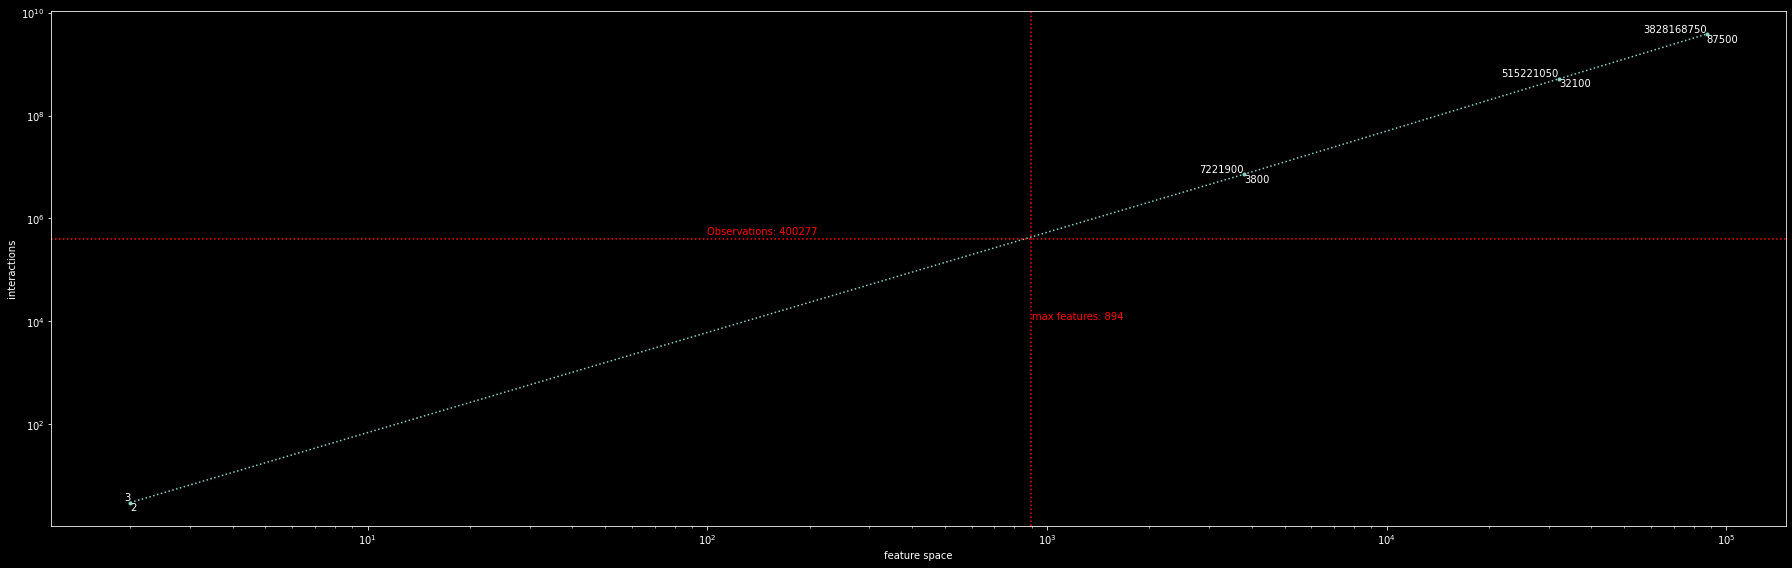

In [104]:
#feature_space = np.logspace(np.log10(2), np.log10(3800), 11)
feature_space = np.array([2, 3800, 32100, 87500])
interactions = (feature_space * (feature_space + 1) / 2).astype('int64')
max_features = int((np.sqrt(8 * df.shape[0] + 1) - 1) / 2)

plt.figure(figsize=(25,8))
plt.loglog(feature_space, interactions, marker='.', linestyle='dotted')
plt.axhline(df.shape[0] , linestyle='dotted', color='red')
plt.text(x=100, y=df.shape[0]*1.1, s='Observations: {}'.format(df.shape[0]), verticalalignment='bottom', color='red')

plt.axvline(max_features , linestyle='dotted', color='red')
plt.text(x=max_features*1.01, y=10**4, s='max features: {}'.format(max_features), verticalalignment='bottom', color='red')
for i,j in zip(feature_space, interactions):
    plt.text(i,j,j, horizontalalignment='right', verticalalignment='bottom')
    plt.text(i,j,i, horizontalalignment='left', verticalalignment='top')
plt.xlabel('feature space')
plt.ylabel('interactions')
plt.tight_layout()
plt.show()

## Interacting different hashed n-grams from all text features

The next simulation takes all numeric and text features from the whole dataset and performs `HashingVectorizer`, `SelectKBest` and `PolynomialFeatures` under different parameters to understand memory limitations.  

For each `ngram_range` a specific parameter space is assigned.  Each space is a log space starting from $2^{2.5}$ to the limit of the `CountVectorizer` resulting features for a given `ngram_range`

In [105]:
# tracemalloc.start()
# tracemalloc.reset_peak()
# threshold = psutil.virtual_memory().available
# print('Threshold/Free mem.: ', size(threshold))
# msg = '2^{}={} ngram:{},{} k:{} union:{} nnz:{} sparse:{:.4f}% size:{} peak:{} iact:{} nnz:{} sparse:{:.4f}% size:{} peak:{} {:.0f}s'

# for i in np.arange(20, 21):
#     for ngram_range in [(1,x) for x in range(30,54)]:
#         # for k in logspaces[ngram_range[1]-1]:
#         for k in [max_k]:
#             if k > 2**i:
#                 continue
#             union.set_params(text_features__vectorizer__n_features = 2**i,
#                              text_features__vectorizer__ngram_range = ngram_range,
#                              text_features__reduction__k = k)
#             t1=time()
#             un = union.fit_transform(df[FEATURES], dummy_labels)
#             print(f'union {time()-t1}')
#             current, un_peak = tracemalloc.get_traced_memory()
#             tracemalloc.reset_peak()
#             un_nbytes = (un.data.nbytes + un.indptr.nbytes + un.indices.nbytes)

#             t2=time()
#             iact = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(un)
#             print(f'PolynomialFeatures {time()-t2}')
#             current, iact_peak = tracemalloc.get_traced_memory()
#             tracemalloc.reset_peak()
#             iact_nbytes = (iact.data.nbytes + iact.indptr.nbytes + iact.indices.nbytes)

#             print(msg.format(i, 2**i, ngram_range[0], ngram_range[1],
#                              k, un.shape[1], un.nnz, (1 - un.nnz / (un.shape[0] * un.shape[1])) * 100,
#                              size(un_nbytes), size(un_peak),
#                              iact.shape[1], iact.nnz, (1-iact.nnz/(iact.shape[0] * iact.shape[1])) * 100,
#                              size(iact_nbytes), size(iact_peak), time()-t1))
#             if iact_peak >= threshold:
#                 print('\tReached threshold: {}'.format(size(threshold)))
#                 break
#         else:
#             continue  # only executed if the inner loop did NOT break
#         break  # only executed if the inner loop DID break
#     else:
#         continue  # likewise
#     break  # likewise
# tracemalloc.stop()

**Saved results:**
```
Last executed at 2022-07-31 23:53:40 in 1h 12m 33s

Threshold/Free mem.:  58.6 GiB
2^20=1048576 ngram:1,1 k:889 union:894 nnz:7050882 sparse:98.0296% size:55.3 MiB peak:1.8 GiB iact:400065 nnz:72614673 sparse:99.9547% size:555.5 MiB peak:1.6 GiB 30s
2^20=1048576 ngram:1,2 k:889 union:894 nnz:10240143 sparse:97.1384% size:79.7 MiB peak:2.4 GiB iact:400065 nnz:166943088 sparse:99.8957% size:1.2 GiB peak:4.3 GiB 47s
2^20=1048576 ngram:1,3 k:889 union:894 nnz:11254174 sparse:96.8550% size:87.4 MiB peak:3.2 GiB iact:400065 nnz:220595700 sparse:99.8622% size:1.6 GiB peak:6.2 GiB 61s
2^20=1048576 ngram:1,4 k:889 union:894 nnz:10902509 sparse:96.9533% size:84.7 MiB peak:3.6 GiB iact:400065 nnz:226729299 sparse:99.8584% size:1.7 GiB peak:6.7 GiB 73s
2^20=1048576 ngram:1,5 k:889 union:894 nnz:10968343 sparse:96.9349% size:85.2 MiB peak:3.7 GiB iact:400065 nnz:241075863 sparse:99.8495% size:1.8 GiB peak:7.1 GiB 85s
2^20=1048576 ngram:1,6 k:889 union:894 nnz:11079199 sparse:96.9039% size:86.1 MiB peak:3.9 GiB iact:400065 nnz:253347619 sparse:99.8418% size:1.9 GiB peak:7.5 GiB 96s
2^20=1048576 ngram:1,7 k:889 union:894 nnz:10945758 sparse:96.9412% size:85.0 MiB peak:4.0 GiB iact:400065 nnz:245698682 sparse:99.8466% size:1.8 GiB peak:7.4 GiB 106s
2^20=1048576 ngram:1,8 k:889 union:894 nnz:10928001 sparse:96.9462% size:84.9 MiB peak:3.9 GiB iact:400065 nnz:250912099 sparse:99.8433% size:1.9 GiB peak:7.5 GiB 116s
2^20=1048576 ngram:1,9 k:889 union:894 nnz:10897171 sparse:96.9548% size:84.7 MiB peak:4.0 GiB iact:400065 nnz:252546456 sparse:99.8423% size:1.9 GiB peak:7.5 GiB 126s
2^20=1048576 ngram:1,10 k:889 union:894 nnz:10836636 sparse:96.9717% size:84.2 MiB peak:4.0 GiB iact:400065 nnz:251072187 sparse:99.8432% size:1.9 GiB peak:7.5 GiB 134s
2^20=1048576 ngram:1,11 k:889 union:894 nnz:10792871 sparse:96.9839% size:83.9 MiB peak:4.0 GiB iact:400065 nnz:248932995 sparse:99.8445% size:1.9 GiB peak:7.5 GiB 144s
2^20=1048576 ngram:1,12 k:889 union:894 nnz:10742466 sparse:96.9980% size:83.5 MiB peak:3.9 GiB iact:400065 nnz:245626016 sparse:99.8466% size:1.8 GiB peak:7.4 GiB 149s
2^20=1048576 ngram:1,13 k:889 union:894 nnz:10633305 sparse:97.0285% size:82.7 MiB peak:4.2 GiB iact:400065 nnz:241466104 sparse:99.8492% size:1.8 GiB peak:7.3 GiB 155s
2^20=1048576 ngram:1,14 k:889 union:894 nnz:10599036 sparse:97.0381% size:82.4 MiB peak:4.1 GiB iact:400065 nnz:240531144 sparse:99.8498% size:1.8 GiB peak:7.2 GiB 162s
2^20=1048576 ngram:1,15 k:889 union:894 nnz:10580356 sparse:97.0433% size:82.2 MiB peak:4.1 GiB iact:400065 nnz:240241248 sparse:99.8500% size:1.8 GiB peak:7.2 GiB 166s
2^20=1048576 ngram:1,16 k:889 union:894 nnz:10562506 sparse:97.0483% size:82.1 MiB peak:4.1 GiB iact:400065 nnz:239538325 sparse:99.8504% size:1.8 GiB peak:7.2 GiB 173s
2^20=1048576 ngram:1,17 k:889 union:894 nnz:10542743 sparse:97.0538% size:82.0 MiB peak:4.1 GiB iact:400065 nnz:238379353 sparse:99.8511% size:1.8 GiB peak:7.1 GiB 175s
2^20=1048576 ngram:1,18 k:889 union:894 nnz:10514735 sparse:97.0617% size:81.7 MiB peak:4.1 GiB iact:400065 nnz:237946184 sparse:99.8514% size:1.8 GiB peak:7.1 GiB 181s
2^20=1048576 ngram:1,19 k:889 union:894 nnz:10499065 sparse:97.0661% size:81.6 MiB peak:4.1 GiB iact:400065 nnz:236800529 sparse:99.8521% size:1.8 GiB peak:7.1 GiB 182s
2^20=1048576 ngram:1,20 k:889 union:894 nnz:10470669 sparse:97.0740% size:81.4 MiB peak:4.1 GiB iact:400065 nnz:235740037 sparse:99.8528% size:1.8 GiB peak:7.1 GiB 185s
2^20=1048576 ngram:1,21 k:889 union:894 nnz:10471578 sparse:97.0737% size:81.4 MiB peak:4.1 GiB iact:400065 nnz:235888666 sparse:99.8527% size:1.8 GiB peak:7.1 GiB 189s
2^20=1048576 ngram:1,22 k:889 union:894 nnz:10453856 sparse:97.0787% size:81.3 MiB peak:4.1 GiB iact:400065 nnz:234822181 sparse:99.8534% size:1.8 GiB peak:7.0 GiB 190s
2^20=1048576 ngram:1,23 k:889 union:894 nnz:10441456 sparse:97.0822% size:81.2 MiB peak:4.1 GiB iact:400065 nnz:233759697 sparse:99.8540% size:1.7 GiB peak:7.0 GiB 194s
2^20=1048576 ngram:1,24 k:889 union:894 nnz:10441860 sparse:97.0820% size:81.2 MiB peak:4.1 GiB iact:400065 nnz:233778211 sparse:99.8540% size:1.7 GiB peak:7.0 GiB 194s
2^20=1048576 ngram:1,25 k:889 union:894 nnz:10442124 sparse:97.0820% size:81.2 MiB peak:4.1 GiB iact:400065 nnz:233791172 sparse:99.8540% size:1.7 GiB peak:7.0 GiB 199s
2^20=1048576 ngram:1,26 k:889 union:894 nnz:10442387 sparse:97.0819% size:81.2 MiB peak:4.1 GiB iact:400065 nnz:233804711 sparse:99.8540% size:1.7 GiB peak:7.0 GiB 198s
2^20=1048576 ngram:1,27 k:889 union:894 nnz:10443721 sparse:97.0815% size:81.2 MiB peak:4.1 GiB iact:400065 nnz:233859376 sparse:99.8540% size:1.7 GiB peak:7.0 GiB 199s
2^20=1048576 ngram:1,28 k:889 union:894 nnz:10450160 sparse:97.0797% size:81.3 MiB peak:4.1 GiB iact:400065 nnz:234699143 sparse:99.8534% size:1.8 GiB peak:7.0 GiB 200s
2^20=1048576 ngram:1,29 k:889 union:894 nnz:10450792 sparse:97.0795% size:81.3 MiB peak:4.1 GiB iact:400065 nnz:234730432 sparse:99.8534% size:1.8 GiB peak:7.0 GiB 203s
2^20=1048576 ngram:1,30 k:889 union:894 nnz:10456411 sparse:97.0780% size:81.3 MiB peak:2.3 GiB iact:400065 nnz:234729933 sparse:99.8534% size:1.8 GiB peak:5.3 GiB 201s
2^20=1048576 ngram:1,31 k:889 union:894 nnz:10456551 sparse:97.0779% size:81.3 MiB peak:4.1 GiB iact:400065 nnz:234738149 sparse:99.8534% size:1.8 GiB peak:7.0 GiB 205s
2^20=1048576 ngram:1,32 k:889 union:894 nnz:10456589 sparse:97.0779% size:81.3 MiB peak:4.1 GiB iact:400065 nnz:234740051 sparse:99.8534% size:1.8 GiB peak:7.0 GiB 203s
2^20=1048576 ngram:1,33 k:889 union:894 nnz:10461954 sparse:97.0764% size:81.3 MiB peak:4.1 GiB iact:400065 nnz:235034588 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 205s
2^20=1048576 ngram:1,34 k:889 union:894 nnz:10461996 sparse:97.0764% size:81.3 MiB peak:4.1 GiB iact:400065 nnz:235036804 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 203s
2^20=1048576 ngram:1,35 k:889 union:894 nnz:10462067 sparse:97.0764% size:81.3 MiB peak:4.2 GiB iact:400065 nnz:235040842 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 205s
2^20=1048576 ngram:1,36 k:889 union:894 nnz:10462095 sparse:97.0764% size:81.3 MiB peak:4.2 GiB iact:400065 nnz:235042348 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
2^20=1048576 ngram:1,37 k:889 union:894 nnz:10462128 sparse:97.0764% size:81.3 MiB peak:4.2 GiB iact:400065 nnz:235044270 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 207s
2^20=1048576 ngram:1,38 k:889 union:894 nnz:10462347 sparse:97.0763% size:81.3 MiB peak:4.2 GiB iact:400065 nnz:235058541 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 207s
2^20=1048576 ngram:1,39 k:889 union:894 nnz:10462364 sparse:97.0763% size:81.3 MiB peak:4.2 GiB iact:400065 nnz:235059530 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
2^20=1048576 ngram:1,40 k:889 union:894 nnz:10462561 sparse:97.0763% size:81.3 MiB peak:4.2 GiB iact:400065 nnz:235069202 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
2^20=1048576 ngram:1,41 k:889 union:894 nnz:10462562 sparse:97.0763% size:81.3 MiB peak:4.2 GiB iact:400065 nnz:235069257 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
2^20=1048576 ngram:1,42 k:889 union:894 nnz:10462576 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235070147 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
2^20=1048576 ngram:1,43 k:889 union:894 nnz:10462606 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235072185 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 207s
2^20=1048576 ngram:1,44 k:889 union:894 nnz:10462611 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235072492 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 205s
2^20=1048576 ngram:1,45 k:889 union:894 nnz:10462639 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235074421 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
2^20=1048576 ngram:1,46 k:889 union:894 nnz:10462641 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235074507 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
2^20=1048576 ngram:1,47 k:889 union:894 nnz:10462644 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235074678 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 207s
2^20=1048576 ngram:1,48 k:889 union:894 nnz:10462644 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235074678 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 203s
2^20=1048576 ngram:1,49 k:889 union:894 nnz:10462644 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235074678 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
2^20=1048576 ngram:1,50 k:889 union:894 nnz:10462644 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235074678 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 207s
2^20=1048576 ngram:1,51 k:889 union:894 nnz:10462644 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235074678 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
2^20=1048576 ngram:1,52 k:889 union:894 nnz:10462644 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235074678 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
2^20=1048576 ngram:1,53 k:889 union:894 nnz:10462644 sparse:97.0762% size:81.4 MiB peak:4.2 GiB iact:400065 nnz:235074678 sparse:99.8532% size:1.8 GiB peak:7.0 GiB 206s
```

## Feature scaling

[Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), also known as data normalization, is a method used to normalize the range of independent variables or features of data.

See [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

One can use different **scalers, transformers, and normalizers** to bring the data within a pre-defined range.

Scalers are **linear transformers** (more precisely [affine transformers](https://en.wikipedia.org/wiki/Affine_transformation)) and differ from each other in the way to estimate the parameters used to shift and scale **each feature**:
* `StandardScaler` - standardizes features by removing the mean and scaling to unit variance
* `MinMaxScaler` - transforms features by scaling each feature to a given range, default (0, 1)
* `MaxAbsScaler` - scales each feature by its maximum absolute value to a range (-1, 1)
* `RobustScaler` - scales features using statistics that are robust to outliers

Transformers provides non-linear transformations:
* `QuantileTransformer` - transforms features using quantiles information, where distances between marginal outliers and inliers are shrunk.
* `PowerTransformer` - applies a power transform featurewise to make data more Gaussian-like, where data is mapped to a normal distribution to stabilize variance and minimize skewness.

Unlike the previous transformations, normalization refers to a **per sample** transformation instead of a **per feature** transformation:
* `Normalizer` - normalizes samples individually to unit norm
> Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community.

Initial considerations:
* `StandardScaler`, `MinMaxScaler` are very sensitive to the presence of outliers.
* `MinMaxScaler` doesn´t support sparse input
* On positive only data, `MaxAbsScaler` behaves similarly to MinMaxScaler, suffering from the presence of large outliers.
* The centering and scaling statistics of the `RobustScaler` are based on percentiles and not influenced by a few number of very large marginal outliers. The resulting range of the transformed feature values is larger than for the previous scalers and are approximately similar.
* `PowerTransformer(method='Yeo-Johnson')` can be applied to both negative and positive data. Requires dense input.
* `PowerTransformer(method='Box-Cox')` can only be applied to strictly positive data. Requires dense input.
* `QuantileTransformer(output_distribution='gaussian')`: Note that this non-parametetric transformer introduces saturation artifacts for outliers.
* `QuantileTransformer(output_distribution='uniform')` as `RobustScaler`, are robust to outliers but they will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

Final considerations:

For this problem, we need to scale a sparse matrix without destroying any sparsity, i.e., non-stored zero values should continue being like that.  The scalers/settings supporting that are:
* `StandardScaler(with_mean=False)`
* `MaxAbsScaler`
* `RobustScaler(with_centering=False)`
* `Normalizer(norm='l2')`
* `Normalizer(norm='l1')`

From these, the only scaler not sensible to outliers is the `RobustScaler`

In [106]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, Normalizer

In [107]:
tracemalloc.start()
tracemalloc.reset_peak()
scalers = [("StandardScaler(with_mean=False)       ", StandardScaler(with_mean=False)), # because True doesn't work with sparse matrix
           ("MaxAbsScaler()                        ", MaxAbsScaler()),
           ("Normalizer(norm='l2')                 ", Normalizer(norm='l2')),
           ("Normalizer(norm='l1')                 ", Normalizer(norm='l1')),
           #('RobustScaler(with_centering=False)', RobustScaler(with_centering=False)) # takes much too long
          ]
union.set_params(text_features__vectorizer__n_features = 2**20,
                 text_features__vectorizer__ngram_range = (1, 1),
                 text_features__reduction__k = max_k)
print('Threshold/Free mem.: ', size(psutil.virtual_memory().available))

t1=time()
tdm = union.fit_transform(df[FEATURES], dummy_labels)
print('Union elapsed: {:.2f}s'.format(time()-t1))
current, peak = tracemalloc.get_traced_memory()
print('Memory peak after union:', size(peak))
tracemalloc.reset_peak()

t2=time()
tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(tdm)
print('Interaction elapsed: {:.2f}s'.format(time()-t2))
current, peak = tracemalloc.get_traced_memory()
print('Memory peak after Interaction:', size(peak))
tracemalloc.reset_peak()

sparsity = (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100
tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)

display(tdm)

msg = 'nnz: {} sparsity: {:.4f}% min: {} max: {} nbytes: {} peak: {} time: {:.2f}s'
print(msg.format(tdm.nnz, sparsity, tdm.min(), tdm.max(), size(tdm_nbytes), size(peak), time()-t1))

Threshold/Free mem.:  58.8 GiB
Union elapsed: 30.30s
Memory peak after union: 1.8 GiB
Interaction elapsed: 1.18s
Memory peak after Interaction: 2.7 GiB


<400277x400065 sparse matrix of type '<class 'numpy.float32'>'
	with 72614673 stored elements in Compressed Sparse Row format>

nnz: 72614673 sparsity: 99.9547% min: -262398912.0 max: 259400000.0 nbytes: 555.5 MiB peak: 2.7 GiB time: 31.51s


**Saved results:**
```
Last executed at 2022-08-01 02:01:35 in 33.24s

Threshold/Free mem.:  55.8 GiB
Union elapsed: 32.69s
Memory peak after union: 2.5 GiB
Interaction elapsed: 0.48s
Memory peak after Interaction: 1.8 GiB

<400277x400065 sparse matrix of type '<class 'numpy.float32'>'
	with 72614673 stored elements in Compressed Sparse Row format>

nnz: 72614673 sparsity: 99.9547% min: -262398912.0 max: 259400000.0 nbytes: 555.5 MiB peak: 1.8 GiB time: 33.23s
```

In [108]:
for name, scaler in scalers:
    t=time()
    tdm2 = scaler.fit_transform(tdm, dummy_labels)
    t=time()-t
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.reset_peak()
    msg = 'min: {:>20} max: {:>20} current: {} peak: {} time: {:.0f}s'
    print(name, msg.format(tdm2.min(), tdm2.max(), size(current), size(peak), t))

StandardScaler(with_mean=False)        min:       -626.658203125 max:      632.67529296875 current: 1.1 GiB peak: 2.2 GiB time: 1s
MaxAbsScaler()                         min:                 -1.0 max:                  1.0 current: 1.1 GiB peak: 2.5 GiB time: 1s
Normalizer(norm='l2')                  min:  -0.8111070990562439 max:   0.9954653382301331 current: 1.1 GiB peak: 1.7 GiB time: 0s
Normalizer(norm='l1')                  min:  -0.3026109039783478 max:   0.8239297270774841 current: 1.1 GiB peak: 1.7 GiB time: 0s


**Saved results:**  
```
Last executed at 2022-08-01 02:02:09 in 2.97s

StandardScaler(with_mean=False)        min:       -626.658203125 max:      632.67529296875 current: 1.3 GiB peak: 2.4 GiB time: 1s
MaxAbsScaler()                         min:                 -1.0 max:                  1.0 current: 1.3 GiB peak: 2.6 GiB time: 1s
Normalizer(norm='l2')                  min:  -0.8111070990562439 max:   0.9954653382301331 current: 1.3 GiB peak: 1.8 GiB time: 0s
Normalizer(norm='l1')                  min:  -0.3026109039783478 max:   0.8239297270774841 current: 1.3 GiB peak: 1.8 GiB time: 0s
```

## Pipeline: Logistic Regression

In [109]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, PolynomialFeatures
from preprocessing.combine_text_columns import combine_text_columns
from sklearn.metrics import classification_report
from metrics.log_loss import multi_multi_log_loss
from metrics.log_loss import log_loss_report_part, log_loss_report
from dummies import get_dummies_indices
from model_selection.multilabel import multilabel_train_test_split, multilabel_sample_dataframe
from preprocessing.get_normalized_total import get_normalized_total
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': NUMERIC_FEATURES + LABELS})
get_numeric_data = FunctionTransformer(get_normalized_total, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total'})
pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', Pipeline([
            ('numeric_selector', get_numeric_data),
            ('imputer', SimpleImputer(strategy='constant', fill_value=0))
        ], verbose=True #, memory='/data/drivendata/cache'
        )),
        ('text_features' , Pipeline([
            ('text_selector', get_text_data),
            ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, token_pattern='(?u)\\b\\w+\\b', dtype='float32')),
            ('reducer', SelectKBest(chi2))
        ], verbose=True #, memory='/data/drivendata/cache'
        ))
    ], verbose=True # n_jobs=None
    )),
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('scaler', MaxAbsScaler()),
    ('classifier', OneVsRestClassifier(LogisticRegression(random_state=1)))
], verbose=True #, memory='/data/drivendata/cache'
)

### 0.008 train

In [110]:
sample_rate = 0.01
test_sample_rate = 0.2
sampling = multilabel_sample_dataframe(df, dummy_labels, size=sample_rate, min_count=7, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'), size=test_sample_rate, min_count=1, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, 5)
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} C:{C}')

Training: 3202, testing: 800 k: 74 C:1


In [111]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__n_jobs = -1)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__solver = "liblinear")
pl.set_params(classifier__estimator__C = C)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'3202-k74-logistic-regression-C1'

In [112]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

Loading cache 3202-k74-logistic-regression-C1 ... done: 0.0 minutes


**Saved results**

Only intel GPU, no intelex:
```
Last executed at 2022-08-10 19:39:35 in 6.58s

Fitting started on 2022-08-10T19:39
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.1s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   5.6s
[Pipeline] ............. (step 1 of 4) Processing union, total=   5.6s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.9s
Done: 0.1 minutes
Saving cache 3202-k74-logistic-regression-C1 ... Done: 0.0 minutes
```
Only intel GPU, with intelex:
```
Last executed at 2022-08-10 19:53:30 in 6.95s

Fitting started on 2022-08-10T19:53
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.1s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   5.6s
[Pipeline] ............. (step 1 of 4) Processing union, total=   5.7s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.3s
Done: 0.1 minutes
Saving cache 3202-k74-logistic-regression-C1 ... Done: 0.0 minutes
```

In [113]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-08-10T20:15
Training accuracy         : 0.5219
Training log loss         : 0.4311
Training log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.353160,0.117720
Sharing,5,0.444515,0.088903
Use,8,0.500894,0.062612
Operating_Status,3,0.185739,0.061913
Student_Type,9,0.400700,0.044522
Pre_K,3,0.131293,0.043764
Object_Type,11,0.463563,0.042142
Function,37,0.837016,0.022622
Position_Type,25,0.562745,0.022510


Training log loss by class:


,occurrences,log_loss,avg_log_loss
Operating_Status__PreK-12 Operating,2763,8.622085e-16,2.382282e-12
Pre_K__NO_LABEL,2419,7.548615e-16,1.826010e-12
Reporting__School,1975,6.163090e-16,1.217210e-12
Sharing__School Reported,1960,6.116282e-16,1.198791e-12
Student_Type__Unspecified,1769,5.520256e-16,9.765333e-13
Use__Instruction,1539,4.802529e-16,7.391093e-13
Position_Type__NO_LABEL,795,2.480839e-16,1.972267e-13
Reporting__Non-School,788,2.458995e-16,1.937688e-13
Student_Type__NO_LABEL,781,2.437151e-16,1.903415e-13
Position_Type__Teacher,755,2.356017e-16,1.778793e-13


Training classification Report:


/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Function__Communications,0.000000,0.000000,0.000000,6.0
Function__Development & Fundraising,0.000000,0.000000,0.000000,5.0
Function__Parent & Community Relations,0.000000,0.000000,0.000000,15.0
Function__Governance,0.000000,0.000000,0.000000,10.0
Function__Other Non-Compensation,0.000000,0.000000,0.000000,15.0
Function__Other Compensation,0.000000,0.000000,0.000000,8.0
Student_Type__Alternative,0.000000,0.000000,0.000000,8.0
Object_Type__Rent/Utilities,1.000000,0.030303,0.058824,33.0
Object_Type__Contracted Services,1.000000,0.045455,0.086957,66.0
Function__Utilities,1.000000,0.050000,0.095238,20.0


,precision,recall,f1-score,support
micro avg,0.928088,0.819106,0.870198,28818.0
macro avg,0.892570,0.548922,0.637009,28818.0
weighted avg,0.928754,0.819106,0.853796,28818.0
samples avg,0.914422,0.819106,0.855131,28818.0


Training report finished on 2022-08-10T20:15, elapsed 0.0 minutes

Testing report started on 2022-08-10T20:15
Testing accuracy         : 0.4288
Testing log loss         : 0.6136
Testing log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.458392,0.152797
Sharing,5,0.637845,0.127569
Use,8,0.760098,0.095012
Operating_Status,3,0.246084,0.082028
Pre_K,3,0.228198,0.076066
Student_Type,9,0.559835,0.062204
Object_Type,11,0.594025,0.054002
Position_Type,25,0.851067,0.034043
Function,37,1.187022,0.032082


Testing log loss by class:


,occurrences,log_loss,avg_log_loss
Operating_Status__PreK-12 Operating,704,8.792966e-16,6.190248e-13
Pre_K__NO_LABEL,592,7.394085e-16,4.377299e-13
Reporting__School,477,5.957734e-16,2.841839e-13
Student_Type__Unspecified,474,5.920264e-16,2.806205e-13
Sharing__School Reported,469,5.857814e-16,2.747315e-13
Use__Instruction,380,4.746203e-16,1.803557e-13
Reporting__Non-School,227,2.835232e-16,6.435977e-14
Object_Type__Base Salary/Compensation,205,2.560452e-16,5.248926e-14
Pre_K__Non PreK,186,2.323142e-16,4.321044e-14
Position_Type__Teacher,183,2.285672e-16,4.182779e-14


Testing classification Report:


/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Use__Untracked Budget Set-Aside,0.000000,0.000000,0.000000,6.0
Function__Student Assignment,0.000000,0.000000,0.000000,5.0
Function__Parent & Community Relations,0.000000,0.000000,0.000000,7.0
Function__Other Non-Compensation,0.000000,0.000000,0.000000,6.0
Function__Other Compensation,0.000000,0.000000,0.000000,6.0
Function__Untracked Budget Set-Aside,0.000000,0.000000,0.000000,6.0
Function__Utilities,0.000000,0.000000,0.000000,5.0
Function__Legal,0.000000,0.000000,0.000000,3.0
Student_Type__Alternative,0.000000,0.000000,0.000000,1.0
Object_Type__Contracted Services,0.000000,0.000000,0.000000,12.0


,precision,recall,f1-score,support
micro avg,0.878467,0.760972,0.815509,7200.0
macro avg,0.705641,0.471526,0.532718,7200.0
weighted avg,0.858331,0.760972,0.790396,7200.0
samples avg,0.867294,0.760972,0.799637,7200.0


Testing report finished on 2022-08-10T20:15, elapsed 0.0 minutes



Saved results

Only intel GPU, no intelex: Last executed at 2022-08-10 19:39:37 in 1.75s  
Only intel GPU, with intelex: Last executed at 2022-08-10 19:53:31 in 1.92s

In [114]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


Saved results

Only intel GPU, no intelex: Last executed at 2022-08-10 19:39:54 in 17.23s  
Only intel GPU, with intelex: Last executed at 2022-08-10 19:53:49 in 17.29s

### 0.08 train

In [115]:
sample_rate = 0.1
test_sample_rate = 0.2
sampling = multilabel_sample_dataframe(df, dummy_labels, size=sample_rate, min_count=2, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'), size=test_sample_rate, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, 5)
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} C:{C}')

Training: 32022, testing: 8005 k: 247 C:1


In [116]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__n_jobs = -1)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__solver = "liblinear")
pl.set_params(classifier__estimator__C = C)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'32022-k247-logistic-regression-C1'

In [117]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

Fitting started on 2022-08-10T20:15
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.7s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.3s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.6s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   7.6s
[Pipeline] ............. (step 1 of 4) Processing union, total=   7.7s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.1s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=  39.9s
Done: 0.8 minutes
Saving cache 32022-k247-logistic-regression-C1 ... Done: 0.0 minutes


**Saved results**

Only intel GPU, no intelex: 
```
Last executed at 2022-08-10 20:07:28 in 48.17s

Fitting started on 2022-08-10T20:06
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.8s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.4s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.5s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   7.7s
[Pipeline] ............. (step 1 of 4) Processing union, total=   7.8s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.1s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=  40.2s
Done: 0.8 minutes
Saving cache 32022-k247-logistic-regression-C1 ... Done: 0.0 minutes
```
On intel GPU, with intelex:
```
Last executed at 2022-08-10 20:16:20 in 47.68s

Fitting started on 2022-08-10T20:15
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.7s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.3s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.6s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   7.6s
[Pipeline] ............. (step 1 of 4) Processing union, total=   7.7s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.1s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=  39.9s
Done: 0.8 minutes
Saving cache 32022-k247-logistic-regression-C1 ... Done: 0.0 minutes
```

In [118]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-08-10T20:16
Training accuracy         : 0.8750
Training log loss         : 0.0966
Training log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.086621,0.028874
Sharing,5,0.109263,0.021853
Operating_Status,3,0.048202,0.016067
Use,8,0.124304,0.015538
Pre_K,3,0.034117,0.011372
Student_Type,9,0.100487,0.011165
Object_Type,11,0.082693,0.007518
Function,37,0.186876,0.005051
Position_Type,25,0.096824,0.003873


Training log loss by class:


,occurrences,log_loss,avg_log_loss
Operating_Status__PreK-12 Operating,27416,8.554771e-16,2.345376e-11
Pre_K__NO_LABEL,24513,7.648931e-16,1.874982e-11
Reporting__School,20532,6.406717e-16,1.315427e-11
Sharing__School Reported,20298,6.333701e-16,1.285615e-11
Student_Type__Unspecified,17821,5.560788e-16,9.909881e-12
Use__Instruction,16268,5.076197e-16,8.257957e-12
Position_Type__Teacher,8197,2.557757e-16,2.096593e-12
Student_Type__NO_LABEL,8059,2.514696e-16,2.026593e-12
Position_Type__NO_LABEL,7802,2.434503e-16,1.899399e-12
Object_Type__Base Salary/Compensation,7771,2.424829e-16,1.884335e-12


Training classification Report:


,precision,recall,f1-score,support
Function__Development & Fundraising,1.000000,0.250000,0.400000,8.0
Use__Untracked Budget Set-Aside,1.000000,0.413793,0.585366,29.0
Function__Untracked Budget Set-Aside,1.000000,0.413793,0.585366,29.0
Function__Other Non-Compensation,0.984615,0.450704,0.618357,142.0
"Function__Finance, Budget, Purchasing & Distribution",0.989362,0.543860,0.701887,171.0
Student_Type__Alternative,1.000000,0.595745,0.746667,47.0
Function__Extended Time & Tutoring,0.790030,0.778274,0.784108,672.0
Function__Insurance,1.000000,0.666667,0.800000,6.0
Function__Other Compensation,0.913043,0.724138,0.807692,58.0
Function__Governance,1.000000,0.688525,0.815534,61.0


,precision,recall,f1-score,support
micro avg,0.979877,0.966481,0.973133,288198.0
macro avg,0.977903,0.872592,0.915132,288198.0
weighted avg,0.979817,0.966481,0.972481,288198.0
samples avg,0.978818,0.966481,0.971564,288198.0


Training report finished on 2022-08-10T20:16, elapsed 0.2 minutes

Testing report started on 2022-08-10T20:16
Testing accuracy         : 0.8186
Testing log loss         : 0.1531
Testing log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.125383,0.041794
Sharing,5,0.174478,0.034896
Use,8,0.210397,0.026300
Operating_Status,3,0.073540,0.024513
Pre_K,3,0.054987,0.018329
Student_Type,9,0.152096,0.016900
Object_Type,11,0.122006,0.011091
Function,37,0.304279,0.008224
Position_Type,25,0.161110,0.006444


Testing log loss by class:


,occurrences,log_loss,avg_log_loss
Operating_Status__PreK-12 Operating,6921,8.638936e-16,5.979008e-12
Pre_K__NO_LABEL,6112,7.629125e-16,4.662921e-12
Reporting__School,5239,6.539429e-16,3.426007e-12
Sharing__School Reported,5188,6.475769e-16,3.359629e-12
Student_Type__Unspecified,4502,5.619490e-16,2.529894e-12
Use__Instruction,4081,5.093989e-16,2.078857e-12
Position_Type__Teacher,2068,2.581321e-16,5.338171e-13
Object_Type__Base Salary/Compensation,1944,2.426541e-16,4.717196e-13
Student_Type__NO_LABEL,1925,2.402825e-16,4.625438e-13
Position_Type__NO_LABEL,1890,2.359137e-16,4.458769e-13


Testing classification Report:


/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Use__Untracked Budget Set-Aside,0.000000,0.000000,0.000000,7.0
Function__Untracked Budget Set-Aside,0.000000,0.000000,0.000000,7.0
Function__Development & Fundraising,0.000000,0.000000,0.000000,1.0
Function__Communications,1.000000,0.142857,0.250000,7.0
Function__Other Non-Compensation,0.875000,0.212121,0.341463,33.0
Function__Governance,1.000000,0.250000,0.400000,12.0
"Function__Finance, Budget, Purchasing & Distribution",1.000000,0.303571,0.465753,56.0
Position_Type__Nurse Aide,1.000000,0.333333,0.500000,3.0
Function__Student Assignment,1.000000,0.400000,0.571429,5.0
Function__Special Population Program Management & Support,0.813559,0.539326,0.648649,89.0


,precision,recall,f1-score,support
micro avg,0.966771,0.946991,0.956779,72045.0
macro avg,0.927968,0.793640,0.841671,72045.0
weighted avg,0.965875,0.946991,0.955141,72045.0
samples avg,0.965184,0.946991,0.954250,72045.0


Testing report finished on 2022-08-10T20:16, elapsed 0.1 minutes



**Saved results**

Only intel GPU, no intelex: Last executed at 2022-08-10 20:07:45 in 16.52s  
Only intel GPU, with intelex: Last executed at 2022-08-10 20:16:35 in 15.22s

In [119]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


**Saved results**

Only intel GPU, no intelex: ?  
Only intel GPU, with intelex: Last executed at 2022-08-10 20:16:35 in 15.22s

### 0.16 train

In [121]:
sample_rate = 0.2
test_sample_rate = 0.2
sampling = multilabel_sample_dataframe(df, dummy_labels, size=sample_rate, min_count=2, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'), size=test_sample_rate, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, 5)
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} C:{C}')

Training: 64044, testing: 16011 k: 352 C:1


In [122]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__n_jobs = -1)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__solver = "liblinear")
pl.set_params(classifier__estimator__C = C)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'64044-k352-logistic-regression-C1'

In [123]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

Fitting started on 2022-08-10T20:18
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   1.7s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.8s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.6s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  10.1s
[Pipeline] ............. (step 1 of 4) Processing union, total=  10.2s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.2s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.2s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.7min
Done: 1.9 minutes
Saving cache 64044-k352-logistic-regression-C1 ... Done: 0.0 minutes


**Saved results**

Only intel GPU, no intelex: 
```
Last executed at 2022-08-10 20:10:03 in 1m 58.45s

Fitting started on 2022-08-10T20:08
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   1.7s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.8s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.6s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  10.1s
[Pipeline] ............. (step 1 of 4) Processing union, total=  10.2s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.2s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.2s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.8min
Done: 2.0 minutes
Saving cache 64044-k352-logistic-regression-C1 ... Done: 0.0 minutes
```
Only intel GPU, with intelex: 
```
Last executed at 2022-08-10 20:20:16 in 1m 55.03s

Fitting started on 2022-08-10T20:18
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   1.7s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.8s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.6s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  10.1s
[Pipeline] ............. (step 1 of 4) Processing union, total=  10.2s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.2s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.2s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.7min
Done: 1.9 minutes
Saving cache 64044-k352-logistic-regression-C1 ... Done: 0.0 minutes
```

Testing log loss : 0.1086  
Your score for this submission is: 0.5070

In [124]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-08-10T20:21
Training accuracy         : 0.9155
Training log loss         : 0.0692
Training log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.063069,0.021023
Sharing,5,0.078332,0.015666
Operating_Status,3,0.039706,0.013235
Use,8,0.090037,0.011255
Pre_K,3,0.028093,0.009364
Student_Type,9,0.069907,0.007767
Object_Type,11,0.059139,0.005376
Function,37,0.131907,0.003565
Position_Type,25,0.062686,0.002507


Training log loss by class:


,occurrences,log_loss,avg_log_loss
Operating_Status__PreK-12 Operating,54939,8.571465e-16,4.709077e-11
Pre_K__NO_LABEL,48972,7.640506e-16,3.741709e-11
Reporting__School,41195,6.427155e-16,2.647667e-11
Sharing__School Reported,40748,6.357415e-16,2.590520e-11
Student_Type__Unspecified,35697,5.569369e-16,1.988098e-11
Use__Instruction,32610,5.087742e-16,1.659113e-11
Position_Type__Teacher,16372,2.554324e-16,4.181940e-12
Student_Type__NO_LABEL,15943,2.487393e-16,3.965650e-12
Position_Type__NO_LABEL,15658,2.442928e-16,3.825136e-12
Object_Type__Base Salary/Compensation,15490,2.416717e-16,3.743494e-12


Training classification Report:


,precision,recall,f1-score,support
Use__Untracked Budget Set-Aside,1.000000,0.266667,0.421053,45.0
Function__Untracked Budget Set-Aside,1.000000,0.266667,0.421053,45.0
Function__Development & Fundraising,1.000000,0.500000,0.666667,18.0
Function__Governance,0.972222,0.630631,0.765027,111.0
Function__Other Non-Compensation,0.945813,0.646465,0.768000,297.0
Student_Type__Alternative,0.981481,0.646341,0.779412,82.0
Function__Insurance,1.000000,0.714286,0.833333,14.0
"Function__Finance, Budget, Purchasing & Distribution",0.978261,0.754190,0.851735,358.0
"Operating_Status__Operating, Not PreK-12",0.991533,0.750712,0.854479,1404.0
Function__Extended Time & Tutoring,0.903358,0.825599,0.862730,1336.0


,precision,recall,f1-score,support
micro avg,0.984033,0.977035,0.980521,576396.0
macro avg,0.979396,0.907664,0.936175,576396.0
weighted avg,0.983955,0.977035,0.980212,576396.0
samples avg,0.983368,0.977035,0.979643,576396.0


Training report finished on 2022-08-10T20:21, elapsed 0.4 minutes

Testing report started on 2022-08-10T20:21
Testing accuracy         : 0.8641
Testing log loss         : 0.1086
Testing log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.088378,0.029459
Sharing,5,0.123737,0.024747
Operating_Status,3,0.059687,0.019896
Use,8,0.145866,0.018233
Pre_K,3,0.044089,0.014696
Student_Type,9,0.104298,0.011589
Object_Type,11,0.088241,0.008022
Function,37,0.213906,0.005781
Position_Type,25,0.108855,0.004354


Testing log loss by class:


,occurrences,log_loss,avg_log_loss
Operating_Status__PreK-12 Operating,13756,8.584726e-16,1.180915e-11
Pre_K__NO_LABEL,12196,7.611175e-16,9.282589e-12
Reporting__School,10301,6.428560e-16,6.622059e-12
Sharing__School Reported,10182,6.354295e-16,6.469943e-12
Student_Type__Unspecified,8951,5.586063e-16,5.000085e-12
Use__Instruction,8048,5.022527e-16,4.042129e-12
Position_Type__Teacher,4138,2.582407e-16,1.068600e-12
Student_Type__NO_LABEL,3964,2.473819e-16,9.806219e-13
Object_Type__Base Salary/Compensation,3944,2.461338e-16,9.707516e-13
Position_Type__NO_LABEL,3844,2.398930e-16,9.221489e-13


Testing classification Report:


/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Function__Development & Fundraising,0.000000,0.000000,0.000000,2.0
Function__Insurance,0.000000,0.000000,0.000000,1.0
Function__Facilities Planning,0.000000,0.000000,0.000000,0.0
Use__Untracked Budget Set-Aside,1.000000,0.187500,0.315789,16.0
Function__Untracked Budget Set-Aside,1.000000,0.187500,0.315789,16.0
Function__Student Assignment,1.000000,0.300000,0.461538,10.0
Function__Governance,0.833333,0.384615,0.526316,26.0
Function__Other Non-Compensation,0.838710,0.393939,0.536082,66.0
Function__Legal,1.000000,0.500000,0.666667,2.0
Student_Type__Alternative,0.900000,0.562500,0.692308,16.0


,precision,recall,f1-score,support
micro avg,0.973322,0.961603,0.967427,144099.0
macro avg,0.928104,0.824983,0.862924,144099.0
weighted avg,0.972861,0.961603,0.966638,144099.0
samples avg,0.972203,0.961603,0.965788,144099.0


Testing report finished on 2022-08-10T20:21, elapsed 0.1 minutes



**Saved results**

Only intel GPU, no intelex: Last executed at 2022-08-10 20:10:38 in 34.99s  
Only intel GPU, with intelex: Last executed at 2022-08-10 20:21:48 in 33.17s

Testing log loss : 0.1086  
Your score for this submission is: 0.5070

In [125]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


**Saved results**

Only intel GPU, no intelex: Last executed at 2022-08-10 20:10:56 in 18.48s  
Only intel GPU, with intelex: Last executed at 2022-08-10 20:22:28 in 18.14s

### 0.8 train **(waiting 80% learning curve)**

In [126]:
test_sample_rate = 0.2
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=test_sample_rate, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, 5)
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} C:{C}')

Training: 320222, testing: 80055 k: 794 C:1


In [127]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__n_jobs = -1)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__solver = "liblinear")
pl.set_params(classifier__estimator__C = C)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'320222-k794-logistic-regression-C1'

In [128]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

Fitting started on 2022-08-10T20:24
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.4s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.4s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   8.0s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  14.0s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   6.9s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  28.9s
[Pipeline] ............. (step 1 of 4) Processing union, total=  29.3s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   1.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=21.6min
Done: 22.1 minutes
Saving cache 320222-k794-logistic-regression-C1 ... Done: 0.0 minutes


**Saved results**

Only intel gpu no intelex: 
```
Last executed at 2022-08-03 08:58:37 in 22m 11.67s

Fitting started on 2022-08-03T08:36
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.4s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.4s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   8.7s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  14.5s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   6.9s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  30.2s
[Pipeline] ............. (step 1 of 4) Processing union, total=  30.7s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.9s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=21.6min
Done: 22.2 minutes
Saving cache 320222-k794-logistic-regression-C1 ... Done: 0.0 minutes
```
Only intel gpu with intelex:
```
Last executed at 2022-08-10 20:46:49 in 22m 7.18s

Fitting started on 2022-08-10T20:24
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.4s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.4s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   8.0s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  14.0s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   6.9s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  28.9s
[Pipeline] ............. (step 1 of 4) Processing union, total=  29.3s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   1.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=21.6min
Done: 22.1 minutes
Saving cache 320222-k794-logistic-regression-C1 ... Done: 0.0 minutes
```
Testing log loss : 0.0644  
Your score for this submission is: 0.5000

In [129]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-08-10T20:48
Training accuracy         : 0.9459
Training log loss         : 0.0467
Training log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.046192,0.015397
Sharing,5,0.055028,0.011006
Operating_Status,3,0.032541,0.010847
Pre_K,3,0.022142,0.007381
Use,8,0.057948,0.007244
Student_Type,9,0.048355,0.005373
Object_Type,11,0.034799,0.003164
Function,37,0.086985,0.002351
Position_Type,25,0.035985,0.001439


Training log loss by class:


,occurrences,log_loss,avg_log_loss
Operating_Status__PreK-12 Operating,274947,8.579274e-16,2.358846e-10
Pre_K__NO_LABEL,245124,7.648696e-16,1.874879e-10
Reporting__School,205985,6.427427e-16,1.323954e-10
Sharing__School Reported,203733,6.357157e-16,1.295163e-10
Student_Type__Unspecified,178282,5.563000e-16,9.917828e-11
Use__Instruction,163156,5.091018e-16,8.306301e-11
Position_Type__Teacher,82171,2.564013e-16,2.106875e-11
Student_Type__NO_LABEL,79846,2.491465e-16,1.989335e-11
Object_Type__Base Salary/Compensation,78075,2.436204e-16,1.902066e-11
Position_Type__NO_LABEL,78024,2.434612e-16,1.899582e-11


Training classification Report:


,precision,recall,f1-score,support
Use__Untracked Budget Set-Aside,0.945455,0.561151,0.704289,278.0
Function__Untracked Budget Set-Aside,0.945455,0.561151,0.704289,278.0
Student_Type__Alternative,0.953333,0.758621,0.844904,377.0
Function__Extended Time & Tutoring,0.902949,0.828945,0.864366,6723.0
"Operating_Status__Operating, Not PreK-12",0.983666,0.785166,0.873278,6903.0
Function__School Supervision,0.935813,0.865693,0.899388,2122.0
Function__Governance,0.955850,0.883673,0.918346,490.0
"Function__Finance, Budget, Purchasing & Distribution",0.963936,0.880514,0.920338,1791.0
Function__Enrichment,0.935902,0.913640,0.924637,8534.0
Function__Other Compensation,0.964664,0.890701,0.926209,613.0


,precision,recall,f1-score,support
micro avg,0.986601,0.984299,0.985448,2881998.0
macro avg,0.979949,0.954347,0.965730,2881998.0
weighted avg,0.986566,0.984299,0.985323,2881998.0
samples avg,0.986318,0.984299,0.985136,2881998.0


Training report finished on 2022-08-10T20:50, elapsed 2.4 minutes

Testing report started on 2022-08-10T20:50
Testing accuracy         : 0.9244
Testing log loss         : 0.0644
Testing log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.059629,0.019876
Sharing,5,0.077223,0.015445
Operating_Status,3,0.042332,0.014111
Pre_K,3,0.032754,0.010918
Use,8,0.083106,0.010388
Student_Type,9,0.062062,0.006896
Object_Type,11,0.046675,0.004243
Function,37,0.122879,0.003321
Position_Type,25,0.052874,0.002115


Testing log loss by class:


,occurrences,log_loss,avg_log_loss
Student_Type__Special Education,8340,1.555214e-04,1.297049e+00
Operating_Status__PreK-12 Operating,68631,8.566129e-16,5.879020e-11
Pre_K__NO_LABEL,61301,7.651240e-16,4.690287e-11
Reporting__School,51273,6.399603e-16,3.281268e-11
Sharing__School Reported,50700,6.328084e-16,3.208339e-11
Student_Type__Unspecified,44744,5.584690e-16,2.498814e-11
Use__Instruction,40452,5.048987e-16,2.042416e-11
Position_Type__Teacher,20617,2.573296e-16,5.305364e-12
Student_Type__NO_LABEL,20025,2.499406e-16,5.005060e-12
Object_Type__Base Salary/Compensation,19595,2.445736e-16,4.792419e-12


Testing classification Report:


,precision,recall,f1-score,support
Function__Facilities Planning,0.333333,0.500000,0.400000,2.0
Use__Untracked Budget Set-Aside,0.862069,0.316456,0.462963,79.0
Function__Untracked Budget Set-Aside,0.862069,0.316456,0.462963,79.0
Function__Development & Fundraising,0.545455,0.500000,0.521739,12.0
Function__Governance,0.861386,0.617021,0.719008,141.0
Function__Legal,0.850000,0.708333,0.772727,24.0
Student_Type__Alternative,0.928571,0.691489,0.792683,94.0
Function__Extended Time & Tutoring,0.870883,0.800242,0.834069,1652.0
Function__Communications,0.925000,0.787234,0.850575,47.0
Function__School Supervision,0.902344,0.817699,0.857939,565.0


,precision,recall,f1-score,support
micro avg,0.981390,0.977796,0.979590,720495.0
macro avg,0.953477,0.913326,0.929754,720495.0
weighted avg,0.981241,0.977796,0.979368,720495.0
samples avg,0.981047,0.977796,0.979104,720495.0


Testing report finished on 2022-08-10T20:51, elapsed 0.6 minutes



Only intel GPU, no intelex:  
Only intel GPU, with intelex: Last executed at 2022-08-10 20:51:11 in 2m 57.51s

In [130]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


Only intel GPU, no intelex:  
Only intel GPU, with intelex: Last executed at 2022-08-10 20:51:30 in 18.46s

### 1.0 train **(waiting regularization validation curve)**

In [ ]:
train_sample_size = df.shape[0]
max_k = max_interactions(train_sample_size, 5)
C=1
print(f'Training: {train_sample_size} k: {max_k} C:{C}')

In [ ]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__n_jobs = -1)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__solver = "liblinear")
pl.set_params(classifier__estimator__C = C)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/data/drivendata/models/2022/', modelname)

**Saved results**
```
Last executed at 2022-08-03 09:36:27 in 31m 42.52s

Fitting started on 2022-08-03T09:04
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.4s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.4s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=  10.3s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  17.0s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  34.8s
[Pipeline] ............. (step 1 of 4) Processing union, total=  35.3s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   1.2s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.4s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=31.1min
Done: 31.7 minutes
```

Training log loss: 0.0460  
Your score for this submission is: 0.5140

In [ ]:
log_loss_report_part(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]))

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

## Pipeline: Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl.steps[3] = ('classifier',
               OneVsRestClassifier(
                   RandomForestClassifier(n_estimators=100,  # default 100
                                          criterion="gini", # default "gini"
                                          max_depth=None,  # default None (leaves are pure or < min_samples_split)
                                          min_samples_split=2,  # default 2
                                          min_samples_leaf=1,  # default 1
                                          max_features='sqrt',  # default 'auto' (sqrt(n_features))
                                          bootstrap=True,  # default=True
                                          n_jobs=None,  # default None
                                          random_state=1, #default None
                                          )))

# n_estimators=1, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 197s
# n_estimators=1, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 215s
# n_estimators=1, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 201s
# n_estimators=10, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 274s
# n_estimators=1, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 455s
# * n_estimators=10, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 1720s
# n_estimators=10, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 289s
# n_estimators=10, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 300s
# n_estimators=10, n_jobs=-1, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 362s
# n_estimators=10, n_jobs=-1, max_depth=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 22m
# n_estimators=100, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): ~4h

### 0.8 train

In [ ]:
test_sample_rate = 0.2
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=test_sample_rate, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, 5)
n_estimators = 10
max_depth = 10
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} n_estimators: {n_estimators} max_depth: {max_depth}')

In [ ]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__n_jobs = -1)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__n_estimators = n_estimators)
pl.set_params(classifier__estimator__max_depth = max_depth)
modelname = f'{train_sample_size}-k{max_k}-random-forest-estimators{n_estimators}-depth{max_depth}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

**Saved results**
```
Last executed at 2022-08-03 16:09:40 in 1m 36.12s

Fitting started on 2022-08-03T16:08
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.3s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.3s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   8.2s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  12.6s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   6.9s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  27.7s
[Pipeline] ............. (step 1 of 4) Processing union, total=  28.1s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.9s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.1min
Done: 1.6 minutes
Saving cache 320222-k794-random-forest-estimators10-depth10 ... Done: 0.0 minutes
```

In [ ]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

### 1.0 train

In [ ]:
train_sample_size = df.shape[0]
max_k = max_interactions(train_sample_size, 5)
n_estimators = 10
max_depth = 10
print(f'Training: {train_sample_size} k: {max_k} n_estimators: {n_estimators} max_depth: {max_depth}')

In [ ]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__n_jobs = -1)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__n_estimators = n_estimators)
pl.set_params(classifier__estimator__max_depth = max_depth)
modelname = f'{train_sample_size}-k{max_k}-random-forest-estimators{n_estimators}-depth{max_depth}'
modelname

In [ ]:
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/data/drivendata/models/2022/', modelname)

**Saved results**
```
Fitting started on 2022-07-26T20:53
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.4s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=  10.9s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  17.1s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.5s
[Pipeline] ............. (step 1 of 4) Processing union, total=  35.9s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.3s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.4min
Done: 2.0 minutes
Saving cache 1.0-k1000-random-forest-estimators10-depth10 ... Done: 0.0 minutes
```

In [ ]:
log_loss_report_part(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]))

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

# Learning from the Experts

* NLP tricks: Range of n-grams, punctuation tokenization (regular expression)
* Stats trick: Interaction terms
* Computation trick: Hashing vectorizer
* What class of model to use?
    * Deep Convolutional Neural Network?
    * Extreme Gradient Boosted Trees
    * An ensemble of local-expert elasticnet regressions?
* **No, the winning model was the Logistic Regression and not a cutting edge algorithm**
    * Carefully create features
    * Easily implemented tricks

> Rather than reaching advanced alghoritms hard to interpret and expensive to train it's always worth it to see how far you can get with simpler methods.

# Can you do better?

Ways to improve:

* NLP: Stemming, stop-word removal
* Model: RandomForest, k-NN, Naïve Bayes
* Numeric preprocessing: Imputation strategies
* Optimization: Grid search over pipeline objects
* Experiment new scikit-learn tech docs